## Content Moderation using Deep learning


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ContextBlock(nn.Module):
    def __init__(self, inplanes, ratio=1/16, pooling_type='att'):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type

        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.channel_add_conv = nn.Sequential(
            nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
            nn.LayerNorm([self.planes, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.planes, self.inplanes, kernel_size=1)
        )
        self.reset_parameters()

    def reset_parameters(self):
        if self.pooling_type == 'att':
            nn.init.kaiming_normal_(self.conv_mask.weight, mode='fan_in')
            self.conv_mask.inited = True

        nn.init.constant_(self.channel_add_conv[-1].weight, 0)
        nn.init.constant_(self.channel_add_conv[-1].bias, 0)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x.view(batch, channel, height * width)
            input_x = input_x.unsqueeze(1)
            context_mask = self.conv_mask(x).view(batch, 1, height * width)
            context_mask = self.softmax(context_mask).unsqueeze(-1)
            context = torch.matmul(input_x, context_mask).view(batch, channel, 1, 1)
        else:
            context = self.avg_pool(x)
        return context

    def forward(self, x):
        context = self.spatial_pool(x)
        channel_add_term = self.channel_add_conv(context)
        out = x + channel_add_term
        return out

class CustomModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CustomModel, self).__init__()
        self.conv1 = ConvBlock(in_channels, 8, 7, pad=3)
        self.conv2 = ConvBlock(8, 32, 7, pad=3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.context1 = ContextBlock(32, ratio=1/8)
        
        self.conv3 = ConvBlock(32, 64, kernel_size=3, pad=1)
        self.context2 = ContextBlock(64, ratio=1/8)
        
        self.conv4 = ConvBlock(64, 128, kernel_size=3, pad=1)
        self.context3 = ContextBlock(128, ratio=1/8)
        
        self.conv5 = ConvBlock(128, 256, kernel_size=3, pad=1)
        self.context4 = ContextBlock(256, ratio=1/8)
        
        # self.conv6 = ConvBlock(256, 512, kernel_size=3, pad=1)
        # self.context5 = ContextBlock(512, ratio=1/8)
        
        self.conv7 = ConvBlock(256, 512, kernel_size=3, pad=1)
        self.context6 = ContextBlock(512, ratio=1/8)
        
        self.conv8 = ConvBlock(512, 1024, kernel_size=3, pad=1)
        self.context7 = ContextBlock(1024, ratio=1/8)
        
        self.max_pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.bn2d = nn.BatchNorm2d(1024)
        self.cbam_block1 = CBAM(1024)  # Moved CBAM here
        self.fc1 = nn.Linear(1024 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.context1(x)
        x = self.max_pool1(x)

        x = self.conv3(x)
        x = self.context2(x)
        # x = self.max_pool2(x)

        x = self.conv4(x)
        x = self.context3(x)
        x = self.max_pool2(x)

        x = self.conv5(x)
        x = self.context4(x)
        x = self.max_pool2(x)

        # x = self.conv6(x)
        # x = self.context5(x)
        # x = self.max_pool2(x)
        
        x = self.conv7(x)
        x = self.context6(x)
        x = self.max_pool2(x)
        
        x = self.conv8(x)
        x = self.context7(x)
        x = self.max_pool2(x)
        x = self.cbam_block1(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# model = CustomModel()
# random_image = torch.randn(1, 3, 224, 224)
# # print(model)
# output = model(random_image)
# print(output.shape)


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score

# Define paths
data_dir = '../out'
batch_size = 32

# Define the image transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets from each subfolder
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

subset_ratio = 0.5

# Calculate the subset lengths
train_len = int(len(train_dataset) * subset_ratio)
val_len = int(len(val_dataset) * subset_ratio)
test_len = int(len(test_dataset) * subset_ratio)

# Create subsets using random_split
gen = torch.Generator().manual_seed(42)  # For reproducibility
train_subset, _ = random_split(train_dataset, [train_len, len(train_dataset) - train_len], generator=gen)
val_subset, _ = random_split(val_dataset, [val_len, len(val_dataset) - val_len], generator=gen)
test_subset, _ = random_split(test_dataset, [test_len, len(test_dataset) - test_len], generator=gen)

# Create DataLoaders for each subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
model = CustomModel(in_channels=3, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc


e:\Python\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [24]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f'Using {device}')
num_epochs = 25

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Step the scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on the test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'custom_modelbest1.pth')

# Save the metrics to a text file
with open('training_metricsbest1.txt', 'w') as f:
    f.write("Epoch\tTrain Loss\tTrain Acc\tVal Loss\tVal Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1}\t{train_losses[epoch]:.4f}\t{train_accuracies[epoch]:.4f}\t{val_losses[epoch]:.4f}\t{val_accuracies[epoch]:.4f}\n")
    f.write(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\n")

Using cuda
Epoch 1/25
Train Loss: 1.2334, Train Acc: 0.5730
Val Loss: 0.6398, Val Acc: 0.6235
Epoch 2/25
Train Loss: 0.6365, Train Acc: 0.6246
Val Loss: 0.6256, Val Acc: 0.6451
Epoch 3/25
Train Loss: 0.6033, Train Acc: 0.6702
Val Loss: 0.5418, Val Acc: 0.7227
Epoch 4/25
Train Loss: 0.5636, Train Acc: 0.7099
Val Loss: 0.5172, Val Acc: 0.7458
Epoch 5/25
Train Loss: 0.5096, Train Acc: 0.7530
Val Loss: 0.4803, Val Acc: 0.7732
Epoch 6/25
Train Loss: 0.4790, Train Acc: 0.7757
Val Loss: 1.2298, Val Acc: 0.4587
Epoch 7/25
Train Loss: 0.5124, Train Acc: 0.7494
Val Loss: 0.4591, Val Acc: 0.7887
Epoch 8/25
Train Loss: 0.4635, Train Acc: 0.7831
Val Loss: 0.5042, Val Acc: 0.7833
Epoch 9/25
Train Loss: 0.4485, Train Acc: 0.7946
Val Loss: 0.4149, Val Acc: 0.8092
Epoch 10/25
Train Loss: 0.4119, Train Acc: 0.8150
Val Loss: 0.4356, Val Acc: 0.8118
Epoch 11/25
Train Loss: 0.3967, Train Acc: 0.8198
Val Loss: 0.3997, Val Acc: 0.8345
Epoch 12/25
Train Loss: 0.3891, Train Acc: 0.8303
Val Loss: 0.3580, Val Ac

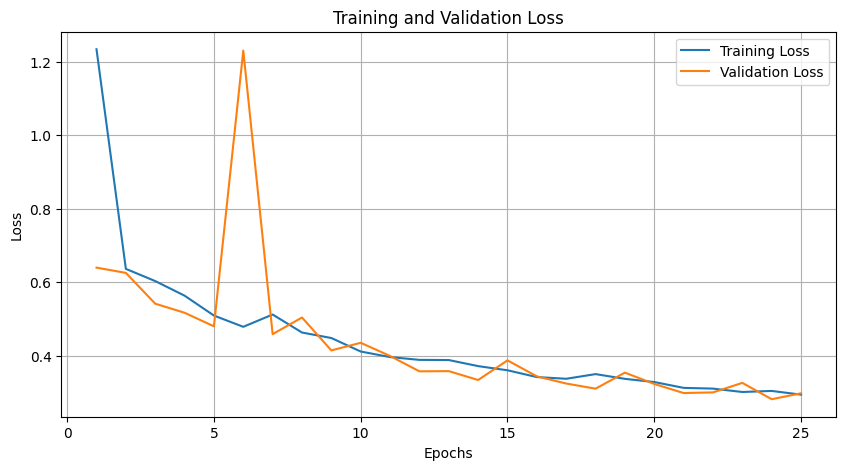

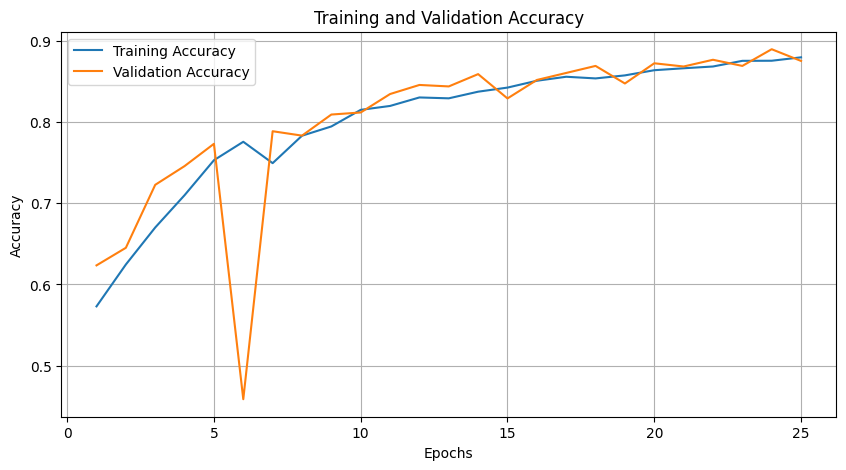

In [25]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
# plt.savefig('loss_plot.png')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
# plt.savefig('accuracy_plot.png')
plt.show()


In [4]:
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the saved model
model = CustomModel(in_channels=3, num_classes=2)
model.load_state_dict(torch.load('custom_modelbest1.pth'))
model = model.to(device)
model.eval()

# Function to calculate class-wise accuracy
def calculate_classwise_accuracy(model, test_loader, device, num_classes=2):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for i in range(len(all_labels)):
        label = all_labels[i]
        pred = all_preds[i]
        if label == pred:
            class_correct[label] += 1
        class_total[label] += 1

    classwise_accuracy = class_correct / class_total
    return classwise_accuracy

# Calculate class-wise accuracy
classwise_accuracy = calculate_classwise_accuracy(model, test_loader, device)

# Print class-wise accuracy
for i in range(len(classwise_accuracy)):
    print(f"Class {i} Accuracy: {classwise_accuracy[i] * 100:.2f}%")

# Calculate overall accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

overall_accuracy = correct / total * 100
print(f'Overall Accuracy: {overall_accuracy:.2f}%')


C:\Users\Jeevan Prakash\AppData\Local\Temp\ipykernel_20348\2594754862.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('custom_modelbest1

Class 0 Accuracy: 92.10%
Class 1 Accuracy: 84.30%
Overall Accuracy: 89.61%


<Figure size 800x600 with 0 Axes>

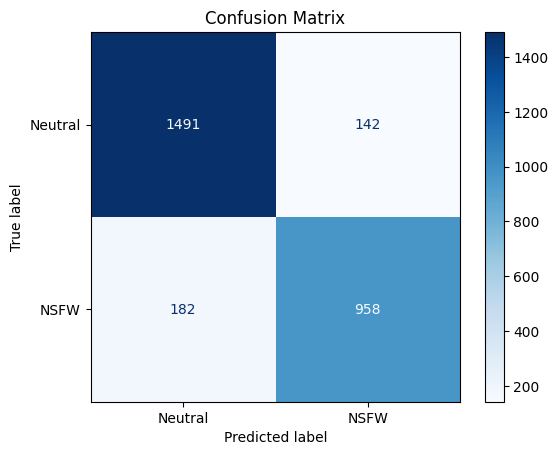

In [5]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Define class names for the two classes
class_names = ["Neutral", "NSFW"]

# Get predictions and ground truth labels for the test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot 1: Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()




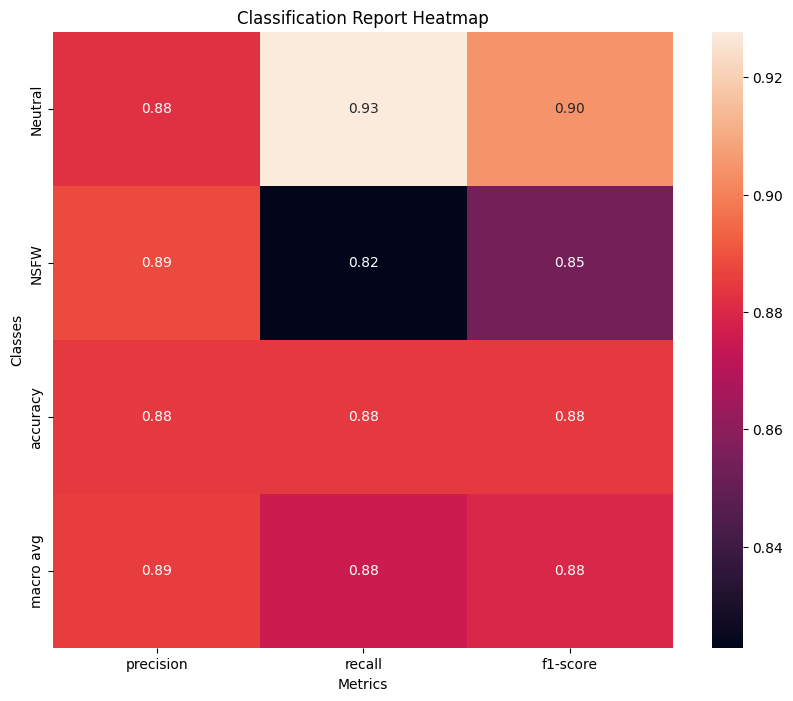

In [9]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

# Define class names for the two classes
class_names = ["Neutral", "NSFW"]

# Get predictions and ground truth labels for the test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the classification report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=class_names, 
    output_dict=True
)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    report_df.iloc[:-1, :-1],  # Exclude support row and accuracy column
    annot=True,  
    fmt=".2f"
)
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


In [7]:
from sklearn.metrics import classification_report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=class_names, 
    output_dict=False
)
print(report)

              precision    recall  f1-score   support

     Neutral       0.89      0.91      0.90      1633
        NSFW       0.87      0.84      0.86      1140

    accuracy                           0.88      2773
   macro avg       0.88      0.88      0.88      2773
weighted avg       0.88      0.88      0.88      2773



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel(in_channels=3, num_classes=2)
model.load_state_dict(torch.load('custom_modelbest1.pth'))
model = model.to(device)
# print(model)

C:\Users\Jeevan Prakash\AppData\Local\Temp\ipykernel_20348\666605805.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('custom_modelbest1.

In [14]:
subset_filenames = ['NSFW\\blood24_cid_0_fr_5917_ts_00-03-17-233_jpg.rf.2039190c0012342f391910585af51c6a.jpg', 'NSFW\\blood24_cid_0_fr_6240_ts_00-03-28-000_jpg.rf.062bb3e9fdb0d52aa1b9d41442a192be.jpg', 'NSFW\\blood24_cid_0_fr_635_ts_00-00-21-166_jpg.rf.659cab2f41e2f934caac5d5cec3382e7.jpg', 'NSFW\\blood24_cid_0_fr_6374_ts_00-03-32-466_jpg.rf.3ff3f3ef16bb0468567d8b7a442ab604.jpg', 'NSFW\\blood24_cid_0_fr_6377_ts_00-03-32-566_jpg.rf.9573a50ebbe8fe3e3201c36569893cfb.jpg', 'NSFW\\blood24_cid_0_fr_6429_ts_00-03-34-300_jpg.rf.9f4d5a5d1fb79c59d8bda150adff7000.jpg', 'NSFW\\blood24_cid_0_fr_6491_ts_00-03-36-366_jpg.rf.ccdb52c57175992b5fc714bc95b86680.jpg', 'NSFW\\blood24_cid_0_fr_6624_ts_00-03-40-800_jpg.rf.e6e9cc72a2ee0771d046c1c4a0650904.jpg', 'NSFW\\blood24_cid_0_fr_6626_ts_00-03-40-866_jpg.rf.83b0a920fed117dbac2c2857fd74db29.jpg', 'NSFW\\blood24_cid_0_fr_7799_ts_00-04-19-966_jpg.rf.2c6c015eda198f3024113470e25f9ccb.jpg', 'NSFW\\blood24_cid_0_fr_8377_ts_00-04-39-233_jpg.rf.7b48e31c04ab5cece2db359a3d071ccb.jpg', 'NSFW\\blood27_cid_0_fr_107_ts_00-00-04-304_jpg.rf.5aea6c4bb708d7876ae2940ffcbb8adf.jpg', 'NSFW\\blood27_cid_0_fr_109_ts_00-00-04-384_jpg.rf.7edea441624ce3794a167cdd9504f853.jpg', 'NSFW\\blood27_cid_0_fr_124_ts_00-00-04-988_jpg.rf.6517c67f0bb9341a184f3ad4a6b1c777.jpg', 'NSFW\\blood27_cid_0_fr_194_ts_00-00-07-804_jpg.rf.b263f3ed7899951562abe855ad86d9ac.jpg', 'NSFW\\blood27_cid_0_fr_215_ts_00-00-08-648_jpg.rf.5f5f830625d2c242db586cce98c40623.jpg', 'NSFW\\blood27_cid_0_fr_227_ts_00-00-09-131_jpg.rf.4766197aa2631f20c49a5694e6058ad6.jpg', 'NSFW\\blood27_cid_0_fr_230_ts_00-00-09-252_jpg.rf.94e552218a0f7ff82dea2d64a4c3ea6e.jpg', 'NSFW\\blood27_cid_0_fr_248_ts_00-00-09-976_jpg.rf.9bed2913a3bfaf63f6e01427bc5c58f6.jpg', 'NSFW\\blood27_cid_0_fr_289_ts_00-00-11-625_jpg.rf.2b4807cacc693b4f94c8f77e20583dcd.jpg', 'NSFW\\blood27_cid_0_fr_303_ts_00-00-12-188_jpg.rf.0a19d7d4cca7e30c23b6e45f3a9ff28a.jpg', 'NSFW\\blood27_cid_0_fr_310_ts_00-00-12-470_jpg.rf.1974b6f7dfe5e40377d1e9e107fa7a16.jpg', 'NSFW\\blood27_cid_0_fr_354_ts_00-00-14-240_jpg.rf.46757e27fa517de83cb19f1a9ec7c8b9.jpg', 'NSFW\\blood27_cid_0_fr_388_ts_00-00-15-608_jpg.rf.aabbcc6ac6932cd6bd78051ca2601e35.jpg', 'NSFW\\blood27_cid_0_fr_400_ts_00-00-16-090_jpg.rf.df481e96189e44c426170d06f0b7752a.jpg', 'NSFW\\blood27_cid_0_fr_440_ts_00-00-17-700_jpg.rf.7d055d9f3f54919aac5351cc6c8a1077.jpg', 'NSFW\\blood27_cid_0_fr_550_ts_00-00-22-125_jpg.rf.dabc2b5bf5978bb01b1270e2180b444b.jpg', 'NSFW\\blood27_cid_0_fr_589_ts_00-00-23-693_jpg.rf.cc96d5bca5cd2e6d781c8c100254f53a.jpg', 'NSFW\\blood27_cid_0_fr_628_ts_00-00-25-262_jpg.rf.d193663e563c5742070eddaf73083573.jpg', 'NSFW\\blood27_cid_0_fr_693_ts_00-00-27-877_jpg.rf.68c870b9a409862a6ca2095257c99a73.jpg', 'NSFW\\blood27_cid_0_fr_695_ts_00-00-27-957_jpg.rf.6b882da38368f794a1635db10eccb9fb.jpg', 'NSFW\\blood28_cid_0_fr_1342_ts_00-00-44-733_jpg.rf.f4e7943ba20d1d098d084dc24347ee79.jpg', 'NSFW\\blood28_cid_0_fr_1346_ts_00-00-44-866_jpg.rf.e9eda6496f9b25148f05f07dbd9e2823.jpg', 'NSFW\\blood28_cid_0_fr_2757_ts_00-01-31-900_jpg.rf.607a9e4eaf3aad62e57f3c27f2653d1c.jpg', 'NSFW\\blood28_cid_0_fr_3437_ts_00-01-54-566_jpg.rf.4f6d6a4a84e72b7a6341e3b8eef90b72.jpg', 'NSFW\\blood28_cid_0_fr_3442_ts_00-01-54-733_jpg.rf.6ac842c084fe62a4ae0e6134e5f677e9.jpg', 'NSFW\\blood28_cid_0_fr_3547_ts_00-01-58-233_jpg.rf.8d11a4177b9c2a8e276e9962d8e847cf.jpg', 'NSFW\\blood28_cid_0_fr_3713_ts_00-02-03-766_jpg.rf.0e881612229bcdf38ce272db4f9b2ae1.jpg', 'NSFW\\blood28_cid_0_fr_4019_ts_00-02-13-966_jpg.rf.955ba2cd2b21c2f35167d786ad1c9942.jpg', 'NSFW\\blood28_cid_0_fr_4021_ts_00-02-14-033_jpg.rf.a500082c2fc0812462cb8f62cfd69a1f.jpg', 'NSFW\\blood28_cid_0_fr_4088_ts_00-02-16-266_jpg.rf.ccb0619cc8769a0541cd60d603cc1b39.jpg', 'NSFW\\blood28_cid_0_fr_4209_ts_00-02-20-300_jpg.rf.5889b1c1c791e2a08af10ad5a640283c.jpg', 'NSFW\\blood28_cid_0_fr_5109_ts_00-02-50-300_jpg.rf.d9d02863a719db4f105ea9cb8d4a887b.jpg', 'NSFW\\blood28_cid_0_fr_5134_ts_00-02-51-133_jpg.rf.fcd3f5279c065ffefa6646511dc1bfd2.jpg', 'NSFW\\blood28_cid_0_fr_7004_ts_00-03-53-466_jpg.rf.b1677132d05972e3fb973649602c7f4c.jpg', 'NSFW\\blood28_cid_0_fr_7648_ts_00-04-14-933_jpg.rf.e35ada7ed469804c572c6b4397b17b2c.jpg', 'NSFW\\blood_105_jpg.rf.6dda3b4b9cfc1d93adefdf02de262509.jpg', 'NSFW\\blood_106_jpg.rf.dea062059c6fb8ae27b4710e15fb6dd2.jpg', 'NSFW\\blood_111_jpg.rf.ee5976eaf93ee70cf782a0f167a4330f.jpg', 'NSFW\\blood_112_jpg.rf.0a0d85b3c2e4c64e88dc521d2c431832.jpg', 'NSFW\\blood_120_jpg.rf.dae9d25a6ec31a61c33915a051e7267f.jpg', 'NSFW\\blood_131_jpg.rf.69c71757382cb6ce2be30c6d67e28b6c.jpg', 'NSFW\\blood_139_jpg.rf.c1e5cd7bcf21df5efca4735316875bce.jpg', 'NSFW\\blood_163_jpg.rf.5a6c5e8523d2e536d92ee2da06a75bdc.jpg', 'NSFW\\blood_165_jpg.rf.893a7043555c51ef5a7a6baa76cc0e68.jpg', 'NSFW\\blood_177_jpg.rf.863bcb0f7b39df3f8c063b0413928b56.jpg', 'NSFW\\blood_185_jpg.rf.83cc8b433bae14b0891b6df8eb7e6caa.jpg', 'NSFW\\blood_186_jpg.rf.d905456ea83b4297bb34927b8b280293.jpg', 'NSFW\\blood_202_jpg.rf.485b39691497a80e942b4fe069e044c5.jpg', 'NSFW\\blood_209_jpg.rf.ce3c79a49a4dd25468c44a24c6012739.jpg', 'NSFW\\blood_238_jpg.rf.b6266199c23f0d642fcff022441af63e.jpg', 'NSFW\\blood_244_jpg.rf.ba254445076fd7b9d96c78c2680a20fa.jpg', 'NSFW\\blood_253_jpg.rf.6cc53d091e8a9864c922f5300f84e6eb.jpg', 'NSFW\\blood_25_jpg.rf.19b291c75e7fd0439c3180d694034b5a.jpg', 'NSFW\\blood_261_jpg.rf.d9138498ee93fb6aab2907a3a921e938.jpg', 'NSFW\\blood_262_jpg.rf.1f59a488afd4b46b2a598393e1912906.jpg', 'NSFW\\blood_272_jpg.rf.1b930c8b413fad39f5d4ce4490091b14.jpg', 'NSFW\\blood_289_jpg.rf.685100dc2d9c29bc9b323be9aead5fc3.jpg', 'NSFW\\blood_294_jpg.rf.06c93c31fb7dbb53dfe12b1f38d19382.jpg', 'NSFW\\blood_298_jpg.rf.e26867ec1767ce6d5ebb84506506328a.jpg', 'NSFW\\blood_323_jpg.rf.e74d2635228173427f2333d70963f081.jpg', 'NSFW\\blood_32_jpg.rf.31bbb23d541aa3bb88226200616e615c.jpg', 'NSFW\\blood_330_jpg.rf.e1e8f1fb605430f06a219b657c325e51.jpg', 'NSFW\\blood_334_jpg.rf.f5c3abad6e54b79070c5cdf481cd5967.jpg', 'NSFW\\blood_343_jpg.rf.3a0a850cfa7948f945145af6936f3a87.jpg', 'NSFW\\blood_345_jpg.rf.cfd497a29e78b12a101ef844927b8026.jpg', 'NSFW\\blood_351_jpg.rf.501b197e2c55f3d991941687094d9f35.jpg', 'NSFW\\blood_364_jpg.rf.12d703b60314f22489494d497609a053.jpg', 'NSFW\\blood_365_jpg.rf.4e2deb6662c7c788daee2a7fdcc43f40.jpg', 'NSFW\\blood_367_jpg.rf.3df5d3c6ef9c648f02d9c08af59bab6e.jpg', 'NSFW\\blood_375_jpg.rf.c6e62eee3c5509a6d4b2603e2e53899d.jpg', 'NSFW\\blood_37_jpg.rf.e1768afee24c394f7f39aa67547a5777.jpg', 'NSFW\\blood_382_jpg.rf.7bdf47be8c6c37846cf4d84615f304c1.jpg', 'NSFW\\blood_386_jpg.rf.afdf4e19366cfe2aa47036551bf13c8e.jpg', 'NSFW\\blood_38_jpg.rf.e0a751bec50ed01aa1b5b95379ba3e44.jpg', 'NSFW\\blood_404_jpg.rf.7ded96a5769b709e1f4e826020ddddc0.jpg', 'NSFW\\blood_405_jpg.rf.61101a9fa7193ec41cd2dcca03e86fc1.jpg', 'NSFW\\blood_412_jpg.rf.24937a262a2295b6dbb5a4f72b3be16b.jpg', 'NSFW\\blood_415_jpg.rf.9557dabc4b20d9ff22a723e581da88f4.jpg', 'NSFW\\blood_437_jpg.rf.098accd899c9714e0c1bc1d75a6f85e0.jpg', 'NSFW\\blood_440_jpg.rf.7856220160082e2158ff2916328fa3d8.jpg', 'NSFW\\blood_441_jpg.rf.936dcea1bdba573bb0578fb7cec12724.jpg', 'NSFW\\blood_445_jpg.rf.c824f32f85e975551b81dafad174645e.jpg', 'NSFW\\blood_449_jpg.rf.25dd1a86c311dc43397ac20d9f958b90.jpg', 'NSFW\\blood_450_jpg.rf.e71d96a1fbf8b4256d1e1b74649592a9.jpg', 'NSFW\\blood_465_jpg.rf.27cd38ce5dcc76941c18eed479565098.jpg', 'NSFW\\blood_471_jpg.rf.aa977ef392514d045bb1b06a5a4215ab.jpg', 'NSFW\\blood_473_jpg.rf.5faae2b48e60af200c08b511617c8768.jpg', 'NSFW\\blood_476_jpg.rf.0a89e9e62074f8789c788f7087f0c7c6.jpg', 'NSFW\\blood_478_jpg.rf.293785ffba84f022550aa5f56bc713f4.jpg', 'NSFW\\blood_47_jpg.rf.6a3e0917ec3ef498e92984c0f81d027b.jpg', 'NSFW\\blood_486_jpg.rf.488990cfdd30a3d26cfbd715b7b9b9dc.jpg', 'NSFW\\blood_490_jpg.rf.1ffbf8326cff61211244be53c0ec1f0f.jpg', 'NSFW\\blood_49_jpg.rf.42b57d874671c8a9c499d48ef1b772e1.jpg', 'NSFW\\blood_509_jpg.rf.fd58c01f7a558f9cdd724439cb474f39.jpg', 'NSFW\\blood_510_jpg.rf.ba02422ae55caf5fa1afdfd899b7b5d0.jpg', 'NSFW\\blood_512_jpg.rf.a8b55a0b8a3b8ff011339883d1d6c83b.jpg', 'NSFW\\blood_514_jpg.rf.ffa8a83d4ee8003b70077b543b05d827.jpg', 'NSFW\\blood_515_jpg.rf.e63d8a9d8851b574ff8170a652dcca42.jpg', 'NSFW\\blood_517_jpg.rf.26fd564b0b9407fea6871fdf6b740986.jpg', 'NSFW\\blood_520_jpg.rf.6b5b8c9e3cfd2ae51ee118d9dfd16404.jpg', 'NSFW\\blood_527_jpg.rf.e8fa7ed3cc1122f98cf3f7b512cc0909.jpg', 'NSFW\\blood_537_jpg.rf.eb2ef400c5732154f1bb5e96fc95b40e.jpg', 'NSFW\\blood_53_jpg.rf.b426cccaab38f6e92f046816f22af8c5.jpg', 'NSFW\\blood_544_jpg.rf.db4dbcf06b4f6d1c3f61b3679ba6d6c9.jpg', 'NSFW\\blood_558_jpg.rf.606f5cccfcfa29271cbbd480cce08e3f.jpg', 'NSFW\\blood_561_jpg.rf.7e3c3750a251206aa28e250bb3e54896.jpg', 'NSFW\\blood_570_jpg.rf.b80b0d652bcd5d8ba05231e0b12ef685.jpg', 'NSFW\\blood_574_jpg.rf.e1f1a1737208d6c9b80fc47fe5e5ef5b.jpg', 'NSFW\\blood_581_jpg.rf.0ebffccab529315f178d09e63c8a221c.jpg', 'NSFW\\blood_588_jpg.rf.3a43aa415d95de29b1f397803c166118.jpg', 'NSFW\\blood_595_jpg.rf.96302a3497b39c90bfe08913554791d4.jpg', 'NSFW\\blood_602_jpg.rf.2cf9c39f6324c160eae544cad66eea88.jpg', 'NSFW\\blood_608_jpg.rf.b6b53c8d5fc011506a967b985bb5c47a.jpg', 'NSFW\\blood_629_jpg.rf.4c1438f511f4f9edf20a35255a039c6b.jpg', 'NSFW\\blood_641_jpg.rf.6be9fa7f169a45912bdeef1c3000f485.jpg', 'NSFW\\blood_643_jpg.rf.bc3c7608d0dc720de65c7c958acfcc16.jpg', 'NSFW\\blood_656_jpg.rf.e86dc8d66fdf044c323e398e9ba8d191.jpg', 'NSFW\\blood_670_jpg.rf.58bc2cc63625a5d7ce1a69c333e75534.jpg', 'NSFW\\blood_684_jpg.rf.9504141dc361491558c7356290fd8e33.jpg', 'NSFW\\blood_692_jpg.rf.b620d31d11679530f90b105f4a3b9864.jpg', 'NSFW\\blood_696_jpg.rf.14b7ad3db4fc40759aa6207d67794069.jpg', 'NSFW\\blood_697_jpg.rf.341e770d5e273b4c58c63eefdb900fd4.jpg', 'NSFW\\blood_706_jpg.rf.55132998db811f07fb6341cfe246e7f4.jpg', 'NSFW\\blood_81_jpg.rf.df2405a397306149613189a271d71be3.jpg', 'NSFW\\blood_96_jpg.rf.5c4d713160ee41bac17534a59fb9e2e6.jpg', 'NSFW\\bnwniztbkfv71_jpg.rf.5029258ed9c56b3dc0f42191d87ca9aa.jpg', 'NSFW\\brooklyn_american_ale_jpg.rf.77713102201ff11881fa425005288ba4.jpg', 'NSFW\\brooklyn_brown_ale_355ml_dr_jpg.rf.ecac6d6c15ef532d1e61371d9200c54f.jpg', 'NSFW\\brooklyn_hecla_iron_ale_jpg.rf.b85f377975449333f32f47ed4d222cd6.jpg', 'NSFW\\brooklyn_sorachi_ace_drople_jpg.rf.d6161d5d449774d0b30ec80d0b832c67.jpg', 'NSFW\\buckle-with-modern-hook-swastika_jpeg.rf.42c5851f7a71e3b70b976d7d3a0a5677.jpg', 'NSFW\\buckle-with-modern-hook-swastika_jpeg.rf.4b2bfc039cd68b9cd1b9995b13d4cfdc.jpg', 'NSFW\\buckle-with-modern-hook-swastika_jpeg.rf.74e0e92fc6c7390f1d48f9d1d3c30837.jpg', 'NSFW\\butelka_ksiaz_pop_jpg.rf.1d939ef6834f2307b36fdbb83156a49b.jpg', 'NSFW\\by_alivaria-bogemskoe-parovoe_jpg.rf.d31a1f74c4ce5171283d01d59111669e.jpg', 'NSFW\\by_alivaria-gold_jpg.rf.c021e547712c4a6d6ce7f3403c1fe31b.jpg', 'NSFW\\by_kvas-alivarski_jpg.rf.7eafcc840b9e4a84749c6c1ce91851e1.jpg', 'NSFW\\c00glwktfgv71_jpg.rf.bf2b96825b50a12675b16ff3b06d6e60.jpg', 'NSFW\\c06b3395e0dd29d0b4f626b6c38e72c6aa605857_full_jpg.rf.0d45dacea2ef3189f83d22ac96391b5f.jpg', 'NSFW\\c470b6d623328f66d62af363f09be59017b6bc54_full_jpg.rf.b44080f34927b5ccb750c40b00cb943b.jpg', 'NSFW\\c626819eca56a8b65570bfe7f5ecfcb68ec883eb_full_jpg.rf.30001946b025433f8d7fc28c02f69aa4.jpg', 'NSFW\\c6ce3fb90d46d544cee489aa5b581f6f98bd53ae_full_jpg.rf.e4fafce19c0d6bdb801c17e693aa70f0.jpg', 'NSFW\\c793e5131dc469090f5a18210f5b87e95a699941_full_jpg.rf.aa8de0437ff346e7ed84ed3a87a9fb72.jpg', 'NSFW\\c793e5131dc469090f5a18210f5b87e95a699941_full_jpg.rf.d84d7cf232626ea5c4de5583156dd3cb.jpg', 'NSFW\\c7a04d193fa20595408f337dc60a055309c7a7b9_full_jpg.rf.bfabea83eb3cc6ada2814c8a502997bd.jpg', 'NSFW\\c938b5e8aafa4ae7e984e69258f6d7396696e642_full_jpg.rf.2a30c6070c0bf66b88b5f23f9e86dd0f.jpg', 'NSFW\\cb_nd_india_smooth_330ml_bottle_wet_isolated_rgb_72dpi_jpg.rf.23896a31741911a0bb564468f96f194b.jpg', 'NSFW\\cb_nd_smooth_draught_330ml_bottle_wet_isolated_rgb_72dpi_jpg.rf.9fc386b8cb090ba9a5e87b1d161eaee1.jpg', 'NSFW\\cd981efad2293dbf35861f8009f43ae700ee4142_full_jpg.rf.5f3fa2ad5b7164c4fa51d4f1c850d0e3.jpg', 'NSFW\\ch8ehwpz7iv71_jpg.rf.fc05e58ee109bb0711e0b883016c7f97.jpg', 'NSFW\\cid_0_fr_1344_ts_00-00-56-056_jpg.rf.0b684423037844eb2ad7ce2924bdad67.jpg', 'NSFW\\cid_0_fr_181_ts_00-00-06-111_jpg.rf.730cb16a5d43e01fa510aa41f32b791c.jpg', 'NSFW\\cid_0_fr_214_ts_00-00-07-226_jpg.rf.bc0548225369c0bdbc9b0934a8376161.jpg', 'NSFW\\cid_0_fr_2194_ts_00-01-31-508_jpg.rf.4eb93b557b003f6f137ed0b7877d8f70.jpg', 'NSFW\\cid_0_fr_2241_ts_00-01-33-468_jpg.rf.dd9dc480b402f5cacb94f80e50b90cb3.jpg', 'NSFW\\cid_0_fr_2243_ts_00-01-33-551_jpg.rf.bb85d2b0188013dab5f928e278877840.jpg', 'NSFW\\cid_0_fr_2244_ts_00-01-33-593_jpg.rf.6463de10e56034fe6291a381772f51af.jpg', 'NSFW\\cid_0_fr_2462_ts_00-01-42-685_jpg.rf.5a2e443f1a6646b0eb3c441e9e8e6743.jpg', 'NSFW\\cid_0_fr_2899_ts_00-02-00-912_jpg.rf.abd8e96c35c4e2a014fba58f8a987b6a.jpg', 'NSFW\\cid_0_fr_396_ts_00-00-13-200_jpg.rf.e0e5342cbdde6fef359e0336d4cefc05.jpg', 'NSFW\\cid_0_fr_628_ts_00-00-23-375_jpg.rf.91f3bca1ff251d4cf06c8ac943fc2e52.jpg', 'NSFW\\cid_0_fr_783_ts_00-00-29-144_jpg.rf.1db911bff83eb36d806b3d6de47f18a9.jpg', 'NSFW\\cid_0_fr_838_ts_00-00-31-191_jpg.rf.97696cdb5ae685df0d168263d124dc48.jpg', 'NSFW\\cigarettes-picture-id485389970_jpg.rf.27eae51f791f46570290fce6ef0bbdd5.jpg', 'NSFW\\cl7abkrbzgv71_jpg.rf.20ebececccc9bf1eeb6ce652c3e69b77.jpg', 'NSFW\\close-up-syringe-needle-extracting-heroin-spoon-cooking-using-filter-drug-abuse-opiate-addiction-240848763_jpg.rf.6262ee607cefe16e81cf1a651dfd2397.jpg', 'NSFW\\cocaine-social-2e16d0ba-fill-1200x1200_jpg.rf.9dd4f05a2646a9d472287b6ef641c396.jpg', 'NSFW\\cocaine_image01-12-_jpg.rf.c18c2fd6c02b77ccffa3eb6416d8c506.jpg', 'NSFW\\cocaine_image01-13-_jpg.rf.89e55799b483bc44f5ad7cfb0bc1e900.jpg', 'NSFW\\cocaine_image01-23-_jpg.rf.04f800566805b6cdac51e4340428117d.jpg', 'NSFW\\cocaine_image01-28-_jpg.rf.5e8fb08bc20ada48c52e23f17d3b9e43.jpg', 'NSFW\\cocaine_image01-3-_jpg.rf.f8ebcd6da231199c06249941b8c12631.jpg', 'NSFW\\cocaine_image01_jpg.rf.fb0d3c58dab3717583082181fdc2c2ca.jpg', 'NSFW\\cocaine_image02-12-_jpg.rf.4e09950aee7a401cf88d1ae2473aca9f.jpg', 'NSFW\\cocaine_image02-25-_jpg.rf.0ad547372bbba59f630ba74f2a3ff790.jpg', 'NSFW\\cocaine_image02-6-_jpg.rf.e31b0a9e9f3755d4eb32171161fe8887.jpg', 'NSFW\\cocaine_image02_jpg.rf.a59f260418e232c97b98659be1f5d713.jpg', 'NSFW\\cocaine_image03-24-_jpg.rf.22816bca03248684281e26722165e9e2.jpg', 'NSFW\\cocaine_image03-27-_jpg.rf.5885c3518b7dd89f3c3a296dd05cdf74.jpg', 'NSFW\\cocaine_image03-28-_jpg.rf.aca9ddd80f3887d45a1977f07a88502b.jpg', 'NSFW\\cocaine_image03-7-_jpg.rf.21451c357eda587ad3458f0ce2064fbe.jpg', 'NSFW\\cocaine_image04-11-_jpg.rf.025c29f9cdbe975dde62008b75d41746.jpg', 'NSFW\\cocaine_image04-17-_jpg.rf.c5db04767a761128f143d73a4edb72e8.jpg', 'NSFW\\cocaine_image04-18-_jpg.rf.6020983c582326949e8d12b9ff8d437d.jpg', 'NSFW\\cocaine_image04-3-_jpg.rf.87ff174f838d6cc47e9962ae496ca09b.jpg', 'NSFW\\cocaine_image04-5-_jpg.rf.6370d3d1a64b14d42d46ce7578f63497.jpg', 'NSFW\\cocaine_image05-13-_jpg.rf.6156be6dc239a5493dbc40ff601ebe47.jpg', 'NSFW\\cocaine_image05-15-_jpg.rf.aff23d6494f1c440edb5b854e0e57752.jpg', 'NSFW\\cocaine_image05-25-_jpg.rf.b74092b65b1871f0853542daeb66451f.jpg', 'NSFW\\cocaine_image05-31-_jpg.rf.186be1863b99b52a978885efd0ce0cd0.jpg', 'NSFW\\cocaine_image05-32-_jpg.rf.7874d10a6bdde4a83239ef67bb6ad0fb.jpg', 'NSFW\\cocaine_image06-11-_jpg.rf.7e95f927860c076f07f422bcff991244.jpg', 'NSFW\\cocaine_image06-13-_jpg.rf.66b0fb9aa0fe34a7e9ba13f44c2cc6d2.jpg', 'NSFW\\cocaine_image06-2-_jpg.rf.fc23ac9f04f6a9f62e6b32a3261b8be7.jpg', 'NSFW\\cocaine_image06-20-_jpg.rf.42ae978983859412b86318f9d178eda6.jpg', 'NSFW\\cocaine_image06-26-_jpg.rf.0a34f66be3e23805448a8538d45d8b12.jpg', 'NSFW\\cocaine_image06-6-_jpg.rf.5ea49ae9217253806c20292d784722bd.jpg', 'NSFW\\cocaine_image07-1-_jpg.rf.6e2c044948c863e8ee3d55c72662fa9f.jpg', 'NSFW\\cocaine_image07-10-_jpg.rf.8d9194ff3617d6d50ac0e46b4e41b6e0.jpg', 'NSFW\\cocaine_image07-12-_jpg.rf.f621c107ccf6e88f5fe1326ed2b7bfe6.jpg', 'NSFW\\cocaine_image07-24-_jpg.rf.a99a3ee61c737e710d46595220941ed4.jpg', 'NSFW\\cocaine_image07-26-_jpg.rf.6db75dc25041ce4509efa2dadbbc40f7.jpg', 'NSFW\\cocaine_image07-28-_jpg.rf.dd309a81c068c2860373f8ef1d17d606.jpg', 'NSFW\\cocaine_image07-3-_jpg.rf.eaa25994de1d436353f59a851c77a101.jpg', 'NSFW\\cocaine_image07-35-_jpg.rf.3b7912aaf276e8f9cb8a99438df2bcb7.jpg', 'NSFW\\cocaine_image07-6-_jpg.rf.cea90009f2db35186adece7e24dbbeca.jpg', 'NSFW\\cocaine_image08-15-_jpg.rf.14891531a48f5446a0e6d96934def57e.jpg', 'NSFW\\cocaine_image08-18-_jpg.rf.cbb17cec6a28c69316474147a04bb639.jpg', 'NSFW\\cocaine_image08-21-_jpg.rf.3738546d6d3fc78e513a98879fba583e.jpg', 'NSFW\\cocaine_image08-22-_jpg.rf.08ca9be1372cd846cc8ac7a0deab2ed2.jpg', 'NSFW\\cocaine_image08-24-_jpg.rf.7d55e7557500ae025514e6fa97b1b714.jpg', 'NSFW\\cocaine_image08-28-_jpg.rf.876b90ade9c6b8d62f81e54f34079449.jpg', 'NSFW\\cocaine_image08-5-_jpg.rf.eae771509003bfb4f3ed53411489e0aa.jpg', 'NSFW\\cocaine_image09-12-_jpg.rf.757d6f3d0a1c024b1ae20dc26dae0023.jpg', 'NSFW\\cocaine_image09-28-_jpg.rf.72ad99264d016cae93ac6af83ec5d7d6.jpg', 'NSFW\\cocaine_image09-31-_jpg.rf.beda5947c760e8497f94aaffacddf03c.jpg', 'NSFW\\cocaine_image1-14-_jpg.rf.d65d6731152f3ad42d7e2b536d8b21e5.jpg', 'NSFW\\cocaine_image1-2-_jpg.rf.2775c0f25774d4b06373d3748aeb1364.jpg', 'NSFW\\cocaine_image1-23-_jpg.rf.7cb93ebfa401894f3e1f2b6a5a4e09a4.jpg', 'NSFW\\cocaine_image1-4-_jpg.rf.30ca89507213ecf36633835bbb9fa9d9.jpg', 'NSFW\\cocaine_image10-12-_jpg.rf.f2daa8aec8bdc6d9896ed6042b772789.jpg', 'NSFW\\cocaine_image10-26-_jpg.rf.29486c908ff2bfada8989f89cae24a0a.jpg', 'NSFW\\cocaine_image10-6-_jpg.rf.7e1a51b484bb64b6947c8b63151bd9f1.jpg', 'NSFW\\cocaine_image10-8-_jpg.rf.509f0efbffae280aee116170e5d72d18.jpg', 'NSFW\\cocaine_image10_jpg.rf.a9d59e954bb9464db219bac77c5d4996.jpg', 'NSFW\\cocaine_image11-2-_jpg.rf.51240e9ffd5cd9a0a62d82165164bbfd.jpg', 'NSFW\\cocaine_image11-26-_jpg.rf.811354ee57c1e9de7ae7e587a2089e93.jpg', 'NSFW\\cocaine_image11-5-_jpg.rf.f69e68808b7571910effe5dfce8b65df.jpg', 'NSFW\\cocaine_image11-6-_jpg.rf.a5e5e963ed8dea4c6affb899c5f4ebe0.jpg', 'NSFW\\cocaine_image11-8-_jpg.rf.8c151882aa567072079022f0a3dbbee0.jpg', 'NSFW\\cocaine_image11-9-_jpg.rf.3175b1501987a77c21aa8d0d50283e32.jpg', 'NSFW\\cocaine_image12-13-_jpg.rf.6eb04f3060ec72c4cc089e04bc9418df.jpg', 'NSFW\\cocaine_image12-16-_jpg.rf.c57e6619f558f58b9568f02ac43e0b32.jpg', 'NSFW\\cocaine_image12-6-_jpg.rf.fd93fde9fa09740b4c5bd4f293bca99a.jpg', 'NSFW\\cocaine_image13-9-_jpg.rf.2c6a2a89e9e492e5db9e9fcb816daa77.jpg', 'NSFW\\cocaine_image14-15-_jpg.rf.1ada64e186faf0b46cda45604103bdd5.jpg', 'NSFW\\cocaine_image14-9-_jpg.rf.dc81000bf65566e6a866b64185e1eb2f.jpg', 'NSFW\\cocaine_image15-13-_jpg.rf.4a84c525d7e9193254e95a9f64bcf7f8.jpg', 'NSFW\\cocaine_image15-2-_jpg.rf.0af80937f1a6ddcf299a25904d094b94.jpg', 'NSFW\\cocaine_image15-6-_jpg.rf.689492d01d14122648f5ff1e3d64d112.jpg', 'NSFW\\cocaine_image18-3-_jpg.rf.7c16e8fb04f323ff96c8089962bf3350.jpg', 'NSFW\\cocaine_image19-4-_jpg.rf.5c10f80eebef5cb047860db2b97faa5c.jpg', 'NSFW\\cocaine_image19-5-_jpg.rf.973fe7cb9ee5613d8a8d5baf7b1384ab.jpg', 'NSFW\\cocaine_image2-13-_jpg.rf.90899269194b46c275fec034c94e16b6.jpg', 'NSFW\\cocaine_image2-14-_jpg.rf.80e885bacb28d1339b7a9d14b10717b4.jpg', 'NSFW\\cocaine_image2-4-_jpg.rf.22e89c102964593001cfc7f8f2be0b2f.jpg', 'NSFW\\cocaine_image2-8-_jpg.rf.bcf494a09f4decc695e6187d70c40e8c.jpg', 'NSFW\\cocaine_image21_jpg.rf.44f7a5c77fd0cf6cd8b47f27c1d7ccdf.jpg', 'NSFW\\cocaine_image22-3-_jpg.rf.3c8d35c50ed64b863b9af13e5035924e.jpg', 'NSFW\\cocaine_image24-1-_jpg.rf.9d5e981bf4fa49807f888f2ff4663766.jpg', 'NSFW\\cocaine_image24-2-_jpg.rf.af35766d0e9a333703172eea91af9836.jpg', 'NSFW\\cocaine_image25-1-_jpg.rf.ab3abf20b8b003c0934c27def2bbd2bc.jpg', 'NSFW\\cocaine_image29_jpg.rf.fa1e089dbdf4f1cf6db25db8fd6011df.jpg', 'NSFW\\cocaine_image3-1-_jpg.rf.301fb125289aee6fd7de19f59eaab604.jpg', 'NSFW\\cocaine_image3-14-_jpg.rf.ac974c89dab33a8e76cf12cca8bc9fed.jpg', 'NSFW\\cocaine_image3-6-_jpg.rf.3009975eca37a667086aea75ec3a5124.jpg', 'NSFW\\cocaine_image3-8-_jpg.rf.a25601277e25b6436042b373daad88fb.jpg', 'NSFW\\cocaine_image34_jpg.rf.5b7f3aaa7b58960033bbb79ae52b5cfe.jpg', 'NSFW\\cocaine_image4-10-_jpg.rf.d03fef6934c5470247b9ac820f64de0e.jpg', 'NSFW\\cocaine_image4-3-_jpg.rf.e9094d1ee50cb3ed01fe918f6df8d7d4.jpg', 'NSFW\\cocaine_image41_jpg.rf.6cc47305a48727ac5cdd7a4d88db3bec.jpg', 'NSFW\\cocaine_image4_jpg.rf.8aa72d52a8f76bc5b540ddae189b1a81.jpg', 'NSFW\\cocaine_image5-8-_jpg.rf.95500212cf6274b04e13e3a5f2162851.jpg', 'NSFW\\cocaine_image6-1-_jpg.rf.e4b4c5437c7a7f9bda9c95ee7a37fe5b.jpg', 'NSFW\\cocaine_image6-3-_jpg.rf.86fdad70b89f272bab2d90eb362f6080.jpg', 'NSFW\\cocaine_image7-9-_jpg.rf.bf472cd44b9585a80571d78ddf7094a6.jpg', 'NSFW\\cocaine_image8-2-_jpg.rf.bd0da1790190f0150918e6106e74f269.jpg', 'NSFW\\cocaine_main_jpg.rf.4c15775e8253d1470449f5f6b6a6edea.jpg', 'NSFW\\cphhckfxfev71_jpg.rf.c03d467227cfc32a9e9e61ffb3fc78fa.jpg', 'NSFW\\crystalweed-cannabis-Wl_Xv2MRRZw-unsplash_jpg.rf.1ea14e44fbebce87d70e68feb4558447.jpg', 'NSFW\\cyipqwafggv71_jpg.rf.e00cc63c62787cd45c974159b84b579c.jpg', 'NSFW\\d-P_meUEEL9nkYwG_dQfKGoBvB7ooMQEcKsmUiAphAs_jpg.rf.316dec5e09d26ad5e365821dbf2a6136.jpg', 'NSFW\\d-P_meUEEL9nkYwG_dQfKGoBvB7ooMQEcKsmUiAphAs_jpg.rf.32f28744a79427d1b97e4ad6992be3e9.jpg', 'NSFW\\d24498ab649e0c65435656a9ff1ad05e85d0158e_full_jpg.rf.f517be4011e81c58c54c03581cfd1e42.jpg', 'NSFW\\d2proschwgv71_jpg.rf.0a3e7e2d33cfa70c98180a4a9cf5ab3b.jpg', 'NSFW\\d4f4cc55ebe684765e5de9b8495809c647c0320f_full_jpg.rf.e2856b36f4b97273a5987f53ba92cb65.jpg', 'NSFW\\d5c17e7123e5a307e5e4503d1d345d3b4dcf9d3f_full_jpg.rf.821fa3c16856a3c9ddf001827ae817f4.jpg', 'NSFW\\d5c17e7123e5a307e5e4503d1d345d3b4dcf9d3f_full_jpg.rf.8d3b63e31a383c50f1ecb491fdea1ab3.jpg', 'NSFW\\db409a7ade52b52a1eeba24e5c462911c9c7b2a2_full_jpg.rf.8ad833140746f61848d8f18dcbddf1d2.jpg', 'NSFW\\dd8101c4d554cd247280aa3ab51f8589f5716418_full_jpg.rf.c20706cf99398547575a239ff34eba8c.jpg', 'NSFW\\depositphotos_265372410-stock-photo-cropped-view-killer-washing-knife_jpg.rf.56bd3b403efc611ba143297d5078b1a6.jpg', 'NSFW\\depositphotos_265372638-stock-photo-partial-view-woman-washing-bleeding_jpg.rf.d1cf69eade2cc9608b508b51ec082caa.jpg', 'NSFW\\depositphotos_3477529-stock-photo-boy-with-head-injury_jpg.rf.dcddd08bd231729b91395924e9a47d98.jpg', 'NSFW\\depositphotos_423518448-stock-photo-bloody-hand-isolated-white-background_jpg.rf.43d93cccff8372d14bea9bfcf7e5ab4a.jpg', 'NSFW\\depositphotos_652673400-stock-photo-bloody-hand-isolated-white-concept_jpg.rf.143726d331ebc653f0650ac0158b3240.jpg', 'NSFW\\depositphotos_79274952-stock-photo-casualty-of-terrorist-attack_jpg.rf.8d473d5e90ecbe2cf84bd9f0a2979692.jpg', 'NSFW\\df2392f811f3acf3f0b2eedcaa48a87fa54db503_full_jpg.rf.6efd17fa471a3534438eee9c72666ac2.jpg', 'NSFW\\different-hard-drugs-black-background-closeup-different-hard-drugs-black-background-closeup-space-text-268307985_jpg.rf.c61006e06ede46ab5b48b284b1f4a9a0.jpg', 'NSFW\\download-11-_jpg.rf.7a3685704c6b7ac82c86fcba3e7599db.jpg', 'NSFW\\download-12-_jpg.rf.5bb886e2c40c36970d2a1613c3cd3e23.jpg', 'NSFW\\download-13-_jpg.rf.7d98f06e26a2d0df73ec9d8aef34b774.jpg', 'NSFW\\download-14-_jpg.rf.035f82a830cf597f1057ac85ec5b627a.jpg', 'NSFW\\download-16-_jpg.rf.f90276d057e23e68153451c3076d2d0a.jpg', 'NSFW\\download-18-_jpg.rf.20e87c8cf0345589644a4acb1501ae70.jpg', 'NSFW\\download-2-_jpeg.rf.fa5ee71596da9af3dea850fc0df0af41.jpg', 'NSFW\\download-21-_jpg.rf.b9a5e6fe36e149cd725dd9b6cb541dc1.jpg', 'NSFW\\download-22-_jpg.rf.ba7f0eb5e781d60251ce58b8c788f33d.jpg', 'NSFW\\download-26-_jpg.rf.3842d52ad9c94a913bfd0dc7f47f3cdc.jpg', 'NSFW\\download-26-_jpg.rf.681a72d77a0d95165f37696a47c47181.jpg', 'NSFW\\download-27-_jpg.rf.3f497e1087c968eed6a33d7ba7df7506.jpg', 'NSFW\\download-28-_jpeg_jpg.rf.c7e9efe47e24ecffcc62ee239b541f97.jpg', 'NSFW\\download-29-_jpeg_jpg.rf.ba981c65d8b24279a035e15129d94f61.jpg', 'NSFW\\download-29-_jpg.rf.af0ce7c64d1fbbfa9cef53c7819adf8b.jpg', 'NSFW\\download-29-_jpg.rf.c2a9279662a665aa1a1efd4f045b4bc5.jpg', 'NSFW\\download-3-_jpeg.rf.06760436e11f82c9efd2213faf9a4916.jpg', 'NSFW\\download-30-_jpg.rf.3a8e86da9a7a37ae10c4e82db3181f92.jpg', 'NSFW\\download-32-_jpg.rf.a6451464bd0ab3edab582631034ebade.jpg', 'NSFW\\download-33-_jpg.rf.e769260b7caa2b30d0f72f3e8473b3ae.jpg', 'NSFW\\download-36-_jpg.rf.e5ba1e830cab9b3c55e55dff715e3468.jpg', 'NSFW\\download-37-_jpg.rf.a40eab0455bcbfd56f08e80c4066ceb7.jpg', 'NSFW\\download-39-_jpg.rf.46bd072a9fb0ab77a0fc382b0a538a77.jpg', 'NSFW\\download-4-_jpg.rf.cfa7996fa06f8f2b55d6917fbed3e954.jpg', 'NSFW\\download-41-_jpg.rf.7cf52242d6ddfee4ad253b5836b6de21.jpg', 'NSFW\\download-41-_jpg.rf.da39cde57b235aef51d7336c6357a890.jpg', 'NSFW\\download-42-_jpg.rf.43fbe2f1b7bdbeef1c9a8aa7022f9a7a.jpg', 'NSFW\\download-43-_jpg.rf.ad5f0de60c5ecbbd13c59e25470639c0.jpg', 'NSFW\\download-48-_jpg.rf.c8607d065520cdc03a82d443f8ed32b1.jpg', 'NSFW\\download-5-_jpeg.rf.d7cd63cbc144256746256a75ecedd250.jpg', 'NSFW\\download-54-_jpg.rf.d2e055d9a8a70550faaf3f30eecdfc01.jpg', 'NSFW\\download-55-_jpg.rf.c20bf6ffc5cad69fbc77c43029424c04.jpg', 'NSFW\\download-56-_jpg.rf.85b5dd5bca30a8d79aff66dc68b7685d.jpg', 'NSFW\\download-6-_jpeg.rf.6d928fdafdffc091f1786c20a685f7e0.jpg', 'NSFW\\download-65-_jpg.rf.598422ec2a109ae8d7ad430e1512900d.jpg', 'NSFW\\download-69-_jpg.rf.cddca430208edff3203f3d6e26a220a2.jpg', 'NSFW\\download-7-_jpeg.rf.1da2a4ded62a782d1eb12a38fc3160a2.jpg', 'NSFW\\download-7-_jpg.rf.09be9d3fe0dc29fd351e97b478fbfff7.jpg', 'NSFW\\download-70-_jpg.rf.340ae23a6b99dae4148eb02e3a640fbb.jpg', 'NSFW\\download-73-_jpg.rf.939cbb45e9f3ee6a4496cb21b57c556e.jpg', 'NSFW\\download-74-_jpg.rf.4ef679d7ebaf053edd5f75de9e88239b.jpg', 'NSFW\\download-74-_jpg.rf.624998f9572a1b6123ef8b00a3f135d5.jpg', 'NSFW\\download-77-_jpg.rf.c50ab2a6479a95f7b9655cc86321cf55.jpg', 'NSFW\\download-8-_jpeg.rf.1f1fba6a822702ed48ecce494fac2d97.jpg', 'NSFW\\download-8-_jpg.rf.fba59b3861f38243df347ce1002d38f8.jpg', 'NSFW\\download-9-_jpg.rf.2bb9f31eea510e50649be01ff3d8e497.jpg', 'NSFW\\drugabuse-shutterstock220086538-cocaine_feature_image-cocaine-500x260_jpg.rf.81094ab718cca8001dd60e1db6c6deb3.jpg', 'NSFW\\dvvhuohdvlv71_jpg.rf.36cc7032bf82c96ecac3401ea6e210ef.jpg', 'NSFW\\dvyi16op2iv71_jpg.rf.63b0f215d26185a8a2fda407260ea208.jpg', 'NSFW\\e3b0dbddd1e4c1805dd81ba5c33ec0f3dd7cf325_full_jpg.rf.18c4621ff32874b7106514675099e5f3.jpg', 'NSFW\\e3b0dbddd1e4c1805dd81ba5c33ec0f3dd7cf325_full_jpg.rf.a5eee32778438beca26c37338e04c139.jpg', 'NSFW\\e56c359b568d586bb726537f1b87a504_jpg.rf.468192cc211f877628b6e56c155704a3.jpg', 'NSFW\\e5fd59b6b97ea0d8509612e67235353194b22fc9_full_jpg.rf.0a7504e7513cadc05e494619b5138a57.jpg', 'NSFW\\e7bcb3f794e5c4dd8dabd0082d1abdc7069207aa_full_jpg.rf.2eeaf25235e1aba7b712d89c6f24cc2f.jpg', 'NSFW\\e7bcb3f794e5c4dd8dabd0082d1abdc7069207aa_full_jpg.rf.7571e935a35b19644052d3523d5a18aa.jpg', 'NSFW\\e7d9b73121f0e30a1169fd39447e7780d733106c_full_jpg.rf.eab90f6b9fcb0207ba70fd75624f7ca4.jpg', 'NSFW\\ebd77tikkkv71_jpg.rf.95f8f973bc98d4805b9d8d5cd12fa944.jpg', 'NSFW\\ed10bf5ed6763c244237b05bcc505885c5983a89_full_jpg.rf.515c74f60413ad24934190262b1c39a8.jpg', 'NSFW\\ef016759d414a6641d5a76fdfd7c9f5088b1e263_full_jpg.rf.ca2c8387ccf271e9007e8ad5f4510899.jpg', 'NSFW\\ef4aa3da4b04ed6b6e78bc4febbdc81461b34a1d_full_jpg.rf.d7de120131b955866ada8b06a80cc5c0.jpg', 'NSFW\\eiy3poj44mv71_jpg.rf.17105ab86e5863a5b367d6b87edfe738.jpg', 'NSFW\\f2c5ff3d74802939eebbedc91f8a03f189a1ac1b_full_jpg.rf.3039f16b5517e355f0224585ff1ce3df.jpg', 'NSFW\\f3d7b8e84d78366978a69f17eec473af5ebc761f_full_jpg.rf.37d9523c932c199a325eac1e3466db31.jpg', 'NSFW\\f4w3zom4rjv71_jpg.rf.b4f0769c379b1b23cdf5844a60b9ecda.jpg', 'NSFW\\f5jqodp4amv71_jpg.rf.2d068ea3b3680c4b783543ea9688c50f.jpg', 'NSFW\\f6f409bcf88d9285a4937563c0140ce617fb751e_full_jpg.rf.2713aa81d7f024c0b5e9d25c93eb9954.jpg', 'NSFW\\f877294176d9b3a059614cfc2a3ed8db4881357b_full_jpg.rf.83690b407f4b9215b49e39a1c6633764.jpg', 'NSFW\\f877294176d9b3a059614cfc2a3ed8db4881357b_full_jpg.rf.8ca11b8b4bfd34a469282255d448dcf3.jpg', 'NSFW\\fc1694219df7b0287ccf1197f0a772ff1a5be0c1_full_jpg.rf.f535648387fc99de8f777378d90261da.jpg', 'NSFW\\feace19ec00e42492178bad22773e2aa257005f9_full_jpg.rf.429a82ac8705d3724967e610240483ad.jpg', 'NSFW\\file6671294953373_jpg.rf.3e651d9c95a91074d6bb4493bf05caef.jpg', 'NSFW\\file7091294954768_jpg.rf.491678798aa9c1402441c82ba020dac0.jpg', 'NSFW\\fpmcmpx8llv71_jpg.rf.1768d19cfaabe73c18177155deb741d9.jpg', 'NSFW\\gabzwyw3ybv71_jpg.rf.040320d00720a9d78776de10ee96efda.jpg', 'NSFW\\geeikbo0mmv71_jpg.rf.64313bb2128d0b5299d3d698d54e3fba.jpg', 'NSFW\\geeikbo0mmv71_jpg.rf.8c43e6f2d24d8c6bbcc267a7f21fea12.jpg', 'NSFW\\gene-editing-makes-mice-cocaine-proof-309605-1280x720_jpg.rf.5126988f9b0f50359ae126f5a3665bcf.jpg', 'NSFW\\gettyimages-1191358557-612x612_jpeg.rf.15a5daec86785ed0f9e324136496a3e2.jpg', 'NSFW\\gruppe-der-verwirrte-junge-kinder-winken-ns-hakenkreuz-fahnen-zur-unterstutzung-einer-lokalen-ns-parade-1930-saarland-deutschland-m6pg6g_jpeg.rf.d94c15b1f6d81e41e7ed1e274010d654.jpg', 'NSFW\\gruppe-der-verwirrte-junge-kinder-winken-ns-hakenkreuz-fahnen-zur-unterstutzung-einer-lokalen-ns-parade-1930-saarland-deutschland-m6pg6g_jpeg.rf.fb4b0db14b1061ce5e2dd64cdb99bc76.jpg', 'NSFW\\h5fayrf73nv71_jpg.rf.a98d2d0a2ca7be9389feb2781bb6d721.jpg', 'NSFW\\h8v1pjvrdgv71_jpg.rf.d78533da3d1f30aa3d6ecb0d2bfe5dda.jpg', 'NSFW\\hakenkreuz-armbinde-auf-einheitliche-brownshirt-ctfb2x_jpeg.rf.c7bc0a803a001de9a7555fe9cbf51317.jpg', 'NSFW\\hakenkreuz-graffiti-legacy-bln_1462799368-768x432_jpeg.rf.e5b3146710986ceb610eb8d9140083d8.jpg', 'NSFW\\hakenkreuz-symbol1234_jpeg.rf.0688864b800b62d59ec170b8a1884615.jpg', 'NSFW\\hakenkreuz-symbol_jpeg.rf.0229025adfef34619de802fc501e8f3e.jpg', 'NSFW\\hakenkreuz_jpeg.rf.17e2b6b6f9c9525c605d59b3c1e655de.jpg', 'NSFW\\hakenkreuz_jpeg.rf.b59e080613877ab8108a8b0800b41a9e.jpg', 'NSFW\\header-cocaine-acidification_jpg.rf.f23d18e33494be564da2de999aa4b608.jpg', 'NSFW\\heap-white-snow-isolated-black-background-heap-white-snow-isolated-black-background-close-up-192412403_jpg.rf.5e070e2f8891ea778fc581b358008d43.jpg', 'NSFW\\heroin-powder-drugs-syringe-medium-shot-heroin-powder-drugs-syringe-medium-shot-selective-focus-283006696_jpg.rf.7a460c9189f11e002f9fc142085c25ee.jpg', 'NSFW\\heroin_image01-4-_jpg.rf.6c5b2a77ecaaaeed05c3058329163bb0.jpg', 'NSFW\\heroin_image01-9-_jpg.rf.c0cb7f0ef03999624fae9168cc91efc4.jpg', 'NSFW\\heroin_image02-11-_jpg.rf.8e251068ebcac3504bf5eaa9ce21d8ef.jpg', 'NSFW\\heroin_image02-4-_jpeg.rf.da141757a1414a71a3d7d55e73c59ab9.jpg', 'NSFW\\heroin_image02-6-_jpg.rf.7203a233ae1f80fb81798120a4f374aa.jpg', 'NSFW\\heroin_image02_jpeg.rf.56507f232fded7fb09f2115eb6a00edd.jpg', 'NSFW\\heroin_image03-11-_jpg.rf.203a9532c25ef4becb6542c24ce11563.jpg', 'NSFW\\heroin_image03-2-_jpg.rf.fd5211ba58fc799fb1ae875412635ffc.jpg', 'NSFW\\heroin_image03-6-_jpg.rf.ae2bf2fb74a1c5facebb88e8bf6fb06f.jpg', 'NSFW\\heroin_image04-1-_jpeg.rf.0872ec295b609cf3f575a0a439f0a4aa.jpg', 'NSFW\\heroin_image04-3-_jpeg.rf.7421ebcc783d7d573996a2bd35fff66d.jpg', 'NSFW\\heroin_image05-3-_jpg.rf.b13914d79bb547824a0f62afc4c82f8b.jpg', 'NSFW\\heroin_image05-7-_jpg.rf.712425482ac80f5b3c32d63c14225946.jpg', 'NSFW\\heroin_image06-10-_jpg.rf.d9cbd17000dc6cddb78d9881dd0bda03.jpg', 'NSFW\\heroin_image06-5-_jpg.rf.8380a515a20f2ec19f8c8e13023122b2.jpg', 'NSFW\\heroin_image06-8-_jpg.rf.a08ae3e7bc4c4ed4e1a47dee79aa5dec.jpg', 'NSFW\\heroin_image07-6-_jpg.rf.a040043db0a7f03a37096d6ca0126d4c.jpg', 'NSFW\\heroin_image08-10-_jpg.rf.af052d8f5dc65f2ff7c822c85e647693.jpg', 'NSFW\\heroin_image08-11-_jpg.rf.8c08fe3bdcc9dd1b960888994d301280.jpg', 'NSFW\\heroin_image08-2-_jpeg.rf.73b789fbe1fa76c09ca09319034c5930.jpg', 'NSFW\\heroin_image09-10-_jpg.rf.0b97e08ea1025df8c7eb14fadcd9b4cc.jpg', 'NSFW\\heroin_image09-8-_jpg.rf.5b6ccab518be448b7bac3396c2ddce2b.jpg', 'NSFW\\heroin_image09-9-_jpg.rf.17a10e888aa68533db99cee103bcb424.jpg', 'NSFW\\heroin_image11-6-_jpeg.rf.edf15f258370b3495858dbe3328c26cd.jpg', 'NSFW\\heroin_image12-2-_jpg.rf.fc90eb5578fdc6b0f93a77af240b7b57.jpg', 'NSFW\\heroin_image12-7-_jpg.rf.0a10698bf110b06fc2f29d76f521419c.jpg', 'NSFW\\heroin_image13-1-_jpg.rf.2b9f4bbbdf0f66a3cd98d627b7f1dcd2.jpg', 'NSFW\\heroin_image14-3-_jpeg.rf.6f7519b26dafcb8177761ee0bfc765f6.jpg', 'NSFW\\heroin_image16-6-_jpeg.rf.dc617e9ce044b54ba1f3585ab2823054.jpg', 'NSFW\\heroin_image17-2-_jpg.rf.c825d1af92c2b0312e27744ef29dc616.jpg', 'NSFW\\heroin_image17-5-_jpeg.rf.ba40dc7813ba081c25c79c3e625bc1d3.jpg', 'NSFW\\heroin_image18_jpeg.rf.50e636cbd578692ede2ba63ec7339541.jpg', 'NSFW\\heroin_image19-1-_jpeg.rf.c5f0fb8ebad7897c8e2f4a8e501afebd.jpg', 'NSFW\\heroin_image23_jpg.rf.51493f1788a5ad6e3d0be5127a887e6d.jpg', 'NSFW\\heroin_image25_jpg.rf.d16e22111dae487fcaae7675b92f581a.jpg', 'NSFW\\heroin_image26-1-_jpeg.rf.b56099e441010dd2ddac90faa2d1ce20.jpg', 'NSFW\\heroin_image29-1-_jpg.rf.206e502dc9237d73ef9753e0ec28b299.jpg', 'NSFW\\heroin_image29_jpg.rf.6f02676b79083d9ef77b955512b07e9f.jpg', 'NSFW\\heroin_image30_jpeg.rf.e3a8910183360c9f69a8d2157dfdfc76.jpg', 'NSFW\\heroin_image30_jpg.rf.b83636fdaafe8f890d66dd35f762119d.jpg', 'NSFW\\hot-boy-6-mui5_jpg.rf.307bb228d6a461931db40bff8aa93e3d.jpg', 'NSFW\\human-leg-covered-in-blood-caused-by-leeches-in-the-jungle-of-taman-negara-national-park-malaysia-2HB91YP_jpg.rf.013355ea402848de2acb944c2c20572b.jpg', 'NSFW\\iecz2we7dhv71_jpg.rf.6b284a8a0a84d8f6a55849530dbd4475.jpg', 'NSFW\\ilm7ahxm3gv71_jpg.rf.680a7503ecace9a005f77aebc3ed5eb4.jpg', 'NSFW\\image-119-_jpg.rf.e8d6af643bf6a9ee1fb2b857ae77df58.jpg', 'NSFW\\image-12-_jpg.rf.e78248fd0e346af85fe1e4c110ab3ac2.jpg', 'NSFW\\image-127-_jpg.rf.74452b9e7dbe7ec608e68d46b79124f2.jpg', 'NSFW\\image-13-_jpg.rf.4761b1377e1f0834dcd099fac5bf2a28.jpg', 'NSFW\\image-137-_jpg.rf.2d08e683bd7f4d72714121760e26cf0c.jpg', 'NSFW\\image-140-_jpg.rf.c4b14555b1f89f53d0c579c12d0acd25.jpg', 'NSFW\\image-144-_jpg.rf.584a22a3b262db81ee48e74781540a1f.jpg', 'NSFW\\image-144-_jpg.rf.e3fe0af6f9633c39ecf5725adeb905ae.jpg', 'NSFW\\image-150-_jpg.rf.ddfb0343a5adde4b5a3972a7c38e26c3.jpg', 'NSFW\\image-151-_jpg.rf.2b59ccae61816378e681f76126a69c22.jpg', 'NSFW\\image-159-_jpg.rf.efa4e63199c0a0b84afd511c8bfb315e.jpg', 'NSFW\\image-160-_jpg.rf.766c759d5c66816623d08d499e1c48a3.jpg', 'NSFW\\image-166-_jpg.rf.82b6c233fb4f45f6f6c0f0e3b7a496f6.jpg', 'NSFW\\image-17-_jpg.rf.6046073ac9dc0b004097f158dbe081c0.jpg', 'NSFW\\image-179-_jpg.rf.164c7c73d8369f8a24dec18a4a02e4f0.jpg', 'NSFW\\image-179-_jpg.rf.51717da81048d45bb2428b2688c83b91.jpg', 'NSFW\\image-179-_jpg.rf.81a1f9710307e3a178e45b8488a11b1b.jpg', 'NSFW\\image-18-_PNG.rf.6702bbf2d9e769543650625a0880968d.jpg', 'NSFW\\image-197-_jpg.rf.19997e296241db44460d4cbdece9217b.jpg', 'NSFW\\image-197-_jpg.rf.6a502ed0b4f0c4d8536c3764371c0ea4.jpg', 'NSFW\\image-206-_jpg.rf.12d45f19c6bca648091d8a949ba70f10.jpg', 'NSFW\\image-206-_jpg.rf.9576c147354d27527b36469c024c1cb8.jpg', 'NSFW\\image-206-_jpg.rf.dfe41d31450194588b5db77df34037e4.jpg', 'NSFW\\image-21-_PNG.rf.5888461b35dc4456c88762ef43907ad9.jpg', 'NSFW\\image-210-_jpg.rf.c1e8654663d1676955bfd31226c2ffcb.jpg', 'NSFW\\image-212-_jpg.rf.5d8cedf8ec01e736fb8ed9cbb6687593.jpg', 'NSFW\\image-213-_jpg.rf.eb1980a573fe99c59ea8fadfb6f2cb67.jpg', 'NSFW\\image-218-_jpg.rf.a025903f35904396ad4d18f271de0329.jpg', 'NSFW\\image-227-_jpg.rf.481539c6aedd842944ab81b0d233a229.jpg', 'NSFW\\image-231-_jpg.rf.887bf6c5ec47a6d92465826002705a92.jpg', 'NSFW\\image-233-_jpg.rf.9bd1707ecc0225720d4acb773900b0d8.jpg', 'NSFW\\image-241-_jpg.rf.a8daae24492539483bb0d1d750d4af9b.jpg', 'NSFW\\image-242-_jpg.rf.d2feff3ba36e4dc3734407faf0d8d7ca.jpg', 'NSFW\\image-244-_jpg.rf.47de7e5d6bf886fa2810bf26a08902a8.jpg', 'NSFW\\image-244-_jpg.rf.6800692999f42e08437d831f85bbb8e9.jpg', 'NSFW\\image-249-_jpg.rf.dab919b8fdc1f1e931218625cf53ca0f.jpg', 'NSFW\\image-251-_jpg.rf.e14a639b4d1d35a85d99e3f8e61227cc.jpg', 'NSFW\\image-254-_jpg.rf.d635d16767a3385c09377327853b7d01.jpg', 'NSFW\\image-255-_jpg.rf.015aff48b334cf50bf625d0df8669cc1.jpg', 'NSFW\\image-255-_jpg.rf.7a86205e35be9340efef05b7f718a2be.jpg', 'NSFW\\image-266-_jpg.rf.21418bd185ac0bccba3f9d34d992ed73.jpg', 'NSFW\\image-267-_jpg.rf.28b871e6ca83c072db8eebec945437b3.jpg', 'NSFW\\image-275-_jpg.rf.a4692fee1942a7b621bce70882ebec18.jpg', 'NSFW\\image-277-_jpg.rf.0e450fd676e1d97baebaf9f8253bcf48.jpg', 'NSFW\\image-285-_jpg.rf.bb70456f5c9ada3f595e707d6feab960.jpg', 'NSFW\\image-29-_jpg.rf.1f585cf594e43235d6536ccd1d08c896.jpg', 'NSFW\\image-302-_jpg.rf.94b1cad094d8f0fd896354e16a19f310.jpg', 'NSFW\\image-304-_jpg.rf.16c82617de23615307ca6b9d52bf3f9b.jpg', 'NSFW\\image-304-_jpg.rf.7e2e5a998a181499b6e3475ae58a1135.jpg', 'NSFW\\image-306-_jpg.rf.71c78ee0984d055b5232a29e2a2af4bb.jpg', 'NSFW\\image-315-_jpg.rf.62ba87069b680e934f3efd490518bced.jpg', 'NSFW\\image-32-_jpg.rf.4855b5b0d20293693da7f6fbe103d9fe.jpg', 'NSFW\\image-322-_jpg.rf.e64ef7338edd69721e661d62c685ef18.jpg', 'NSFW\\image-329-_jpg.rf.7185edb810acde70e41fae1953f667ae.jpg', 'NSFW\\image-338-_jpg.rf.de22ba6a2493c28de77da5ef81b4d5bb.jpg', 'NSFW\\image-34-_jpg.rf.ce0d01a4adc7f06f9b721b195f1fbc98.jpg', 'NSFW\\image-340-_jpg.rf.7e8f7fd18ca3af285714d00943c5d889.jpg', 'NSFW\\image-340-_jpg.rf.9e37cda849916a0ebaeae1cc5348b43d.jpg', 'NSFW\\image-35-_jpg.rf.5699739bd5550e233e843ba2fcc86893.jpg', 'NSFW\\image-350-_jpg.rf.a8ca37bbc76b15c8633859d9fa2e6d01.jpg', 'NSFW\\image-36-_jpg.rf.56be02c23087da378affbf5418bd9aa6.jpg', 'NSFW\\image-397-_jpg.rf.727627f536e3f9531885a3bd7923c669.jpg', 'NSFW\\image-397-_jpg.rf.e59a56cf019ae6a48537fae63fb0d1f8.jpg', 'NSFW\\image-398-_jpg.rf.b1aea4c53ca615dff6a2f1cf4c039f05.jpg', 'NSFW\\image-40-_jpg.rf.1ae575a6fdfa76d3ae1540e74f4f1b12.jpg', 'NSFW\\image-400-_jpg.rf.b036dae6d2c662d45067999894f7d856.jpg', 'NSFW\\image-401-_jpg.rf.6d4bf0673ad1ebf1cb3b0b0736ed4f10.jpg', 'NSFW\\image-401-_jpg.rf.f7c472b54273ea8ef3528eab98ac9518.jpg', 'NSFW\\image-405-_jpg.rf.a1783f17db07307f17c83f4875c46d6b.jpg', 'NSFW\\image-410-_jpg.rf.8484fa10860683e63adf9c8d00e0c49f.jpg', 'NSFW\\image-426-_jpg.rf.8958434927c0ee22a706bdd5d1205a1e.jpg', 'NSFW\\image-426-_jpg.rf.b9e56798235782a85f2177b75891c901.jpg', 'NSFW\\image-431-_jpg.rf.4cd57bf68bbb7cbbc134258955777d31.jpg', 'NSFW\\image-431-_jpg.rf.963cebd4514726bc8fa84b83f3b9610e.jpg', 'NSFW\\image-435-_jpg.rf.684840ef9e524a775d6e78d0644a3511.jpg', 'NSFW\\image-436-_jpg.rf.38c64a8be623d7d70a23d8df833e48ab.jpg', 'NSFW\\image-436-_jpg.rf.7245e89a74bea1e45ba494d7c46e0e2f.jpg', 'NSFW\\image-437-_jpg.rf.c211195c331dde01e262444d46617f15.jpg', 'NSFW\\image-438-_jpg.rf.e56e442a4faa30127d199b078f8849b0.jpg', 'NSFW\\image-439-_jpg.rf.c692dfdff2eb2579b3b2df928ac6fa23.jpg', 'NSFW\\image-444-_jpg.rf.a88f739bf4ece991afff3872263465c2.jpg', 'NSFW\\image-445-_jpg.rf.4ab10acd8ae20b00f4926df6e2f4428f.jpg', 'NSFW\\image-447-_jpg.rf.111cda3820044c34870a7fb526930efe.jpg', 'NSFW\\image-447-_jpg.rf.e4f3787a037b202666f316632a850f3c.jpg', 'NSFW\\image-454-_jpg.rf.429aad9d10fa8db09a2eb4a153ee3b9e.jpg', 'NSFW\\image-462-_jpg.rf.9dab55950a307b7dac58a4ff0ff73839.jpg', 'NSFW\\image-47-_jpg.rf.85f207216404677780b0d4337940eef2.jpg', 'NSFW\\image-477-_jpg.rf.b7537e283bca74312c9e5037c497ba22.jpg', 'NSFW\\image-477-_jpg.rf.dcb9df416684df77b856d1be2dc76c1e.jpg', 'NSFW\\image-479-_jpg.rf.a82d9565b37311ec274813cf20522de8.jpg', 'NSFW\\image-482-_jpg.rf.359319a10319f2990c2f4c9cbec2a3de.jpg', 'NSFW\\image-482-_jpg.rf.8474b69cbf34a3fbfc60503e2116d881.jpg', 'NSFW\\image-494-_jpg.rf.044d64c1938580db77a7e81a72ff8dd5.jpg', 'NSFW\\image-498-_jpg.rf.d16865f6fd85a91a923df3f5dd41adff.jpg', 'NSFW\\image-500-_jpg.rf.7f0cf1de4e8b7776ff7034eedc1208c2.jpg', 'NSFW\\image-503-_jpg.rf.f5f17d55cd7e73fc5877628c006a15f5.jpg', 'NSFW\\image-508-_jpg.rf.2171d6580e4999eca98caa3010086204.jpg', 'NSFW\\image-511-_jpg.rf.599c288e8646c5880ebb3f1f6c34a4e3.jpg', 'NSFW\\image-518-_jpg.rf.2ccbbceeab6bb9c7c35cbb4e6b64c293.jpg', 'NSFW\\image-518-_jpg.rf.da86f4870b956e0782b69dfd6548471c.jpg', 'NSFW\\image-525-_jpg.rf.8b19f3811af28548ce89d07acc8fe48f.jpg', 'NSFW\\image-535-_jpg.rf.554a5ea930e3e6da6f3db037c68483bd.jpg', 'NSFW\\image-542-_jpg.rf.47de9ac95c66baf46e1e65d5b2abc969.jpg', 'NSFW\\image-547-_jpg.rf.647917529455aa994e45e6310e558b96.jpg', 'NSFW\\image-55-_jpg.rf.cef19f88588862a00e6c1d0d97c5616f.jpg', 'NSFW\\image-552-_jpg.rf.d594590f6e3d8fec428e9607b25c3f0b.jpg', 'NSFW\\image-555-_jpg.rf.8e8639fad48199e30ae56efc509174c2.jpg', 'NSFW\\image-59-_jpg.rf.83cb82f6725fe84005e931c3f8e6127f.jpg', 'NSFW\\image-596-_jpg.rf.458e211865ee08d1cb5b6879e1b2f444.jpg', 'NSFW\\image-596-_jpg.rf.77bdda2c5a00ecb3d429df67831c6b17.jpg', 'NSFW\\image-62-_jpg.rf.880c35cffceb23568990442b9b0184e0.jpg', 'NSFW\\image-63-_jpg.rf.79d9a40665ecd1141f3bbf752eaa9709.jpg', 'NSFW\\image-68-_jpg.rf.6dc4abb7901426886d3f2feb2a11d415.jpg', 'NSFW\\image-76-_jpg.rf.d79b48cbe9a7ba64e61820475f07587c.jpg', 'NSFW\\image-77-_jpg.rf.18a57e1bf5691b80bf84d8caf5351e8c.jpg', 'NSFW\\image-78-_jpg.rf.2315b38ed6921f91571e848a1cbaff20.jpg', 'NSFW\\image-8-_jpg.rf.aac586b260e5fa3d0e94bec6a58a4e8e.jpg', 'NSFW\\image-84-_jpg.rf.088b5875e56faea03cf8471dcafac538.jpg', 'NSFW\\image-84-_jpg.rf.27df4e1808dbaeea3da578e6fb4361fe.jpg', 'NSFW\\image-86-_jpg.rf.f0ed95124f764242efdd5e0760b2bc03.jpg', 'NSFW\\image_1_jpg.rf.dc0890b3fb31ccfc157a6a92e0ae9816.jpg', 'NSFW\\image_33_jpg.rf.3c854933af8bb8c3aa0366e31b0685fa.jpg', 'NSFW\\image_33_jpg.rf.824afc686c7e493c5234e85438f0f2d4.jpg', 'NSFW\\image_62_jpg.rf.60d1377563f99a6c60fe1df872547ce1.jpg', 'NSFW\\images-1-_jpg.rf.fa8ff3ada6f5292c3e096ca8c88a07e1.jpg', 'NSFW\\images-1-_png.rf.36217a25b560cda199e80d38db09002a.jpg', 'NSFW\\images-10-_jpg.rf.3b187966c302ea3d0237ab2db180dfd2.jpg', 'NSFW\\images-10-_jpg.rf.a7f526d4bb8bfc9e7a384dbc3ad70915.jpg', 'NSFW\\images-10-_jpg.rf.c17932811a64c528e6e481b9361bf9da.jpg', 'NSFW\\images-10-_png.rf.200ea66bd876bc1ee3a0a68f3d1401aa.jpg', 'NSFW\\images-11-_jpg.rf.b5fd57636997e700e2409e526bc684fc.jpg', 'NSFW\\images-11-_jpg.rf.e9aaba4b26b6ac88451287e15544c347.jpg', 'NSFW\\images-12-_jpg.rf.47b42c8449cf246ac08e9d0c154b0cce.jpg', 'NSFW\\images-13-_jpg.rf.2628d2dec180a5f6c3c012b53118b60b.jpg', 'NSFW\\images-14-_png.rf.9a118421e497a49e6289d53e2f61296f.jpg', 'NSFW\\images-15-_jpg.rf.597994df245cff583dbc621da6c184bf.jpg', 'NSFW\\images-15-_jpg.rf.b8072a4f36a8d41f51f4a112f4ec977a.jpg', 'NSFW\\images-15-_png.rf.bac01737c2f00266f375532faf1cb373.jpg', 'NSFW\\images-17-_jpg.rf.a2a4a76077e729b4bbe6ab19edd46882.jpg', 'NSFW\\images-2-_jpg.rf.76cfcb0baeabefb461d32fe2598fdc11.jpg', 'NSFW\\images-20-_jpg.rf.8e97eaa36aef20b1f98d9b1e15c4926a.jpg', 'NSFW\\images-2023-10-03T123419-301_jpg.rf.1e90d98d7d6ccf94e1cd8c5d325b2242.jpg', 'NSFW\\images-2023-10-03T123419-413_jpg.rf.82c3069516d4811d9f3c83fd5ce60127.jpg', 'NSFW\\images-2023-10-03T123419-719_jpg.rf.1ac9a1dc98397f48c25ebe4e2eb7a646.jpg', 'NSFW\\images-2023-10-03T123419-914_jpg.rf.eedd8c3794b3c6d26cff2c824f417c83.jpg', 'NSFW\\images-2023-10-03T123420-024_jpg.rf.8bc1a4a168a279b4c22b63db1b3a3da8.jpg', 'NSFW\\images-2023-10-03T123420-128_jpg.rf.7a87b6ad1523f263101e5f6e102f2e6f.jpg', 'NSFW\\images-2023-10-03T123420-128_jpg.rf.8040c042e260f41d131aaad80c698d20.jpg', 'NSFW\\images-2023-10-03T123420-176_jpg.rf.b303b3b03d292fef7f93788f213fe031.jpg', 'NSFW\\images-2023-10-03T123420-334_jpg.rf.167349159b36eb011f64a9bcb424b859.jpg', 'NSFW\\images-2023-10-03T123420-334_jpg.rf.ff3b4a23a129fb1c447338ec7922f624.jpg', 'NSFW\\images-2023-10-03T123420-380_jpg.rf.ac8e1bfbe8f297ec1794f5f13c9e04e8.jpg', 'NSFW\\images-2023-10-03T123420-623_jpg.rf.d963edae30484e8866c06cdfad9f2ada.jpg', 'NSFW\\images-2023-10-03T123421-240_jpg.rf.940cac17058c49eab97d6fff60439983.jpg', 'NSFW\\images-2023-10-03T123421-367_jpg.rf.f7f4d8218676ee5210bdefa7e1f8300d.jpg', 'NSFW\\images-2023-10-03T123421-414_jpg.rf.10c4f4a62a54c424d3c53a05ac730209.jpg', 'NSFW\\images-2023-10-03T123421-686_jpg.rf.dbdef0aeaba3c39d30ac52d458d420a3.jpg', 'NSFW\\images-2023-10-03T123422-039_jpg.rf.1b01eb49f51c49c4a4d898d6c434eaaa.jpg', 'NSFW\\images-2023-10-03T123422-180_jpg.rf.100a6e3c19540274e984da76db70ec0c.jpg', 'NSFW\\images-2023-10-03T123422-484_jpg.rf.cffc42e02316f3fca816577cf6dd9b7a.jpg', 'NSFW\\images-2023-10-03T123422-655_jpg.rf.04aa602b097249d8fe79108cda2c26d1.jpg', 'NSFW\\images-2023-10-03T123422-717_jpg.rf.60c008a1ec2e421f31a884134a8589c0.jpg', 'NSFW\\images-2023-10-03T123423-254_jpg.rf.6c192a9c0839af32cc1afe097b5cf672.jpg', 'NSFW\\images-2023-10-03T123423-254_jpg.rf.c23819ac56d9e0c704c795db27574d49.jpg', 'NSFW\\images-2023-10-03T123423-447_jpg.rf.1ec3b47e596decd47374eccf0b1e8d9b.jpg', 'NSFW\\images-2023-10-03T123423-549_jpg.rf.ec65b1b96929767296c9840f46520116.jpg', 'NSFW\\images-2023-10-03T123423-826_jpg.rf.9a3e9d284989bea05735b48f38d85faf.jpg', 'NSFW\\images-2023-10-03T123423-826_jpg.rf.d147071cfaedf0a34f47fd1d793f82fb.jpg', 'NSFW\\images-2023-10-03T123423-935_jpg.rf.37f6240df7809ee52f2a37d8c44c15bb.jpg', 'NSFW\\images-2023-10-03T123424-108_jpg.rf.7b811f3c6783ab336ce063c222ae5f41.jpg', 'NSFW\\images-2023-10-03T123424-108_jpg.rf.98473e60efd25599a72249cfcf5c85f4.jpg', 'NSFW\\images-2023-10-03T123424-493_jpg.rf.0a93564e32a74e310309320accc8196f.jpg', 'NSFW\\images-2023-10-03T123424-700_jpg.rf.2c0001e372e50b7cc310368882b1ceeb.jpg', 'NSFW\\images-2023-10-03T123424-700_jpg.rf.c22032efb038528ae8c20736faabef20.jpg', 'NSFW\\images-2023-10-03T123424-841_jpg.rf.1247e1afb6dde64393b4840f80346a22.jpg', 'NSFW\\images-2023-10-03T123424-841_jpg.rf.c64b7fa55935c4118e2a83168e20c422.jpg', 'NSFW\\images-2023-10-03T123424-951_jpg.rf.8494cc0b66cf4c92e98dd8ba1e3266c0.jpg', 'NSFW\\images-2023-10-03T123425-000_jpg.rf.f007ae79ced3621c16f1530db44fd8ee.jpg', 'NSFW\\images-2023-10-03T123425-045_jpg.rf.7660eb63d70e21a555e75caa7ac02af6.jpg', 'NSFW\\images-2023-10-03T123425-045_jpg.rf.ecbe798d359427790fa3741ef7a2bf76.jpg', 'NSFW\\images-2023-10-03T123425-196_jpg.rf.07166ddf2a3ed4823a14283c0665800d.jpg', 'NSFW\\images-2023-10-03T123425-196_jpg.rf.42ce780fadba899960bec1159a991e27.jpg', 'NSFW\\images-2023-10-03T123425-502_jpg.rf.f00ea1a2293971712518b7c304863fbd.jpg', 'NSFW\\images-2023-10-03T123425-608_jpg.rf.2714a18f7e768ea1f7d848b69a099eb7.jpg', 'NSFW\\images-2023-10-03T123425-660_jpg.rf.6277c49c64f0ff0fd3557b12f86fed3f.jpg', 'NSFW\\images-2023-10-03T123425-917_jpg.rf.cba7f8922a4937121d367ab76fc38e8a.jpg', 'NSFW\\images-2023-10-03T123426-274_jpg.rf.f622e06ad3c02549ae717b075645a523.jpg', 'NSFW\\images-2023-10-03T123426-336_jpg.rf.38d879a0f25206c06efe585a1fe5991d.jpg', 'NSFW\\images-2023-10-03T123426-336_jpg.rf.ba077738b72daa55add684ca36b5d048.jpg', 'NSFW\\images-2023-10-03T123426-544_jpg.rf.f4070011f36beb8a8062b88b8d18dad9.jpg', 'NSFW\\images-2023-10-03T123426-651_jpg.rf.e812f0eb932df1ac1efbe822bc6756ee.jpg', 'NSFW\\images-2023-10-03T123426-760_jpg.rf.b8371284f7b5a315601ac1790151f96f.jpg', 'NSFW\\images-2023-10-03T123426-854_jpg.rf.98b5da026d69986c3421e747c32c1f64.jpg', 'NSFW\\images-2023-10-03T123426-901_jpg.rf.20882023cb94786ffaa6f57d248f48fb.jpg', 'NSFW\\images-2023-10-03T123426-951_jpg.rf.176aa3518b0e18ac543ee243fe889581.jpg', 'NSFW\\images-2023-10-03T123427-310_jpg.rf.221f5559a587fea7c2c66b3ffca078b7.jpg', 'NSFW\\images-2023-10-03T123427-364_jpg.rf.df8b21757e9a9214ef585165892014a2.jpg', 'NSFW\\images-2023-10-03T123427-476_jpg.rf.4f278aa382913949b94d3e2e128d08d9.jpg', 'NSFW\\images-2023-10-03T123427-476_jpg.rf.a7da80c4c5e4cd35b56197454e15b4f1.jpg', 'NSFW\\images-2023-10-03T123427-749_jpg.rf.a802e6cdcaa0c253ad69405b950866fe.jpg', 'NSFW\\images-2023-10-03T123428-187_jpg.rf.c13c6dae469768ed1c4e25bc540b4771.jpg', 'NSFW\\images-2023-10-03T123428-448_jpg.rf.2953c4f55750dfad85bf7d573b2b89b8.jpg', 'NSFW\\images-2023-10-03T123428-448_jpg.rf.63f518cbac365264ed0a5af415fcac2a.jpg', 'NSFW\\images-2023-10-03T123428-725_jpg.rf.fb67646882c50feb29763a180dd0978e.jpg', 'NSFW\\images-2023-10-03T123429-750_jpg.rf.0d727666f499d2e7a678582b285e6bba.jpg', 'NSFW\\images-2023-10-03T123429-846_jpg.rf.6aa5b4d00048404b871c61a9debbda36.jpg', 'NSFW\\images-2023-10-03T123429-892_jpg.rf.4c0a13ccc8b172a9f49a9af9df5f76c2.jpg', 'NSFW\\images-2023-10-03T123429-996_jpg.rf.03793d4bb7940766b78201033e46e58d.jpg', 'NSFW\\images-2023-10-03T123430-133_jpg.rf.73f62f2dcb5275acd09e7342f032ec3b.jpg', 'NSFW\\images-2023-10-03T123430-242_jpg.rf.f52c3c3bac3591756c7ab94c74f3bf55.jpg', 'NSFW\\images-2023-10-03T123430-763_jpg.rf.6cae6080034d6a0441b47bab2cc14ab6.jpg', 'NSFW\\images-2023-10-03T123430-763_jpg.rf.d4bccc621d8d26da1275400352b9bda7.jpg', 'NSFW\\images-2023-10-03T123430-981_jpg.rf.2b948f51428a79fca6236ba54b9f190c.jpg', 'NSFW\\images-2023-10-03T123430-981_jpg.rf.dfafb188616881c0d678e38cc5c00364.jpg', 'NSFW\\images-2023-10-03T123431-171_jpg.rf.13eab37de61811630491f08860c47677.jpg', 'NSFW\\images-2023-10-03T123431-171_jpg.rf.35d7b6e6d61cac337f4366cdbb63212c.jpg', 'NSFW\\images-2023-10-03T123431-171_jpg.rf.bd00c2f186384d53c6c61ac3248ecdde.jpg', 'NSFW\\images-2023-10-03T123431-232_jpg.rf.9cbc0e0b15aba08d3bcd57d8857a0fae.jpg', 'NSFW\\images-2023-10-03T123431-232_jpg.rf.bb1b636359b89a571370c0315047fa7a.jpg', 'NSFW\\images-2023-10-03T123431-940_jpg.rf.68db81111cabc9f4c31cab1400eb43ef.jpg', 'NSFW\\images-2023-10-03T123431-940_jpg.rf.aaa88a29c59b2c00cf44d7e092834f27.jpg', 'NSFW\\images-2023-10-03T123432-011_jpg.rf.ae307e8f8febf234d1f5a6f9f52ba889.jpg', 'NSFW\\images-2023-10-03T123432-444_jpg.rf.51d687a2305ad32393a8aecfa7580709.jpg', 'NSFW\\images-2023-10-03T123432-600_jpg.rf.8d71c36714d2f2ee4ba6fd973619ee93.jpg', 'NSFW\\images-2023-10-03T123432-652_jpg.rf.8fac955e9ae506ddd5759128ea202384.jpg', 'NSFW\\images-2023-10-03T123432-719_jpg.rf.9a8c3927c5709f8aa968bfbbdb1a3dc0.jpg', 'NSFW\\images-2023-10-03T123432-719_jpg.rf.a37986343677dcc090d944f90a1f8b1e.jpg', 'NSFW\\images-2023-10-03T123432-879_jpg.rf.cbd090b641dac3441588479b61657f4c.jpg', 'NSFW\\images-2023-10-03T123433-039_jpg.rf.89e36c21a1d7fbc2dd6ca39a9715e296.jpg', 'NSFW\\images-2023-10-03T123435-656_jpg.rf.4bb916391ef2fc9c19fd5ca40eb5898f.jpg', 'NSFW\\images-2023-10-03T123435-656_jpg.rf.c35591971b9ea0bf64406cf491484152.jpg', 'NSFW\\images-2023-10-03T123435-702_jpg.rf.0596bdaf17aa0d598ac251b516252528.jpg', 'NSFW\\images-2023-10-03T123435-793_jpg.rf.632ba5c62ecd591acd933f6700f5e252.jpg', 'NSFW\\images-2023-10-03T123435-906_jpg.rf.41925a939d209dbd1588d595fb30d8d0.jpg', 'NSFW\\images-2023-10-03T123436-206_jpg.rf.2e7c611e01a50ca58ece6805d042611b.jpg', 'NSFW\\images-2023-10-03T123436-260_jpg.rf.c646b574c5f7de347a480513a1d65aee.jpg', 'NSFW\\images-2023-10-03T123436-461_jpg.rf.569edd2c5063c75cff276d4eb61caacc.jpg', 'NSFW\\images-2023-10-03T123436-602_jpg.rf.49288bb6a312d39e2e8395b5744e3230.jpg', 'NSFW\\images-2023-10-03T123436-602_jpg.rf.614929e4c29220994164f4d821a9947a.jpg', 'NSFW\\images-2023-10-03T123436-646_jpg.rf.dae3862d252c82faf51cbb0f3117bcee.jpg', 'NSFW\\images-2023-10-03T123437-000_jpg.rf.8efd41d99b2c99b8040a5b3e4c7aa512.jpg', 'NSFW\\images-2023-10-03T123437-000_jpg.rf.bdfd2af39dbd0238832855adae466cec.jpg', 'NSFW\\images-2023-10-03T123437-197_jpg.rf.2283a12c3170d3d4d62a405370a51f7d.jpg', 'NSFW\\images-2023-10-03T123437-646_jpg.rf.56bad16a270eb3278501c28869844190.jpg', 'NSFW\\images-2023-10-03T123437-646_jpg.rf.b1c0adb751fcb2dd88e0f61ee8462710.jpg', 'NSFW\\images-2023-10-03T123437-695_jpg.rf.3cb476c39a434cb1dcfc451625b2333d.jpg', 'NSFW\\images-2023-10-03T123437-695_jpg.rf.b9b1d8074c2da3430ccd4181ede596a1.jpg', 'NSFW\\images-2023-10-03T123437-745_jpg.rf.8bb1b64c4fb0e9be15b166f61131146a.jpg', 'NSFW\\images-2023-10-03T123437-998_jpg.rf.b6cb684eefb33004362aceee31c6ad14.jpg', 'NSFW\\images-2023-10-03T123438-049_jpg.rf.f621254dd39978ae7c3fd47338698423.jpg', 'NSFW\\images-2023-10-03T123438-420_jpg.rf.aa99c393b9caf7b251daec1d772b6380.jpg', 'NSFW\\images-2023-10-03T123438-467_jpg.rf.806d7fba3f5da6bbd9245bffde0d6596.jpg', 'NSFW\\images-2023-10-03T123438-577_jpg.rf.260d83f6810b5a292324c39ded083f6b.jpg', 'NSFW\\images-2023-10-03T123438-637_jpg.rf.4d13650f915cbd578f0781defbc2a76e.jpg', 'NSFW\\images-2023-10-03T123438-780_jpg.rf.0da30a6d474adc21f7b92946a726a193.jpg', 'NSFW\\images-2023-10-03T123438-827_jpg.rf.fbb079b7082493d228702b473914d487.jpg', 'NSFW\\images-2023-10-03T123438-969_jpg.rf.4415134c91074c0f17caa1fb327326f1.jpg', 'NSFW\\images-2023-10-03T123438-969_jpg.rf.5f9cc4f308f292e60877ab881d9b7701.jpg', 'NSFW\\images-2023-10-03T123439-016_jpg.rf.57e542fd55aa3d439dcae8cc548c6ff1.jpg', 'NSFW\\images-2023-10-03T123439-016_jpg.rf.9b8510138e2e1d27c4c187aee5fe3f36.jpg', 'NSFW\\images-2023-10-03T123439-252_jpg.rf.c4362a017c5ec8ce1045551f233e01ac.jpg', 'NSFW\\images-2023-10-03T123439-345_jpg.rf.3de5673fb1357c77f075681d0498b5fe.jpg', 'NSFW\\images-2023-10-03T123439-392_jpg.rf.589dee1ecd69c679e4a727be284148e8.jpg', 'NSFW\\images-2023-10-03T123439-537_jpg.rf.9a37081e9162071a07be65fb622755f2.jpg', 'NSFW\\images-2023-10-03T123439-643_jpg.rf.64ece66c2773c8b23ce8cb4d20759158.jpg', 'NSFW\\images-2023-10-03T123439-741_jpg.rf.e8dada42ddf6abee8394b463e350997e.jpg', 'NSFW\\images-2023-10-03T123440-004_jpg.rf.21036dc86c6176392559395ed4c8c6a4.jpg', 'NSFW\\images-2023-10-03T123440-051_jpg.rf.80096d5a387a14b6347eccc3c5c53f12.jpg', 'NSFW\\images-2023-10-03T123440-097_jpg.rf.b532b7b29dc6e5c4a8f51ef78a0325fd.jpg', 'NSFW\\images-2023-10-03T123440-097_jpg.rf.c1331877b5eb827150c464c85142035a.jpg', 'NSFW\\images-2023-10-03T123440-254_jpg.rf.60346587a13f10b69600445f1c26519f.jpg', 'NSFW\\images-2023-10-03T123440-254_jpg.rf.7e7cf178d937062fa1a14dc29cd6474e.jpg', 'NSFW\\images-2023-10-03T123440-510_jpg.rf.66a8b56bfcf5b8903d35eef15834b9c7.jpg', 'NSFW\\images-2023-10-03T123440-604_jpg.rf.1848f9ccdddd4014f66ed40ee620ad4d.jpg', 'NSFW\\images-2023-10-03T123440-604_jpg.rf.7b97e6ed5ede98844c43c68a53ed6ac7.jpg', 'NSFW\\images-2023-10-03T123440-651_jpg.rf.371de39e9de77ee945c76d6123b62992.jpg', 'NSFW\\images-2023-10-03T123441-021_jpg.rf.c52c1c56b4d030a9d8d8f45072d6efc6.jpg', 'NSFW\\images-2023-10-03T123441-277_jpg.rf.a7c0d2ae84663916d990469098f10319.jpg', 'NSFW\\images-2023-10-03T123441-379_jpg.rf.c8a3bb363fbf37126fdf0d4acbce6a5e.jpg', 'NSFW\\images-2023-10-03T123441-489_jpg.rf.4ea776a26f1a7951bdff8ab49bc5b045.jpg', 'NSFW\\images-2023-10-03T123441-535_jpg.rf.1aaa610a2393e70707aa324ab1c779ca.jpg', 'NSFW\\images-2023-10-03T123441-535_jpg.rf.74174654087df585b7b395689c551d99.jpg', 'NSFW\\images-2023-10-03T123442-059_jpg.rf.38bf399423a748c1d378ce3130e48804.jpg', 'NSFW\\images-2023-10-03T123442-059_jpg.rf.6e706f7dca5dd8fdaef91f62a7dfcd73.jpg', 'NSFW\\images-2023-10-03T123442-238_jpg.rf.88887c85d18ea2745ab402803f6d3801.jpg', 'NSFW\\images-2023-10-03T123442-295_jpg.rf.e3e4aef3b1d5f17495340c4dffe0c1ba.jpg', 'NSFW\\images-2023-10-03T123442-395_jpg.rf.9c9b748e55b50ae9d9d836542aaf9153.jpg', 'NSFW\\images-2023-10-03T123442-545_jpg.rf.2344dac93693681051dc7b330f0224c4.jpg', 'NSFW\\images-2023-10-03T123442-545_jpg.rf.54937cfef92a1e4ed6a20893c3ca86bb.jpg', 'NSFW\\images-2023-10-03T123442-739_jpg.rf.a8ee0800a4577238b13484e2c044fb4e.jpg', 'NSFW\\images-2023-10-03T123442-880_jpg.rf.a83108cbf35513283f084859409bb383.jpg', 'NSFW\\images-2023-10-03T123443-320_jpg.rf.b9be79768a946ade0374c33949ec10a3.jpg', 'NSFW\\images-2023-10-03T123443-373_jpg.rf.7d60c49c742252c6646f040254eff45d.jpg', 'NSFW\\images-2023-10-03T123443-695_jpg.rf.6e6591904b00f1ee96f7b4cc5968995c.jpg', 'NSFW\\images-2023-10-03T123443-955_jpg.rf.703a97ecacfb8020e788e9433011c7df.jpg', 'NSFW\\images-2023-10-03T123444-051_jpg.rf.7cf44d80d19cc682a0bd5a2e73965ffb.jpg', 'NSFW\\images-2023-10-03T123444-051_jpg.rf.db9c4bbb064b474855a99615a4f48686.jpg', 'NSFW\\images-2023-10-03T123444-317_jpg.rf.597a8461f43da754e7a045654b17a0cd.jpg', 'NSFW\\images-2023-10-03T123444-317_jpg.rf.aae0474a81c6ce201b23989840b629f9.jpg', 'NSFW\\images-2023-10-03T123444-601_jpg.rf.fc1b633b0299e2a450d8ddd22dfae031.jpg', 'NSFW\\images-2023-10-03T123444-660_jpg.rf.9d1a4079a6fcd03ec50fe581a664684d.jpg', 'NSFW\\images-22-_jpg.rf.05abbdf1512568a87ae22c406074373d.jpg', 'NSFW\\images-23-_jpg.rf.13a1b82dcc6eaf8aacf771107432de85.jpg', 'NSFW\\images-25-_jpg.rf.e10c4a050c6351d7c939d126f3111ecb.jpg', 'NSFW\\images-26-_jpg.rf.af9e5f370c70fbbc221738d0c6d469df.jpg', 'NSFW\\images-27-_jpg.rf.310ba00ac25c3ea740944aa9146486c6.jpg', 'NSFW\\images-3-_jpeg_jpg.rf.3c0a1585c998fe0a951cee8ff9493b0b.jpg', 'NSFW\\images-3-_jpg.rf.ac355b022fdaf8cb26bb91847a5052c6.jpg', 'NSFW\\images-31-_jpg.rf.4ca7eb3359e97d9fa9238843548e8926.jpg', 'NSFW\\images-33-_jpg.rf.8a4200bedb800a810d9bc9d3f37a7963.jpg', 'NSFW\\images-33-_png.rf.845ddf4a62fb7450f422cecc05d5ccb7.jpg', 'NSFW\\images-36-_jpg.rf.1a45684c7be7c682de735d27e71a9203.jpg', 'NSFW\\images-36-_jpg.rf.a1e361d71676a01ec63062966e1d4abb.jpg', 'NSFW\\images-36-_jpg.rf.c0501b334e7c6d2f626b63292018a1a5.jpg', 'NSFW\\images-39-_jpg.rf.5644bc015316148222cbb7892a0085da.jpg', 'NSFW\\images-39-_jpg.rf.ba4eed57c108a4ccb1c8f95e462b8e31.jpg', 'NSFW\\images-39-_png.rf.b9b36672ee59134c7c6330e1d4972c09.jpg', 'NSFW\\images-4-_jpg.rf.b6fad1f010a642ead47859c6bca0ebd4.jpg', 'NSFW\\images-43-_jpg.rf.c6b9903dafca2999346a130e1644706c.jpg', 'NSFW\\images-49-_jpg.rf.ce9c03d7358b2ca1cf5e9cf3f9b84105.jpg', 'NSFW\\images-51-_jpg.rf.ad2498f9d25ea6d53a167a1826bb283e.jpg', 'NSFW\\images-51-_jpg.rf.c80621d01dcad0be949d863a0d02582a.jpg', 'NSFW\\images-52-_jpg.rf.81f081d5557424b66a9e5ccceacc9056.jpg', 'NSFW\\images-55-_jpg.rf.b069610883df30bd8b3e666a526d537b.jpg', 'NSFW\\images-58-_jpg.rf.0f5d907012a4babcd5a57f1b149053f5.jpg', 'NSFW\\images-6-_jpg.rf.47b7a530ac2d489043981e0e8597bee4.jpg', 'NSFW\\images-6-_png.rf.9ef218726c069963873efb010ace4fb2.jpg', 'NSFW\\images-62-_jpg.rf.d40a8b50259b08c5838129a6b325b6fa.jpg', 'NSFW\\images-63-_jpg.rf.0a69a18bab03250f4b302e5c386ee108.jpg', 'NSFW\\images-65-_jpg.rf.1488ca1d292799ab995e7bba0f7634b8.jpg', 'NSFW\\images-65-_jpg.rf.7cf82db6deaec6a724d562c0e083f24d.jpg', 'NSFW\\images-67-_jpg.rf.33a4b8805f7bedf550d6bf13de8abad3.jpg', 'NSFW\\images-68-_jpg.rf.8f5ce598ea5376901913e1a5f6a429eb.jpg', 'NSFW\\images-7-_jpg.rf.25f62d0f3b77ae671e04b48aed542bcf.jpg', 'NSFW\\images-7-_jpg.rf.41f68a5785d42a95b077560467d479e1.jpg', 'NSFW\\images-79-_jpg.rf.5cfdc0bb811d32cca2b401f09d1207ef.jpg', 'NSFW\\images-8-_jpg.rf.6872966ea9114c33bb60e643c74815e9.jpg', 'NSFW\\images-8-_jpg.rf.9f704979821d5efbf0635e391baaf489.jpg', 'NSFW\\images-81-_jpg.rf.61189de5be08914b046f05a6d84e1cd6.jpg', 'NSFW\\images-82-_jpg.rf.36131e21a5fcabd8e30088301643117e.jpg', 'NSFW\\images-87-_jpg.rf.8dd4f636b02576bc27566b1c37daa346.jpg', 'NSFW\\images-88-_jpg.rf.03e356a4f22d744ec7753ca56eaafe98.jpg', 'NSFW\\images-89-_jpg.rf.3f8a5c2318c51ca9d8c717720a64f904.jpg', 'NSFW\\images-9-_jpg.rf.31512fc62c11e4bb2f4a7cbf78e79817.jpg', 'NSFW\\images-91-_jpg.rf.4df9e7d2b4d650ad254595151ffcea62.jpg', 'NSFW\\images-91-_jpg.rf.661171a4edac2f3a26aa648d3eeb8e50.jpg', 'NSFW\\images-92-_jpg.rf.c0f49da483981c7fc71e72b29a3adefd.jpg', 'NSFW\\images-94-_jpg.rf.c2d93c9fd825492b26383d660e8280c7.jpg', 'NSFW\\images-96-_jpg.rf.522c8d0ecbe86bbd8fc757052e373e7f.jpg', 'NSFW\\images-99-_jpg.rf.48e5344adf37f4bcffa30568e18eaa4a.jpg', 'NSFW\\images-99-_jpg.rf.65af247273e4e20fc08cba00b581b671.jpg', 'NSFW\\images114u_jpg.rf.bae67ce59b9290f599e011d0cb8ebb82.jpg', 'NSFW\\images119u_jpg.rf.5f8c7a06e727edf5179bb4f81268109d.jpg', 'NSFW\\images121u_jpg.rf.2ecf1779e44de0c2d51975c9605e7cf4.jpg', 'NSFW\\images193u_jpg.rf.bc1b5c21f60ea66475c203bdfd7f5a56.jpg', 'NSFW\\images201u_jpg.rf.a25a9c6a025fd70e8e31aea448e34306.jpg', 'NSFW\\images211u_jpg.rf.184ef706bbecfb1af5dc670783a5ae5c.jpg', 'NSFW\\images62_jpg.rf.a535ba9f6d565f7990e9c07672430ae5.jpg', 'NSFW\\images67_jpg.rf.46f10da640bda49f6b06d3d1910f3ddc.jpg', 'NSFW\\images73u_jpg.rf.9a537ea6f8a3740bccb497d8d7339933.jpg', 'NSFW\\images74_jpg.rf.57a9c9b55b220542d3256ae67edaa3bf.jpg', 'NSFW\\images78_jpg.rf.f0305e49d48583113d164a79a52bc8d5.jpg', 'NSFW\\images84_jpg.rf.b268a39a8c656650810a946658b1be3d.jpg', 'NSFW\\images85_jpg.rf.b3879f131f641a2f467b42c2bddc9d56.jpg', 'NSFW\\images_jpeg.rf.cc4e851fb8979705272cd7b68c1c1024.jpg', 'NSFW\\irw11y0cggv71_jpg.rf.3ac55712ae882331c6ed2920a25980cd.jpg', 'NSFW\\istockphoto-1063676260-612x612_jpg.rf.de76700a51d696dd15c709bc934b500b.jpg', 'NSFW\\istockphoto-1246915340-612x612_jpg.rf.349ae2b4974c0adf0c50c81d3ecc35d9.jpg', 'NSFW\\istockphoto-1265211451-612x612_jpg.rf.73e57e8561ee19d1fcad780c3d75dd4f.jpg', 'NSFW\\istockphoto-1288305826-612x612_jpg.rf.466acc603b43a4bb89bc17e94d0656db.jpg', 'NSFW\\istockphoto-1289017326-612x612_jpeg.rf.5d8faed79564420cf08661bf77eb95a4.jpg', 'NSFW\\istockphoto-1292609459-612x612_jpg.rf.917592c6266d6c665f6d35f8d845c863.jpg', 'NSFW\\istockphoto-1292609459-612x612_jpg.rf.e6fff0c595eb30a5b00a86e76fd0ebcb.jpg', 'NSFW\\istockphoto-1316768830-612x612_jpg.rf.1475bda95c71ca9f4760eba88552229e.jpg', 'NSFW\\istockphoto-1350753622-612x612_jpg.rf.b4014c9a9dbee766aab55b6b27fb25d8.jpg', 'NSFW\\istockphoto-1351839170-612x612_jpg.rf.7b8fd55040df7970164c40af49ed258b.jpg', 'NSFW\\istockphoto-1386732048-612x612_jpg.rf.37d51b51240aff415c8a7689464b2b55.jpg', 'NSFW\\istockphoto-147641008-612x612_jpg.rf.69955b9a4953da119cd027746a49515f.jpg', 'NSFW\\istockphoto-155033433-612x612_jpg.rf.aa5620ee2f335b3a1a15b5d3e7cb4040.jpg', 'NSFW\\istockphoto-157485153-612x612_jpg.rf.6f9a9d025d9942768b00a88f3fa0468d.jpg', 'NSFW\\istockphoto-172481967-612x612_jpg.rf.2efa2ecbc54116c7684414c612d7002d.jpg', 'NSFW\\istockphoto-175232258-612x612_jpg.rf.9034cb29151846cfc62646c2a4d6dc85.jpg', 'NSFW\\istockphoto-507032227-612x612_jpg.rf.e49bb6baba8d50beb7ac92c08dfb4d32.jpg', 'NSFW\\istockphoto-533436020-612x612_jpg.rf.cdb26a9a4f26cbc7e1213709ad56501d.jpg', 'NSFW\\istockphoto-637652720-612x612_jpg.rf.af6e39a4d61c4a38ab948f5fcf985352.jpg', 'NSFW\\istockphoto-660360394-612x612_jpg.rf.3c1d1ed691b29e17338dceecd5e62a1d.jpg', 'NSFW\\istockphoto-877194752-612x612_jpg.rf.cb02c0939c207555e93390c7d0710400.jpg', 'NSFW\\istockphoto-91506507-612x612_jpg.rf.d1f27f6cf37f0c755a70f845c439f797.jpg', 'NSFW\\istockphoto-93608263-612x612_jpg.rf.3299cca7e3d018c932853dba57e34684.jpg', 'NSFW\\iz8irncghiv71_jpg.rf.b82bbc9d017c0f2a1a08cebfc0ac83c3.jpg', 'NSFW\\izk4huek5iv71_jpg.rf.cf2a7176d80a80cf4690969dd4f34c78.jpg', 'NSFW\\jfkujciwafv71_jpg.rf.ecfdf7c786029f8b642bea9f10495b4a.jpg', 'NSFW\\k5zwbuk2umv71_jpg.rf.d60579a6d89e40dd6a4334e9d3602916.jpg', 'NSFW\\k608ijwjliv71_jpg.rf.3848fdccebd768072cc7824f63c68341.jpg', 'NSFW\\kdkmiyntdhv71_jpg.rf.5a8400077e0725afc46280e0d47d17c1.jpg', 'NSFW\\kdkmiyntdhv71_jpg.rf.cafbf29cc18f2f670bd9b8f441c0fb61.jpg', 'NSFW\\koyajz0rrhv71_jpg.rf.50f24e6720b68f45102d3c9318fb9567.jpg', 'NSFW\\koyajz0rrhv71_jpg.rf.e9ae710bc1ad558415cbfcb6cd180fa3.jpg', 'NSFW\\kqylnbmjdmv71_jpg.rf.01626203b440dca765ed393fc0bcbb05.jpg', 'NSFW\\kqylnbmjdmv71_jpg.rf.ae40702e4b4bc41b85a6590f56e77c1e.jpg', 'NSFW\\krummen-kreuz-hakenkreuz-graffiti-wand-haus-tricase-provinz-lecce-apulien-italien-gbgy8w_jpeg.rf.c8da29d5b9f79adc79f7c4cd620840f4.jpg', 'NSFW\\lbv4hyok8mv71_jpg.rf.1c123380cc40cc77696e6552ca68b6bc.jpg', 'NSFW\\lhiy4drv3mv71_jpg.rf.9c8b6387c98f1a17f9c75fe4f079d596.jpg', 'NSFW\\li3nd0ly6jv71_jpg.rf.4060562a75fa5be2fc19b1f0bb204064.jpg', 'NSFW\\m4jc9na6aiv71_jpg.rf.1e8ca2133c9a67dbb30f8a6f7800da87.jpg', 'NSFW\\m9f93n_jpeg.rf.7305deca369f18e1eeca98a9f33f5eed.jpg', 'NSFW\\marijuanna_image01-11-_jpg.rf.8c10b00a23cea45f4445f796ff36392c.jpg', 'NSFW\\marijuanna_image01-13-_jpg.rf.cf5d3c7133bbe00d5b48e915e5909581.jpg', 'NSFW\\marijuanna_image01-2-_jpeg.rf.e1c03b5b6032df2c7e22b732bffdf13a.jpg', 'NSFW\\marijuanna_image01-28-_jpg.rf.635a200180048ffa316de4a15180ee18.jpg', 'NSFW\\marijuanna_image01-3-_jpeg.rf.47f02fc7a57a8bbb0ed258bb7b1eb3ca.jpg', 'NSFW\\marijuanna_image01-7-_jpg.rf.ea06c224dbb38531da2dba65a22b1edf.jpg', 'NSFW\\marijuanna_image01-9-_jpeg.rf.67b1026bde4848ddd8fd5d0a8240e900.jpg', 'NSFW\\marijuanna_image02-1-_jpg.rf.e23f9c91a5b3168a0aade5c67d6ce96b.jpg', 'NSFW\\marijuanna_image02-16-_jpg.rf.b14d890415152d6e21a56e8577db0f03.jpg', 'NSFW\\marijuanna_image02-23-_jpg.rf.938750ab534121fdd3db6f22f21fc6bc.jpg', 'NSFW\\marijuanna_image02-26-_jpg.rf.1e3b2d1b365b8062ebd347f156fa2b53.jpg', 'NSFW\\marijuanna_image02-4-_jpeg.rf.af6fd5fb6ead87eb09b8968e411493a1.jpg', 'NSFW\\marijuanna_image02-4-_jpg.rf.5dd97cbd3b7031e1ee26d6a96c51628b.jpg', 'NSFW\\marijuanna_image02-6-_jpg.rf.6e44ac5670a2a58a7567c453a89f8145.jpg', 'NSFW\\marijuanna_image02-8-_jpg.rf.8d6a9dc4398e227468df452a4414b537.jpg', 'NSFW\\marijuanna_image03-12-_jpg.rf.8d4b13b227ae15c2f6e26664eb00be1e.jpg', 'NSFW\\marijuanna_image03-14-_jpg.rf.29036db8af38fbfffd0b2d31658db07c.jpg', 'NSFW\\marijuanna_image03-16-_jpg.rf.32467aaec3be509b5786992fbdca4bcf.jpg', 'NSFW\\marijuanna_image03-25-_jpg.rf.65cf496a4e09e769b2a9f837fdf50d09.jpg', 'NSFW\\marijuanna_image03-6-_jpg.rf.5bc558620539e6d4ea983003c218823a.jpg', 'NSFW\\marijuanna_image03_jpeg.rf.05d8dda197dc9fb4b41b429f35e632b9.jpg', 'NSFW\\marijuanna_image04-12-_jpg.rf.4157ad7e576dd7e56566ccc24906e986.jpg', 'NSFW\\marijuanna_image04-13-_jpg.rf.a319f43cfb598468747dd50ae6742525.jpg', 'NSFW\\marijuanna_image04-20-_jpg.rf.2df3e7b8ea6dc0ced62d39b2093df7bd.jpg', 'NSFW\\marijuanna_image04-3-_jpeg.rf.76d875d77c583fce4a09a81dbe5d1744.jpg', 'NSFW\\marijuanna_image04-5-_jpg.rf.d45da788a3575c6a40e4619e7a2e9130.jpg', 'NSFW\\marijuanna_image04-7-_jpeg.rf.a387418c63d3820215593043c1bbfaa4.jpg', 'NSFW\\marijuanna_image04-8-_jpeg.rf.bfb80dd3f141669ff8f7e300a4258724.jpg', 'NSFW\\marijuanna_image05-10-_jpg.rf.7092f639c20956331c645ae32c5c745a.jpg', 'NSFW\\marijuanna_image05-11-_jpg.rf.b814116d74b668d9ec5df500b2babbd3.jpg', 'NSFW\\marijuanna_image05-12-_jpg.rf.ddfe475f4e0a0c7e5f529405fba5bfc3.jpg', 'NSFW\\marijuanna_image05-14-_jpg.rf.445d195a433430f1ab5771d54c401e0c.jpg', 'NSFW\\marijuanna_image05-16-_jpg.rf.049da12c0258948eb5de043e94b850b8.jpg', 'NSFW\\marijuanna_image05-19-_jpg.rf.8b06b4156fea0867fce7e4ab6f23d1d4.jpg', 'NSFW\\marijuanna_image05-21-_jpg.rf.a7b791275d9af87af903687226e044ed.jpg', 'NSFW\\marijuanna_image05-5-_jpg.rf.03cd35a9795d46063bdad77be297a93c.jpg', 'NSFW\\marijuanna_image05-6-_jpeg.rf.236a2df691e750348c95152020223404.jpg', 'NSFW\\marijuanna_image06-1-_jpeg.rf.b03162ad2a4152d6b376e9836c8a7d02.jpg', 'NSFW\\marijuanna_image06-14-_jpg.rf.b8dab3d5e457d9da1ee2f3ce43ff4e83.jpg', 'NSFW\\marijuanna_image06-6-_jpeg.rf.d5cb8cb1251b8932c4fbf02e71eca817.jpg', 'NSFW\\marijuanna_image06-8-_jpeg.rf.bfc5c47a1c7de99347e6f791feb2db44.jpg', 'NSFW\\marijuanna_image06-8-_jpg.rf.51879e6c69cac419b2c40f2482f965e1.jpg', 'NSFW\\marijuanna_image07-1-_jpg.rf.b0c0abf107d358fea6feee0d68841f8b.jpg', 'NSFW\\marijuanna_image07-23-_jpg.rf.49ddb9cbaab81fbb50edc4f1f3526384.jpg', 'NSFW\\marijuanna_image07-24-_jpg.rf.53e7e9c2cd547bbb0fca02eb198e9311.jpg', 'NSFW\\marijuanna_image07-4-_jpg.rf.7b6618afcf8f8bfc4d1e6ec7fb53a3dd.jpg', 'NSFW\\marijuanna_image07-6-_jpeg.rf.402fce8b9a0caf021e3d8b25acd6f946.jpg', 'NSFW\\marijuanna_image08-10-_jpg.rf.ff60bd346a298b8c86f0e894cdf9676d.jpg', 'NSFW\\marijuanna_image08-15-_jpg.rf.f4efaf5c48b0dcb408c2b4842e0696ab.jpg', 'NSFW\\marijuanna_image08-17-_jpg.rf.4b57676bfefff707958311b043254066.jpg', 'NSFW\\marijuanna_image08-18-_jpg.rf.5c21dcb4125375dc141c0e9421eec8a4.jpg', 'NSFW\\marijuanna_image08-20-_jpg.rf.60dd37a348237d55c7ba05858e85d9c3.jpg', 'NSFW\\marijuanna_image08-24-_jpg.rf.5a4df92b048538cec46bd3bd2ff91d81.jpg', 'NSFW\\marijuanna_image08-5-_jpg.rf.1ca01e9bd495c8146502bfbdd835184b.jpg', 'NSFW\\marijuanna_image08-6-_jpeg.rf.acd13cd18583b14bbfbf7e6809fe03f6.jpg', 'NSFW\\marijuanna_image08-9-_jpeg.rf.8d1815172c73205549fc008b320f6c04.jpg', 'NSFW\\marijuanna_image08_jpeg.rf.6ca1a5694b284e6b8da01e5a16f57076.jpg', 'NSFW\\marijuanna_image09-2-_jpg.rf.7f2516281704c068cfa5acf44e329dab.jpg', 'NSFW\\marijuanna_image09-3-_jpg.rf.8e3d9b2f8fdf6887c8e37aad37167b02.jpg', 'NSFW\\marijuanna_image09-9-_jpeg.rf.5b9829dc73cf077a593433ee3999807a.jpg', 'NSFW\\marijuanna_image10-10-_jpg.rf.4d9657ccf790beedd11322e4529ad126.jpg', 'NSFW\\marijuanna_image10-15-_jpg.rf.179e4f04bee9f4eef92632b6fc8ea5c1.jpg', 'NSFW\\marijuanna_image10-20-_jpg.rf.34ea9e71c0019561fee261cba212eb9b.jpg', 'NSFW\\marijuanna_image10-24-_jpg.rf.f7fd971ab8310ce45e0fbfaa725a7064.jpg', 'NSFW\\marijuanna_image10-25-_jpg.rf.8ef81043be61fdd4e7fa161c4344c8d2.jpg', 'NSFW\\marijuanna_image10-5-_jpg.rf.cef89f318863b02b04a2d3a9fdf80eac.jpg', 'NSFW\\marijuanna_image10-6-_jpeg.rf.53209705cc068339decfd17891a39167.jpg', 'NSFW\\marijuanna_image10_jpeg.rf.10af7e651f39ed7c23ab8f6bde7c7128.jpg', 'NSFW\\marijuanna_image11-12-_jpg.rf.ee4bb30b9f115e1bc3567a96fa60e7a7.jpg', 'NSFW\\marijuanna_image11-25-_jpg.rf.c65456c5c1ae52f9bdc7fe16a46c1e76.jpg', 'NSFW\\marijuanna_image11-27-_jpg.rf.ad9114d00ac0eab5574a176fb83e9999.jpg', 'NSFW\\marijuanna_image11-3-_jpg.rf.59bb31e3e005892abca6e0eccd28f369.jpg', 'NSFW\\marijuanna_image11-8-_jpeg.rf.a38d52c4f9fd0411bc3a2ebe4d05f957.jpg', 'NSFW\\marijuanna_image12-2-_jpg.rf.355f742d257a6f33c0733edf6e09369b.jpg', 'NSFW\\marijuanna_image12-20-_jpg.rf.0a46680297f4885f9e26ce88b5d2851f.jpg', 'NSFW\\marijuanna_image12-7-_jpeg.rf.70804ee9506c4f8017de82d586e8d73f.jpg', 'NSFW\\marijuanna_image13-14-_jpg.rf.afd561db82ae45dd5d87fb5c80247427.jpg', 'NSFW\\marijuanna_image13-16-_jpg.rf.9b3f23f8656ca61b5b85ea7ba762b7f5.jpg', 'NSFW\\marijuanna_image13-18-_jpg.rf.89928a613366355e21996813e47e0f46.jpg', 'NSFW\\marijuanna_image13-3-_jpg.rf.81f2e9f4d4674cdaa71c0b3791041de5.jpg', 'NSFW\\marijuanna_image13-7-_jpg.rf.3ff2db8002f322caf9d25130dafb4731.jpg', 'NSFW\\marijuanna_image14-1-_jpg.rf.9bbb85a841eab291102a3f25a1a9be7a.jpg', 'NSFW\\marijuanna_image14-18-_jpg.rf.21e010a1a2618937e44a1ce72d04f78e.jpg', 'NSFW\\marijuanna_image14_jpeg.rf.58290f842596020496691f9bdab5c655.jpg', 'NSFW\\marijuanna_image15-22-_jpg.rf.d7f63594c62ab89842c64aa85ed87ff9.jpg', 'NSFW\\marijuanna_image15-9-_jpg.rf.2dc53664af6d4f1509c2f2ec92c55b87.jpg', 'NSFW\\marijuanna_image16-21-_jpg.rf.58db44f3fa39f2f0e317196a30adedf2.jpg', 'NSFW\\marijuanna_image16-4-_jpg.rf.015f7d6ad13def7bbc446cd3f180b2cd.jpg', 'NSFW\\marijuanna_image16-7-_jpg.rf.09782737511978403aea218a5e9fb00a.jpg', 'NSFW\\marijuanna_image17-1-_jpeg.rf.a950e711da94d0a77b27a79b80528ee9.jpg', 'NSFW\\marijuanna_image17-16-_jpg.rf.3042f3df4459cf220cf7eac7bc518ff6.jpg', 'NSFW\\marijuanna_image17-20-_jpg.rf.a2868ad6aec3eadef4d04f4444cb24be.jpg', 'NSFW\\marijuanna_image17-5-_jpeg.rf.d65cdd677969ca9a41142c1b1018b75b.jpg', 'NSFW\\marijuanna_image18-13-_jpg.rf.e1c1bc8258b2eda0648076229e3b46fe.jpg', 'NSFW\\marijuanna_image18-19-_jpg.rf.90ecd7ca142e873d4f9d9325cf9306b0.jpg', 'NSFW\\marijuanna_image18_jpg.rf.d882d8f76778a8323d02de3c47268536.jpg', 'NSFW\\marijuanna_image19-15-_jpg.rf.69415717bc07d586d5d774a4377314ce.jpg', 'NSFW\\marijuanna_image19-17-_jpg.rf.e54df29056f8f072c99a490da76a5754.jpg', 'NSFW\\marijuanna_image19-18-_jpg.rf.58aa1235a0a1c5cc46757a9df514b31c.jpg', 'NSFW\\marijuanna_image19-2-_jpg.rf.f49acff3d0fe550b9bea22a68b247908.jpg', 'NSFW\\marijuanna_image19-6-_jpeg.rf.88e492bb20615c4269325b2d9aca65c0.jpg', 'NSFW\\marijuanna_image19-9-_jpg.rf.12e6a28f6fff5bb63b1b53846fbbeee4.jpg', 'NSFW\\marijuanna_image20-12-_jpg.rf.26da0381d2524b490d605378133b5e43.jpg', 'NSFW\\marijuanna_image20-5-_jpeg.rf.b219acdc125413856609244712e82008.jpg', 'NSFW\\marijuanna_image20-6-_jpg.rf.3adb713e0b57534ac73dbe535df45508.jpg', 'NSFW\\marijuanna_image21_jpg.rf.4ca3501bbeb34b3072274dd7012a1190.jpg', 'NSFW\\marijuanna_image22-12-_jpg.rf.91859ea246a8c474dda4a6c98e63897e.jpg', 'NSFW\\marijuanna_image22-5-_jpg.rf.99f990dbd481e1a346955083a7564c29.jpg', 'NSFW\\marijuanna_image23-4-_jpeg.rf.f1776e762f34dfb5a0d115b9067166f5.jpg', 'NSFW\\marijuanna_image23-7-_jpg.rf.3a0a7e8f70b6c8768d6591d5a33ea2eb.jpg', 'NSFW\\marijuanna_image23-8-_jpg.rf.068c1d066c51d0139ad74cb795e2c29e.jpg', 'NSFW\\marijuanna_image25-11-_jpg.rf.7684d1af92aa36662254dcbc15bb6bd1.jpg', 'NSFW\\marijuanna_image25-2-_jpeg.rf.87b3b29cd9be0535993af7eef5bbf849.jpg', 'NSFW\\marijuanna_image25-8-_jpg.rf.1715d4d9f5aed2be8f5c2c787939df19.jpg', 'NSFW\\marijuanna_image27-8-_jpg.rf.c0f32c099c68ba3ffd5f013bac6c587e.jpg', 'NSFW\\marijuanna_image28-1-_jpg.rf.c7af8385d6a3e54fe59f39fa5ad81960.jpg', 'NSFW\\marijuanna_image28-2-_jpeg.rf.ef567ddf7090e1bc26451339c4d2f44d.jpg', 'NSFW\\marijuanna_image29-2-_jpeg.rf.51db2246c6f1bb18d216becdadc9afe2.jpg', 'NSFW\\marijuanna_image29-2-_jpg.rf.e27bb8e42ebc355f769d5ccc7ecfffa0.jpg', 'NSFW\\marijuanna_image29-4-_jpeg.rf.c9670fa507e1e79f11eb9b5934074d47.jpg', 'NSFW\\marijuanna_image29_jpeg.rf.e5453e19465d403f78025a77432a7cb7.jpg', 'NSFW\\marijuanna_image29_jpg.rf.573a9529c1b7c13cf8c81bf1efec7bdf.jpg', 'NSFW\\marijuanna_image2_jpg.rf.87b06106a98e88b23d6176370cd42597.jpg', 'NSFW\\marijuanna_image30-1-_jpeg.rf.4931b8f93fc79eeef0287666ec4da423.jpg', 'NSFW\\marijuanna_image30-2-_jpeg.rf.ac7f37ee53a0060dd7a33ac50f034b05.jpg', 'NSFW\\marijuanna_image30-2-_jpg.rf.b70ec81647854ec529ef5807d02d8461.jpg', 'NSFW\\marijuanna_image31-3-_jpeg.rf.6fb72ef16e8cd67f281db18862d3c848.jpg', 'NSFW\\marijuanna_image33_jpg.rf.e9a094ec2781586b7177930320b878fa.jpg', 'NSFW\\marijuanna_image35-3-_jpeg.rf.aeaab1738fdaec45ce536ee5c83c7d23.jpg', 'NSFW\\marijuanna_image37_jpg.rf.b761e2a4afc95d27bc1d4cceb378b13d.jpg', 'NSFW\\marijuanna_image38-3-_jpeg.rf.758fe1be1649f9370ea4be4b63c00fa9.jpg', 'NSFW\\marijuanna_image39-1-_jpg.rf.8555f2fa0aef9a0748073fc3e47fce25.jpg', 'NSFW\\marijuanna_image41_jpg.rf.27f272a6abed1aa55490de62fb53fd1c.jpg', 'NSFW\\marijuanna_image42-1-_jpeg.rf.ceaced6bf3490dca5b67a5bac4180fe3.jpg', 'NSFW\\marijuanna_image42-2-_jpeg.rf.e71ceec3af86afb089f1df209c50cf01.jpg', 'NSFW\\marijuanna_image45_jpg.rf.9897c0f09623a759fac584ab704707b3.jpg', 'NSFW\\marijuanna_image46-1-_jpeg.rf.9484ee2d0cfd3b92e7ee282888ec138a.jpg', 'NSFW\\marijuanna_image47-1-_jpeg.rf.1c21c05adfbf5f92deb7876602726607.jpg', 'NSFW\\marijuanna_image50_jpg.rf.cdd3d0cbb2924584b9d107ebbf94e4d9.jpg', 'NSFW\\maxresdefault_jpeg.rf.1483a06a0295d48f3d5210bb4ec77b61.jpg', 'NSFW\\mgcv8bycdfv71_jpg.rf.1cd0f1289bc8381dec37120df22019f0.jpg', 'NSFW\\mkljf6cf9nv71_jpg.rf.e9bdb9dab47fe04b3553b81e324a3741.jpg', 'NSFW\\more_blood1-3-_jpg.rf.e3d5979c8ae8e3ed6b6caca33c02f8c9.jpg', 'NSFW\\more_blood2-1-_jpg.rf.2c9a22a9f482cbff3b1d9a0f8a5a770e.jpg', 'NSFW\\more_blood3-1-_jpeg_jpg.rf.13d50dace726b759bf6344bfbdd9f729.jpg', 'NSFW\\more_blood3-2-_jpg.rf.96734f670ed30324e08c6dd5ec434c5a.jpg', 'NSFW\\more_blood3_jpg.rf.c8b6d78d6fa0e954d7f78dcebc023fe8.jpg', 'NSFW\\more_blood6-1-_jpg.rf.ea64e6ad1c4197f0b15268f413904fb9.jpg', 'NSFW\\mqyl8e106lv71_jpg.rf.8a1ed2e4407eab67a411971cc5ce7e3c.jpg', 'NSFW\\murder-bloody-knife-bloody-knife-from-murder-on-dirty-floor-with-spatter-stock-image_csp44779166_jpg.rf.c134a21cab5f10be0556350c4bf40663.jpg', 'NSFW\\myjm7qbkrgv71_jpg.rf.76f6f7ee8e1a2234a622e597350f6319.jpg', 'NSFW\\myjm7qbkrgv71_jpg.rf.fbef77fd1b73f8db5518d34bb9ddbc8d.jpg', 'NSFW\\n3e3r4hldev71_jpg.rf.9c9ad4a4a2346a42013d38ae46edb86e.jpg', 'NSFW\\nationalsozialismus-embleme-reichsadler-nationalabzeichen-des-nationalsozialismus-1935-1945-zusatzrechte-freizeichen-nicht-vorhanden-cph56y_jpeg.rf.957c4fa6ca475e551bb8018a02825b64.jpg', 'NSFW\\newlbhldzbv71_jpg.rf.1cbbf094faa87ab4703595ba7ec1f905.jpg', 'NSFW\\nolan-brewer-swastika-nazi-489x286_jpeg.rf.c31bc357da2d0ceb89863b180b514b74.jpg', 'NSFW\\nr5illdh6nv71_jpg.rf.ddb9a269f2cb0f33184eb48e8d5fb59e.jpg', 'NSFW\\o1sx1urpxgv71_jpg.rf.52ba2785f6de2e8c50bc957ae74575b8.jpg', 'NSFW\\o93h9atfhkv71_jpg.rf.e81c05e26466d7923eee9c2ab46d109c.jpg', 'NSFW\\ofkmu46vwiv71_jpg.rf.4d931610bceb11d819b45eadfd23cc7b.jpg', 'NSFW\\ofkmu46vwiv71_jpg.rf.a01feefb65c1055f621d967f7884127e.jpg', 'NSFW\\okjf1ar5gmv71_jpg.rf.e5eacbc027efe0cc4440df3507e9a2ec.jpg', 'NSFW\\p3chhe8zrmv71_jpg.rf.a838ce9d8b6b7828614f6b214ab69eff.jpg', 'NSFW\\p3sky9ltfgv71_jpg.rf.c995060815f2810814c7931c2beafb34.jpg', 'NSFW\\pah-49102306_jpeg.rf.d54732238bc1f61ee6f2ad62a0940365.jpg', 'NSFW\\pic_jpg.rf.f79e2fdbc32731d11ae468c57a5c8d38.jpg', 'NSFW\\pj30chaiamv71_jpg.rf.d28f70768e62d2f79a454ede963ac844.jpg', 'NSFW\\pkzff0ywyjv71_jpg.rf.076a4058ba6b312d93768707fa0f4f8c.jpg', 'NSFW\\pom1yubpziv71_jpg.rf.8fe02cfb1e56b791230768efd34dea5b.jpg', 'NSFW\\pom1yubpziv71_jpg.rf.c2eb6719d60e54904c556d64c30cfc20.jpg', 'NSFW\\prefix_GantMan_000BA3C9-9429-4DC5-8062-969ADD95A59F-jpg_jpeg.rf.6bcc5d51b1361519123c73d1cd99a586.jpg', 'NSFW\\prefix_GantMan_000BA3C9-9429-4DC5-8062-969ADD95A59F-jpg_jpeg.rf.c18a59e9632fa5365a4ac6dfbc63e421.jpg', 'NSFW\\prefix_GantMan_005F606C-7D7C-4E22-9DF0-4B04211C6675-jpg_jpeg.rf.7bf2898cb923d0913dd8fc1b9bfe1854.jpg', 'NSFW\\prefix_GantMan_009E74BC-A135-4797-80C1-DF2D4DA65A87-jpg_jpeg.rf.197646ec05cefbd7e1b9c1d0e2deef66.jpg', 'NSFW\\prefix_GantMan_00BF98CC-05DE-4130-BA31-6F5C37E2C29F-jpg_jpeg.rf.3d440a74ee9752fed1f5783f2850c3f2.jpg', 'NSFW\\prefix_GantMan_00CA41F8-AA14-4AAA-9E41-A4A0A94AC365-jpg_jpeg.rf.0ffc8a81de591bc9836144446734af9a.jpg', 'NSFW\\prefix_GantMan_00F1C36D-B6D3-44A3-A9E7-57A0A292EAA4-jpg_jpeg.rf.420379e1cff739310145d1df7d2f41dd.jpg', 'NSFW\\prefix_GantMan_00F1C36D-B6D3-44A3-A9E7-57A0A292EAA4-jpg_jpeg.rf.f6bdc1801e28745bc1c36e8e77775b3c.jpg', 'NSFW\\prefix_GantMan_00F32FAB-077A-42D2-A7A2-08776D6ADA21-jpg_jpeg.rf.639b89df1d3a5c06929b4996af85b4aa.jpg', 'NSFW\\prefix_GantMan_01BF92D7-7435-44E6-980A-C64DB30AD13A-jpg_jpeg.rf.acc5c99e612813c9b588b13a9d546d04.jpg', 'NSFW\\prefix_GantMan_01E83E3E-DE7B-43CD-8D50-587C35994707-jpg_jpeg.rf.826a7a944a5e56c9ae168eb875b402cb.jpg', 'NSFW\\prefix_GantMan_023D2F88-3CA3-44DD-A4C3-B9371EF15C4B-jpg_jpeg.rf.9cfc20c24719d0bf301951258f0507e9.jpg', 'NSFW\\prefix_GantMan_025F64F9-89E1-4BBA-91A7-130638B13402-jpg_jpeg.rf.436d8c8c492264b3c5f9879fd636bc05.jpg', 'NSFW\\prefix_GantMan_025F64F9-89E1-4BBA-91A7-130638B13402-jpg_jpeg.rf.f8f5743f84001129efd77e31e0eae36e.jpg', 'NSFW\\prefix_GantMan_02D801F1-29E2-4A08-A313-0CEA7E17FFC6-jpg_jpeg.rf.1f1fcde201889234d9af720dc7593044.jpg', 'NSFW\\prefix_GantMan_02D801F1-29E2-4A08-A313-0CEA7E17FFC6-jpg_jpeg.rf.7b4d6374cf8ce62860a6b6a6a9d79c6d.jpg', 'NSFW\\prefix_GantMan_03E195BC-069E-40FC-B21F-5D16E05529B5-jpg_jpeg.rf.7d966068524cbb1bc4ff3d237e06b817.jpg', 'NSFW\\prefix_GantMan_04E23992-7E62-429F-AAF0-4A740DB9A4A0-jpg_jpeg.rf.03b9708e1251019bee63a87479a90d34.jpg', 'NSFW\\prefix_GantMan_058FDB47-322E-41D9-9A7F-B29257DFD1FD-jpg_jpeg.rf.14adbd37592ac2ffdaaa735ccf84d312.jpg', 'NSFW\\prefix_GantMan_05CD42A1-F6A4-4E9F-91BF-6533D8CA6ECD-jpg_jpeg.rf.22cc784a8543bce840095b21c9fdc1da.jpg', 'NSFW\\prefix_GantMan_05E422B2-6103-4F23-9F91-79FD1386AA49-jpg_jpeg.rf.13b6813d5221bfefdf4109d2024db7fb.jpg', 'NSFW\\prefix_GantMan_05F15E87-B313-4C86-A2BD-8D145F81A501-jpg_jpeg.rf.0f6b79d77035681ca978955a5a037421.jpg', 'NSFW\\prefix_GantMan_05FB9C0A-EDA8-4FA6-92E3-F26BDEBCEEE9-jpg_jpeg.rf.e08e576a878856e3d423558c9d206d0c.jpg', 'NSFW\\prefix_GantMan_06FD8DD4-1E4C-4926-9A82-4532AC8E989D-jpg_jpeg.rf.75d39ecfcb64a2e71bc822fe9181c730.jpg', 'NSFW\\prefix_GantMan_07CCF0F1-E114-4C7A-80E8-9EF02661E5B1-jpg_jpeg.rf.9ffceea52d34e614d623813b61a075fa.jpg', 'NSFW\\prefix_GantMan_07CCF0F1-E114-4C7A-80E8-9EF02661E5B1-jpg_jpeg.rf.c699bae2bde1793842d95ce13a616e8a.jpg', 'NSFW\\prefix_GantMan_07DF976B-9656-45B6-8279-61EEBBEAAF29-jpg_jpeg.rf.c8a3a5b0e93eb480b4add786c61ed1c0.jpg', 'NSFW\\prefix_GantMan_07E21EDB-4071-42A7-A6A7-9EA22EE78CBA-jpg_jpeg.rf.ac07144f31b1d835a54c60e5843c6bf3.jpg', 'NSFW\\prefix_GantMan_07F2E519-8A54-4966-81B4-6B35FF38FDA1-jpg_jpeg.rf.a9fc6765887833ed724218dd0bb29753.jpg', 'NSFW\\prefix_GantMan_07FE3101-EFB5-4B21-B62B-53492D05A54D-jpg_jpeg.rf.b22b09c62ab8cf261819fc360f888a84.jpg', 'NSFW\\prefix_GantMan_08E9B9FC-50A5-45B9-8DB6-7E140EF892AE-jpg_jpeg.rf.bbd85422e9f87cb8f59881dcdb7a71b5.jpg', 'NSFW\\prefix_GantMan_09D84D8D-D626-4B04-8D86-083A8375DD77-jpg_jpeg.rf.14c21ca33e52076c2386319cc174867c.jpg', 'NSFW\\prefix_GantMan_0A98AB45-0555-4C1D-8B3A-EC8A6D8F1BC5-jpg_jpeg.rf.866dd9c00ace21674e33c29bc1e02f8a.jpg', 'NSFW\\prefix_GantMan_0AA1884C-C7BD-445D-BBEF-28490C1DB9DF-jpg_jpeg.rf.f4885ed1628e1b806844daefa2d089d1.jpg', 'NSFW\\prefix_GantMan_0AF94EC6-7D86-41A5-AD4D-FD6C06DA5593-jpg_jpeg.rf.9058a3b6662094178f56c7952361e804.jpg', 'NSFW\\prefix_GantMan_0AF94EC6-7D86-41A5-AD4D-FD6C06DA5593-jpg_jpeg.rf.b3cc25e72764654ee2633872b54194c2.jpg', 'NSFW\\prefix_GantMan_0B13E262-08FB-40FA-B443-BEDF297C850F-jpg_jpeg.rf.29cb3bc393af74b9a131fc6ff8c6ac0d.jpg', 'NSFW\\prefix_GantMan_0B2CECC9-12D1-4022-B74C-26EB9C7BA437-jpg_jpeg.rf.f9b48f89e4ad5a0131dc25a0bd894f17.jpg', 'NSFW\\prefix_GantMan_0B893744-2517-4120-97FD-13B4CC54B39E-jpg_jpeg.rf.0208fe97c75bb3266443e9235c02f8fb.jpg', 'NSFW\\prefix_GantMan_0BA8C8A5-2F02-423F-85C0-9B32D24EED39-jpg_jpeg.rf.021005db7850297c216c8f4b6cc58466.jpg', 'NSFW\\prefix_GantMan_0BCE4EF1-802A-42EB-9ACB-164F92C60775-jpg_jpeg.rf.ba4e556a9af2c5c2baccdc8d3f42a37e.jpg', 'NSFW\\prefix_GantMan_0BE44342-DD8D-4E6B-86F5-D056035A2645-jpg_jpeg.rf.215f985daecafdcb68e275a932ab22d7.jpg', 'NSFW\\prefix_GantMan_0C38BBA1-CD39-4980-818C-596963F52C9A-jpg_jpeg.rf.62304b7aaa71c4dc514ee5429ea2dbc5.jpg', 'NSFW\\prefix_GantMan_0C52AA27-3D7F-4A0F-BA81-762FE2C09A86-jpg_jpeg.rf.6a5469bd04c4e999c5a83a4f6d869929.jpg', 'NSFW\\prefix_GantMan_0C725E1E-B1D2-4A64-8733-D2E3D958FE66-jpg_jpeg.rf.f41c71a848aad5b6f9f7962dab882b7f.jpg', 'NSFW\\prefix_GantMan_0C8308C4-061D-4392-9AF9-9D2EBB11EDCA-jpg_jpeg.rf.36115fbab6e8c14ffc2cb8435e24db72.jpg', 'NSFW\\prefix_GantMan_0CAC8DA2-33BA-49FC-B42F-DBABFF2D497F-jpg_jpeg.rf.93dbda7f6ef5dfb68e7f1785c52d44be.jpg', 'NSFW\\prefix_GantMan_0CC073A6-6BD0-4FE8-A166-314DA918ABC3-jpg_jpeg.rf.d88bf9b32cedd0a2f9cc81cfe872a7e6.jpg', 'NSFW\\prefix_GantMan_0CDF6F96-CD5A-41E6-AE76-E8962B818BAC-jpg_jpeg.rf.6b59d65705bd57cbb94637d2322e78ab.jpg', 'NSFW\\prefix_GantMan_0DCDBCD1-845C-481E-A75E-09ECDC62AD49-jpg_jpeg.rf.124a06089771c5bd1894966baa45e06b.jpg', 'NSFW\\prefix_GantMan_0DCDBCD1-845C-481E-A75E-09ECDC62AD49-jpg_jpeg.rf.7ca32b5c6554a2ceb37236f3d4bfa0f7.jpg', 'NSFW\\prefix_GantMan_0DFC9997-EEA7-42C6-BFA8-48554B05FF69-jpg_jpeg.rf.dc3965cb4356ce25bb0fddd64f8a3645.jpg', 'NSFW\\prefix_GantMan_0DFC9997-EEA7-42C6-BFA8-48554B05FF69-jpg_jpeg.rf.fc208edf6343073e5cd6d0f9e77a22d6.jpg', 'NSFW\\prefix_GantMan_0E49D732-7CCE-4C0C-A0EB-E398AD68E49D-jpg_jpeg.rf.cd28b9551ecec0a096154f3b93dbdd8c.jpg', 'NSFW\\prefix_GantMan_0E49D732-7CCE-4C0C-A0EB-E398AD68E49D-jpg_jpeg.rf.e1367bf317dd97564cdf5a43f105df0f.jpg', 'NSFW\\prefix_GantMan_0EAB4E69-2116-458A-8F23-DC6955997F5F-jpg_jpeg.rf.5505f5227b33974b321642c762fd9154.jpg', 'NSFW\\prefix_GantMan_0EAD943E-76D2-40FD-890A-8BACFC075AEB-jpg_jpeg.rf.3dfcadaa16b68e5063256838a5f2aadd.jpg', 'NSFW\\prefix_GantMan_0ECA0F02-43AD-4A46-905F-E99C8C60F55A-jpg_jpeg.rf.c3ac12fe7c858046029ca7d8aae572de.jpg', 'NSFW\\prefix_GantMan_0EDB6F6D-B9FA-412C-B556-B93E570629C0-jpg_jpeg.rf.3cac65226a3dff5fd9d26c24b79860e3.jpg', 'NSFW\\prefix_GantMan_0F044287-D0EA-4E60-85B2-7BEDE00E915C-jpg_jpeg.rf.3fb0702b3306ac0a4acca6acb2a8569e.jpg', 'NSFW\\prefix_GantMan_0F6B0811-6365-4B17-BBBE-517A8443BDC5-jpg_jpeg.rf.dc19985c0840266f1da56b745f1f21ed.jpg', 'NSFW\\prefix_GantMan_10D5BE7A-1959-4627-AD34-B6C7BD35DEEC-jpg_jpeg.rf.8d0a3ace1b227dc9e3c3e6a083be09a3.jpg', 'NSFW\\prefix_GantMan_10E0328A-F621-41F6-B610-63C7A0249B65-jpg_jpeg.rf.fdaad376bd7bd8aef54ebb9e97989f23.jpg', 'NSFW\\prefix_GantMan_11F093BB-145A-45D5-BEC0-2E8BF17F6CD5-jpg_jpeg.rf.a38dac0e8f44625482e74b69bfdc654e.jpg', 'NSFW\\prefix_GantMan_13A489CF-DD5D-4BE3-B493-E7656334E5E1-jpg_jpeg.rf.546ed60c630a384ac4a6de111dcba8c6.jpg', 'NSFW\\prefix_GantMan_13A7382F-5D87-471D-A44F-3013A8F105D5-jpg_jpeg.rf.3cd8eae9fec51f4aa018055ec39d62c8.jpg', 'NSFW\\prefix_GantMan_13AE4B92-3E00-4426-ABC4-C5738A6FC3FD-jpg_jpeg.rf.f3a93e138c7f2ee0a85c522185c59a23.jpg', 'NSFW\\prefix_GantMan_13BEA616-C785-4AB6-BE39-0AC0C11A7ECE-jpg_jpeg.rf.79dd5da4a1b600e97349f52b9cdb4656.jpg', 'NSFW\\prefix_GantMan_13D15F9D-FBA2-4F5A-BCB2-63C9000BE8EF-jpg_jpeg.rf.e3bf1c3994ef63e30f7cf5e436320a38.jpg', 'NSFW\\prefix_GantMan_13F871A7-D8F9-41F2-BE57-6BF33FE32916-jpg_jpeg.rf.6c2affc16a3d035638e36ad637f001cf.jpg', 'NSFW\\prefix_GantMan_16C09BC0-E9D8-47F8-AB0F-73B144C82E44-jpg_jpeg.rf.0b1ee1bab389d8820200d6cfff78f9b7.jpg', 'NSFW\\prefix_GantMan_16FF5F11-2828-4BE4-8DE9-B7913A88BAD1-jpg_jpeg.rf.97d64b57c427ae906579e09d6eb10332.jpg', 'NSFW\\prefix_GantMan_18FBC88C-3C55-452F-9E3F-58806597163C-jpg_jpeg.rf.8b7dc8504e45bb15bfa20a33e7e1f2c0.jpg', 'NSFW\\prefix_GantMan_18FBC88C-3C55-452F-9E3F-58806597163C-jpg_jpeg.rf.fc92efe9881373b81223eef1cf357271.jpg', 'NSFW\\prefix_GantMan_1A406C18-CA7C-4C2A-8CB6-57DEAEDA4DEF-jpg_jpeg.rf.cd49805c9dbc4571c6880e3df8b854be.jpg', 'NSFW\\prefix_GantMan_1A70458E-E728-498B-809B-9732E0AC590B-jpg_jpeg.rf.25a8b2a2705079c38dc66dd7c4fedbea.jpg', 'NSFW\\prefix_GantMan_1AB22E6E-D619-4D57-8FD0-FC5741F58DC5-jpg_jpeg.rf.48fbe99a899d78a276222ba397f30673.jpg', 'NSFW\\prefix_GantMan_1AB22E6E-D619-4D57-8FD0-FC5741F58DC5-jpg_jpeg.rf.493f6d9ea31b62cfd6505d86dfc1438d.jpg', 'NSFW\\prefix_GantMan_1B0864A6-A369-4AFA-9D40-2B1F404097D6-jpg_jpeg.rf.6a44de6369cb5a7b80b193f72778fbe0.jpg', 'NSFW\\prefix_GantMan_1B0C6931-0382-473D-A4C9-08F701403A5A-jpg_jpeg.rf.1bcd4c9febcbc01d0d75c7525135a8b0.jpg', 'NSFW\\prefix_GantMan_1B412D8C-6DC4-4923-BFA3-124FB25FD808-jpg_jpeg.rf.4704ea2f720bd9f9abe0035fd227ae8a.jpg', 'NSFW\\prefix_GantMan_1B555CE7-20B7-4564-A105-D08626F0FC05-jpg_jpeg.rf.5dfba813f68a8a06790ccf722e94e097.jpg', 'NSFW\\prefix_GantMan_1B5B3CC8-B9BC-4E9B-9BA4-6F3A3FFE6C91-jpg_jpeg.rf.113771272944fa29a4dcb6ea58673047.jpg', 'NSFW\\prefix_GantMan_1C3F5710-EE20-4B57-9BF0-1D680761A3D3-jpg_jpeg.rf.e14926702c1141244db17eddc59edf24.jpg', 'NSFW\\prefix_GantMan_1D446778-023C-4DEA-A635-98E1B8918DFF-jpg_jpeg.rf.8e157351a279189abe14f871d0f2e5d5.jpg', 'NSFW\\prefix_GantMan_1D610359-4D5B-4F3F-A4AA-3BEACC96038B-jpg_jpeg.rf.9d8e66626433fabe0d0d39342cc80e2c.jpg', 'NSFW\\prefix_GantMan_1D6C78EA-AF2B-4370-B96A-B76FE9917A7A-jpg_jpeg.rf.bf12d8c0e53afd5669575255c4ff0036.jpg', 'NSFW\\prefix_GantMan_1D83D3CB-D79B-4DC5-ADBA-2161E5047317-jpg_jpeg.rf.dba0b90ef2b9c80e03c7ce4349baca98.jpg', 'NSFW\\prefix_GantMan_1D98D228-38EC-4F6E-8A87-05C75292AFB4-jpg_jpeg.rf.0ca05e9d4b822e0a917da2cf77abc0e2.jpg', 'NSFW\\prefix_GantMan_1DB13DB9-C670-45ED-8553-048B39A89E0E-jpg_jpeg.rf.9c8a0c0ed0ac4824b784e4405590c8dd.jpg', 'NSFW\\prefix_GantMan_1DECF693-3FC1-41F8-8FC3-0D6BECD471C2-jpg_jpeg.rf.da3724c5cabd817c3c763018671ada50.jpg', 'NSFW\\prefix_GantMan_1E10B0C4-40C8-41EF-900C-2311C10B217D-jpg_jpeg.rf.e2b67a66e5908c15f37561b6c291ecc1.jpg', 'NSFW\\prefix_GantMan_1E20A4CF-97D1-463C-9A9F-2828E6F17DD0-jpg_jpeg.rf.6533945d4516ce0f6701164b9b0f9f43.jpg', 'NSFW\\prefix_GantMan_1E2A49BA-A14E-44E3-9CB3-AAD932AE45E7-jpg_jpeg.rf.aea78f41b8f49537fc405fb13c4997f4.jpg', 'NSFW\\prefix_GantMan_1E463D68-3B04-4965-B9D9-DBFCC73EE20F-jpg_jpeg.rf.c67a0b8f8ec9cef3bf4401b8c1f2a1d1.jpg', 'NSFW\\prefix_GantMan_1E99663D-E3EE-44CA-BF3E-A40433B53709-jpg_jpeg.rf.05aa75cf63e91c2a370290a54ec3155a.jpg', 'NSFW\\prefix_GantMan_1EC8B939-BF7D-4A09-9C85-8E6A8548D21A-jpg_jpeg.rf.ca4f0590079a07b28a5012bf52aad378.jpg', 'NSFW\\prefix_GantMan_1ED4055B-4E65-4FC2-86E8-6481B3FC64E2-jpg_jpeg.rf.42789928838c2fbef070f457c7e8b576.jpg', 'NSFW\\prefix_GantMan_1F3475D6-9CAF-4848-BA5A-9E0178078DB5-jpg_jpeg.rf.4f8227dac40df7af321b8670b732e093.jpg', 'NSFW\\prefix_GantMan_21BFEB02-9038-400B-9BBC-046D5CD9E3C2-jpg_jpeg.rf.7dca2f3e5f9676a6064135236d565b64.jpg', 'NSFW\\prefix_GantMan_21DF3DCF-13C1-48F1-88A5-D6C25155DACC-jpg_jpeg.rf.968caed368beca640ccd92ac13452c91.jpg', 'NSFW\\prefix_GantMan_22D3CC9F-E2BD-47F9-8B37-C3BF127CBE36-jpg_jpeg.rf.c68d90b08901627f73520a51e830ab04.jpg', 'NSFW\\prefix_GantMan_23D74F8A-A2D4-4E97-AD2B-A0FC4202440E-jpg_jpeg.rf.99dcb3150fecbc827b11c20ddb7c4166.jpg', 'NSFW\\prefix_GantMan_23D82AB3-C586-402C-A75F-C76823B491FE-jpg_jpeg.rf.a64dfd0fe31dba6e73456ad57458f63f.jpg', 'NSFW\\prefix_GantMan_24E0F0F7-9DBD-4D4B-B35C-62166BBD21E4-jpg_jpeg.rf.a0579498239344a563a3b18a251ead40.jpg', 'NSFW\\prefix_GantMan_25DC1ADA-CC78-43A7-92F0-49E0933B4FC4-jpg_jpeg.rf.1545143a14365236c1ae36e5ff6a37b7.jpg', 'NSFW\\prefix_GantMan_25DC1ADA-CC78-43A7-92F0-49E0933B4FC4-jpg_jpeg.rf.8728364fbf1aa9a38007a80544e80a78.jpg', 'NSFW\\prefix_GantMan_26F4E230-3420-485C-8EB2-32BCF3AC156A-jpg_jpeg.rf.6aeca955ec995b2d394999a0cf6d9f9e.jpg', 'NSFW\\prefix_GantMan_26F4E498-D2E7-4930-BA43-29C1A342F7F3-jpg_jpeg.rf.8821d78b65d902805d807e1cf22b4d1d.jpg', 'NSFW\\prefix_GantMan_27A2AA32-3BCF-4049-BFE1-07060A1EB1C9-jpg_jpeg.rf.31a52631191014c700a00881e6dc6c29.jpg', 'NSFW\\prefix_GantMan_27A96A14-1F7C-4388-9933-1032217CA6AE-jpg_jpeg.rf.a04381de63ed3406f06ec149cd7b8967.jpg', 'NSFW\\prefix_GantMan_27C70289-AC0F-4A51-B12D-F09E01B0F6A2-jpg_jpeg.rf.db94ed1ca0ec32c636706832bf9ced1d.jpg', 'NSFW\\prefix_GantMan_27C94E0D-B286-4553-83F6-01FA595EA469-jpg_jpeg.rf.e419857c560a0d3e541c931c6f15768c.jpg', 'NSFW\\prefix_GantMan_28CB7523-32B0-4D33-A875-8C71B3F13C2B-jpg_jpeg.rf.5904c6277a28f8b1a2723ca2b20cc3ff.jpg', 'NSFW\\prefix_GantMan_2A7A9980-923E-47F8-B156-4E23CEE6A815-jpg_jpeg.rf.a68991de19e17dda9ca3b1cd61a9d6d1.jpg', 'NSFW\\prefix_GantMan_2AD189C3-CA7D-49C3-9E4E-CB7EA74F1B5F-jpg_jpeg.rf.2c88cb7e63da0610caee7958ab260451.jpg', 'NSFW\\prefix_GantMan_2AD189C3-CA7D-49C3-9E4E-CB7EA74F1B5F-jpg_jpeg.rf.3c3fc58429a98894a01c066994dcd8e4.jpg', 'NSFW\\prefix_GantMan_2AFA4AD2-CDAB-4785-B36B-763DA41E2BAC-jpg_jpeg.rf.54947fad12dbde1ef3d18f43f8513996.jpg', 'NSFW\\prefix_GantMan_2AFC8654-F1EC-4320-8E8E-0A1914216A8A-jpg_jpeg.rf.e082fe09e621b3a3f5ac0d05eec71bc6.jpg', 'NSFW\\prefix_GantMan_2B2EFB6B-2878-42F4-822A-1B604D3F99BB-jpg_jpeg.rf.f955c3e83fe96101d716303746e9d5a7.jpg', 'NSFW\\prefix_GantMan_2B46646F-1C7D-4CCB-974A-B98DE5FDAA62-jpg_jpeg.rf.d78dabe451710d1024de48ced60c6ea6.jpg', 'NSFW\\prefix_GantMan_2B5A107E-92AB-4258-9B39-7A4A971DBD22-jpg_jpeg.rf.dbbee7b8ad082aa2a36f155f9fafcfbd.jpg', 'NSFW\\prefix_GantMan_2BF384C4-196F-4C73-B079-39397E5ECD58-jpg_jpeg.rf.55d5b748e2cc74c4f1e8676cd4c1623c.jpg', 'NSFW\\prefix_GantMan_2CAC9F01-DBED-4FC7-BA54-31114FBD3ADF-jpg_jpeg.rf.af5f5c5dbf6a379f7483ceab11cf0787.jpg', 'NSFW\\prefix_GantMan_2CD96D6A-478B-4721-894E-C27182F4DD05-jpg_jpeg.rf.261382263731aa90533024e9f2bd19bc.jpg', 'NSFW\\prefix_GantMan_2CE9D326-1AD9-433E-A49E-A041B2392645-jpg_jpeg.rf.b073e2693e5117e24b1b290188537aa8.jpg', 'NSFW\\prefix_GantMan_2D2DDF15-410E-445B-908C-8BC8D53A5CD0-jpg_jpeg.rf.c967ba050a65fd9f471cb3200ba79dda.jpg', 'NSFW\\prefix_GantMan_2D419FB1-315F-417C-9DD4-FDF67B64E3F7-jpg_jpeg.rf.32344a2e858220412761914e67e4b902.jpg', 'NSFW\\prefix_GantMan_2E1FA7FD-DAB4-4832-9ECF-4F89B8B48438-jpg_jpeg.rf.fee7bf7495c1386819d44051e96e2fd9.jpg', 'NSFW\\prefix_GantMan_2EAFACCC-DBA7-428B-80DB-55867087D849-jpg_jpeg.rf.3a99ce724184d901af8e29c128a87dad.jpg', 'NSFW\\prefix_GantMan_2EB470FF-8ABE-41C0-AB18-E6CF74848F12-jpg_jpeg.rf.f7430bffc2944d3580b9faf09bececb7.jpg', 'NSFW\\prefix_GantMan_2ECB4996-B9A6-4FF6-88AC-E89DAEB02727-jpg_jpeg.rf.588b66b5ae7b2b62b0053263feee0cec.jpg', 'NSFW\\prefix_GantMan_2F291A10-5747-42AF-9F3E-FFCF4C091A56-jpg_jpeg.rf.3347884799b482d63356217280631a4e.jpg', 'NSFW\\prefix_GantMan_2F32E6F1-D8CC-4171-91F5-BFB65B4F2FF0-jpg_jpeg.rf.ff11268f6682bb0e176c0678b4321d90.jpg', 'NSFW\\prefix_GantMan_2F35A5DA-4E76-4A47-8BA0-92CBAFD52DA9-jpg_jpeg.rf.6cc6c08baf6a8ebdb7ff638a7e45f787.jpg', 'NSFW\\prefix_GantMan_2F4BD5CD-2BD2-4E6C-A064-CD2123ED9004-jpg_jpeg.rf.b553512722d375838e3c87cf881a4c60.jpg', 'NSFW\\prefix_GantMan_2F620E56-B959-4C36-A21E-87A7203DD5F7-jpg_jpeg.rf.ca3b851caf68513449085f647903ab57.jpg', 'NSFW\\prefix_GantMan_2F7B87F6-DB8A-4A4B-B2A9-0D28F7D50A36-jpg_jpeg.rf.33e075f0699ed0479b88bdfe61a31229.jpg', 'NSFW\\prefix_GantMan_2F7B87F6-DB8A-4A4B-B2A9-0D28F7D50A36-jpg_jpeg.rf.9dae096fe63489fd8f6a8dd5887fcb80.jpg', 'NSFW\\prefix_GantMan_2FA6C335-6447-41E4-97AF-C816C11F4C97-jpg_jpeg.rf.a90fce0a5346a29bb936614491b2e488.jpg', 'NSFW\\prefix_GantMan_2FF06E96-53A8-4ED2-8E63-F367DC3401ED-jpg_jpeg.rf.fcb43314a5db14f449437fda0b6d162f.jpg', 'NSFW\\prefix_GantMan_31C7D4BA-DD66-4E5B-B215-0FBA638787DD-jpg_jpeg.rf.eecafdc9f9ba4f4ab037137ea9255165.jpg', 'NSFW\\prefix_GantMan_32ACA2B6-CB8B-44BC-9831-0FF49877C7A5-jpg_jpeg.rf.358d0aa0b61c1c69441716589f4eeff8.jpg', 'NSFW\\prefix_GantMan_32C4DECC-756F-4581-B1AB-720C283EDD08-jpg_jpeg.rf.d6e16896b108aace0dc82a161a998cf9.jpg', 'NSFW\\prefix_GantMan_32DC0D42-9BB2-4869-9A13-0D7711531887-jpg_jpeg.rf.6142c6ea986cb6a537e413fbe5604a56.jpg', 'NSFW\\prefix_GantMan_33A131E7-4F1E-44EC-9C5A-F660BB8A135E-jpg_jpeg.rf.9998fd5d3fdeb3f7ec70d3534baaf8ef.jpg', 'NSFW\\prefix_GantMan_33A9947F-91A3-4E21-8CA5-2683A742D468-jpg_jpeg.rf.02d5e9f2393036f6dabe1c36f0bb8c35.jpg', 'NSFW\\prefix_GantMan_33B5A53B-F4A4-48DA-8CC1-C26EA4080D96-jpg_jpeg.rf.db995d2b1c0dac9ae0c6b7e840acb3a0.jpg', 'NSFW\\prefix_GantMan_33E7F6FD-D6AD-4FB2-AAA5-E0F236E77E17-jpg_jpeg.rf.066874562d0accb6393a5108aab08807.jpg', 'NSFW\\prefix_GantMan_33F08BE4-5448-4CB5-8D02-2DA564A2F8E0-jpg_jpeg.rf.5f83242056cf348f2ffbdd836334d875.jpg', 'NSFW\\prefix_GantMan_34D0007A-4C6E-426C-A0B1-7C2682D70FC5-jpg_jpeg.rf.7ee850b87caea72b9c8ca444ac0b1d40.jpg', 'NSFW\\prefix_GantMan_34D0007A-4C6E-426C-A0B1-7C2682D70FC5-jpg_jpeg.rf.e314d3d0489ea9ff28e1d12ce2339194.jpg', 'NSFW\\prefix_GantMan_34D0A126-07B5-46E8-86D1-0ABC188A350A-jpg_jpeg.rf.d70b975f4dd4e17b2a6fcebcec985d9a.jpg', 'NSFW\\prefix_GantMan_35B64686-2FB8-43DF-8C37-07F2AE60AB7D-jpg_jpeg.rf.1f0be0cae2aac3d9583d29796741dba5.jpg', 'NSFW\\prefix_GantMan_35B64686-2FB8-43DF-8C37-07F2AE60AB7D-jpg_jpeg.rf.66f264f23297527b7063418945233c04.jpg', 'NSFW\\prefix_GantMan_35BEB412-693B-4003-96FD-6CFB3F8AD79D-jpg_jpeg.rf.38de9a383ee8e9cf11f83bcd91ed2ff8.jpg', 'NSFW\\prefix_GantMan_36E18847-A21F-4178-8A7A-EA116238F3D1-jpg_jpeg.rf.c1a8dba603ec9f1b0779dff0b213accf.jpg', 'NSFW\\prefix_GantMan_37AA9A1F-8644-43B0-AFBF-B0C4FDF8CB58-jpg_jpeg.rf.7941fb4ace54eb0d8960bc4c495e95eb.jpg', 'NSFW\\prefix_GantMan_37AA9A1F-8644-43B0-AFBF-B0C4FDF8CB58-jpg_jpeg.rf.7d3c06caecc8ea38ce176ad484f9b872.jpg', 'NSFW\\prefix_GantMan_37AD76FC-9203-489E-A1F7-9FE49AE0E47C-jpg_jpeg.rf.3d097dff5cd49d736e6ad39465ac8a74.jpg', 'NSFW\\prefix_GantMan_37AE2F59-FBBE-4716-8987-F1B9B026D1A4-jpg_jpeg.rf.1752fa1522c29a0889686c5454e5def3.jpg', 'NSFW\\prefix_GantMan_37D079D1-53C5-4B99-994D-0140F2BBFFEA-jpg_jpeg.rf.5b330b981b4fa8b2cbbb451c95b2feed.jpg', 'NSFW\\prefix_GantMan_37DB6CAB-C36B-4252-9F00-F55FC37433AD-jpg_jpeg.rf.ec15b4d6b94ae9580987fa2c196072fa.jpg', 'NSFW\\prefix_GantMan_38ABE226-45F2-4B3F-B29F-C3E05DE35398-jpg_jpeg.rf.78da20d980c728dc7e81d02094dbbcb9.jpg', 'NSFW\\prefix_GantMan_38C2FB01-289B-4F8F-9E3F-E266614B25EE-jpg_jpeg.rf.2df44ef62c6bb44aee2f1291c2f6431e.jpg', 'NSFW\\prefix_GantMan_38D15101-295A-4F7D-A712-5FE0D7B86531-jpg_jpeg.rf.5761eadb90324276712a063babf2adf3.jpg', 'NSFW\\prefix_GantMan_38D15101-295A-4F7D-A712-5FE0D7B86531-jpg_jpeg.rf.b91ab3cd2d5e3894bb1015518429a739.jpg', 'NSFW\\prefix_GantMan_38DDC5D8-69D9-48F0-800A-930E9BF7E844-jpg_jpeg.rf.10d1ac1552f80467edf4ed798e4dca3a.jpg', 'NSFW\\prefix_GantMan_39C456A1-2AEE-42E9-A30A-F51FBCBA3B3E-jpg_jpeg.rf.ef3f0cce804698bf0fd2d83a817ccba1.jpg', 'NSFW\\prefix_GantMan_39D3C2F7-1DB8-47EF-9907-8B18037ED749-jpg_jpeg.rf.ce152065e3f2d57f2ff6cc1b4548bbfb.jpg', 'NSFW\\prefix_GantMan_39DBF8C0-05FE-4903-B7C4-B6A7009A3ADB-jpg_jpeg.rf.6d50ec120dc256261857afa2ba8c7dd0.jpg', 'NSFW\\prefix_GantMan_3A4C1902-F995-4474-AC7E-F05CC3EDE89A-jpg_jpeg.rf.a2f20efbd4c6e6191471e1ba0b00c7a3.jpg', 'NSFW\\prefix_GantMan_3A4D5A2C-2837-46F9-9881-12C45DD9801D-jpg_jpeg.rf.2c24876ddbe1ab6f241144fce1b74a88.jpg', 'NSFW\\prefix_GantMan_3A9DC4FD-60DC-41EC-AA51-BA5A919149F9-jpg_jpeg.rf.43e4c16e05e98f3c85e0eae99f3eb7e1.jpg', 'NSFW\\prefix_GantMan_3AB050AB-CA23-4951-8B9F-97CE03B10B4E-jpg_jpeg.rf.ff9840f135bfdfbcf742783bc78e7786.jpg', 'NSFW\\prefix_GantMan_3AB51198-7A17-4B32-B322-CC1002D8E08A-jpg_jpeg.rf.8ee9a2a33572e7832d0c16cf25d657ea.jpg', 'NSFW\\prefix_GantMan_3AB7A391-2A8D-4D0C-9C5A-FEA2477568AC-jpg_jpeg.rf.6244f32a8bb4faf594cf880ea0c13e77.jpg', 'NSFW\\prefix_GantMan_3ABD47BC-7FAC-46EA-B0D8-F44D38DE3B2E-jpg_jpeg.rf.1e1c91a34342ec9296993bfc8e6a91bd.jpg', 'NSFW\\prefix_GantMan_3AD6EF3F-39F2-45F7-8723-B8D75320DAF7-jpg_jpeg.rf.53e1887414240a5a576b67d8a57a092a.jpg', 'NSFW\\prefix_GantMan_3AD6EF3F-39F2-45F7-8723-B8D75320DAF7-jpg_jpeg.rf.b7f3f6662661b24dd49c33c406c12d67.jpg', 'NSFW\\prefix_GantMan_3AE31C90-849C-460C-A0C1-34436F1DF0CB-jpg_jpeg.rf.afe061a0a4a5d40eda483c0df63de4c2.jpg', 'NSFW\\prefix_GantMan_3AF817E0-49F1-4ADB-8F16-98A1ECF4E2A6-jpg_jpeg.rf.78164c6712e1e0cb48ecbe4c3482d8d3.jpg', 'NSFW\\prefix_GantMan_3AF817E0-49F1-4ADB-8F16-98A1ECF4E2A6-jpg_jpeg.rf.de29e4e2e1edb210294120bef161f323.jpg', 'NSFW\\prefix_GantMan_3C19DE6F-EF5B-413A-9DEC-F4897044E43E-jpg_jpeg.rf.df44f828f4a31be921edd6265653dffb.jpg', 'NSFW\\prefix_GantMan_3C893267-0E2A-4EF5-A63F-78C335CD8AA3-jpg_jpeg.rf.c38dab3907a67dbc07c749d94ba68c15.jpg', 'NSFW\\prefix_GantMan_3CEF98AC-052B-4D65-B743-0D1F400A2CA8-jpg_jpeg.rf.b116b505bac6e590470f0686b0a278b0.jpg', 'NSFW\\prefix_GantMan_3D2E0459-7E06-44AD-9EC9-417D08AC5F02-jpg_jpeg.rf.868f54bdfa4394f9e87398264e0adbc9.jpg', 'NSFW\\prefix_GantMan_3D396DC1-661F-4363-AC8E-9DB723C98E06-jpg_jpeg.rf.9c3153b98bde521b0aca13e7f96403a9.jpg', 'NSFW\\prefix_GantMan_3D4D46ED-0E20-4DED-9BED-58095F25F107-jpg_jpeg.rf.443196d2101dca8c9394393f78f47ce6.jpg', 'NSFW\\prefix_GantMan_3D93BFA3-B2F7-4019-8681-0F8730068AF2-jpg_jpeg.rf.bacc30a9ba603c516db22a9ab8301b3f.jpg', 'NSFW\\prefix_GantMan_3DF52A90-753D-4CCC-838B-50F9CA3E4F5E-jpg_jpeg.rf.bbaba5f476a793173a44a9a9b31e8ec0.jpg', 'NSFW\\prefix_GantMan_3E04B3FA-05B8-4FAD-A014-8BDB791FF06C-jpg_jpeg.rf.3f0cd5f204c351f88379a42cbd9a8fb4.jpg', 'NSFW\\prefix_GantMan_3E0C569C-98B9-43BD-8EBD-5FFA95E4FA39-jpg_jpeg.rf.eb40fb08a0859c4dc9412b9a037c7e31.jpg', 'NSFW\\prefix_GantMan_3E436FBF-5E7A-4BE2-BB7A-1486C0791ADC-jpg_jpeg.rf.f7654e60ae2a5bd5fcfa210c17849527.jpg', 'NSFW\\prefix_GantMan_3E65F428-86FC-4F30-8A45-C735DD7E0E72-jpg_jpeg.rf.6a8824b7bad5e54e51ef8d98a5d93983.jpg', 'NSFW\\prefix_GantMan_3E74733D-B678-40AC-B1D8-EABA72D478DD-jpg_jpeg.rf.18934a042a8924f49df0382bde281b0e.jpg', 'NSFW\\prefix_GantMan_3EB4EEDD-EA63-4639-A622-6C696E44401D-jpg_jpeg.rf.beeb8b81db48e799ad07b0652b8b814f.jpg', 'NSFW\\prefix_GantMan_3EEB7F94-1FB2-4BD3-AD3A-312DF223D86C-jpg_jpeg.rf.5ca4eca9df97fafe65eab3f91ecc8b46.jpg', 'NSFW\\prefix_GantMan_3EEB7F94-1FB2-4BD3-AD3A-312DF223D86C-jpg_jpeg.rf.daacb4bf03acb0225e31adbc77a65558.jpg', 'NSFW\\prefix_GantMan_3EEDF65C-4CCE-4AF4-9BD7-49015840F0D5-jpg_jpeg.rf.bd632f653cd915e6d31ed62f8ca465bd.jpg', 'NSFW\\prefix_GantMan_3F521A5E-7605-4081-A2E0-8C7A959BB989-jpg_jpeg.rf.b0d4a052ae8ccc33449990678fe5761a.jpg', 'NSFW\\prefix_GantMan_3FC2DC73-F40C-404A-8109-8F3E3048444E-jpg_jpeg.rf.950ab10d1c84a1be1e8c0aee67db0e36.jpg', 'NSFW\\prefix_GantMan_3FC3BF3D-C4AE-4FAC-AA0E-A1F14D0735BE-jpg_jpeg.rf.1d79f7db0d8d0b1a464d9875910b627a.jpg', 'NSFW\\prefix_GantMan_3FD66E2B-1F1D-448E-B0A4-16049005807E-jpg_jpeg.rf.347b6d1244beabbc7a2423c0b0df7b1b.jpg', 'NSFW\\prefix_GantMan_3FD66E2B-1F1D-448E-B0A4-16049005807E-jpg_jpeg.rf.3eb990e6fb073b2344450fa0ec77dd1f.jpg', 'NSFW\\prefix_GantMan_41DB1A90-E557-47F6-A49E-1C024D299AAD-jpg_jpeg.rf.94089e1778083ed8975d5af89ea71c0b.jpg', 'NSFW\\prefix_GantMan_41DC7C4C-51EA-4492-BFA1-A6C45CD28C69-jpg_jpeg.rf.8c9a2c96c93c9436ff05e89c3265ff88.jpg', 'NSFW\\prefix_GantMan_42B9B5F2-6EEE-454F-BE64-821407CC81CE-jpg_jpeg.rf.deaf5a8632d266b05186e9a69a74f1a6.jpg', 'NSFW\\prefix_GantMan_42C4E0AC-1464-49C4-A67B-5C01A4A93377-jpg_jpeg.rf.9372bd6ddb83ac595ddb18e6b7505a9d.jpg', 'NSFW\\prefix_GantMan_42C4E0AC-1464-49C4-A67B-5C01A4A93377-jpg_jpeg.rf.f83214a7695653bce6f93e8b3d6b9611.jpg', 'NSFW\\prefix_GantMan_43D81AE3-D2C9-4FA0-A8B9-B72F23344EDC-jpg_jpeg.rf.386d38d6db74ffe42f57dd3bee85b34f.jpg', 'NSFW\\prefix_GantMan_44C88F5D-D8EC-42FD-B111-14BBB2A3E77D-jpg_jpeg.rf.e8bdb1c45c4f09fbf85e027ee43bd707.jpg', 'NSFW\\prefix_GantMan_45A21BD9-6A79-47C2-8B86-0A1BCD9DE546-jpg_jpeg.rf.591040d82d0ff3d2275689a8579f0b9f.jpg', 'NSFW\\prefix_GantMan_45AAAA57-F19F-47FA-9000-A153B92EA9A9-jpg_jpeg.rf.80be4422bd91af7d6be1005fc89eb9bf.jpg', 'NSFW\\prefix_GantMan_46C32500-2AE1-41F6-84C0-253009B39602-jpg_jpeg.rf.6010e6f8bd66d9d56e71296ab92c4bcb.jpg', 'NSFW\\prefix_GantMan_47A5BDA8-B574-45C2-BBBB-5462C3C59219-jpg_jpeg.rf.9ab369daf347491b8166905062992338.jpg', 'NSFW\\prefix_GantMan_47E4C524-B565-40B1-AC8A-BAE90A76AF9E-jpg_jpeg.rf.5d9fb77464cd1ed1956e023299665713.jpg', 'NSFW\\prefix_GantMan_49EEEB7E-3334-4D3E-865D-CF6198B40F71-jpg_jpeg.rf.942381d80d773a9f8d61e822ff0d25f8.jpg', 'NSFW\\prefix_GantMan_4A00C5F4-107A-4A4D-8E39-6AC9C6A89E67-jpg_jpeg.rf.2f0bba13d59de4e2576407652dcd4450.jpg', 'NSFW\\prefix_GantMan_4A00C5F4-107A-4A4D-8E39-6AC9C6A89E67-jpg_jpeg.rf.ea83138aa92e7451ce1a4a38668ccf58.jpg', 'NSFW\\prefix_GantMan_4A03E101-7B31-4BDD-910F-36C96533EB39-jpg_jpeg.rf.6286662a5cbc1b9670d3acab7f61cfac.jpg', 'NSFW\\prefix_GantMan_4A407098-5093-48CF-A0DF-5ED4B1BA5DB1-jpg_jpeg.rf.b04647c7fc38cb2b1619dda1e1adbbf6.jpg', 'NSFW\\prefix_GantMan_4A407098-5093-48CF-A0DF-5ED4B1BA5DB1-jpg_jpeg.rf.d9926dc7d1587eaf2eb50e94dfe6b5ba.jpg', 'NSFW\\prefix_GantMan_4A4BA95B-CD7D-45D1-86D7-CB0531D3F974-jpg_jpeg.rf.152d1f7e738eb856963858984b7a7705.jpg', 'NSFW\\prefix_GantMan_4A881ABD-0EA5-43A8-B256-BC1D02951E19-jpg_jpeg.rf.ef4db5248cb7c3693a731674b3fda3f3.jpg', 'NSFW\\prefix_GantMan_4AB14C36-26A4-40A2-BCE7-92B1890DF8A8-jpg_jpeg.rf.4f2133398d259333b914d6e34ac5105d.jpg', 'NSFW\\prefix_GantMan_4AB14C36-26A4-40A2-BCE7-92B1890DF8A8-jpg_jpeg.rf.60f3ee503de250e374280591b9e56a33.jpg', 'NSFW\\prefix_GantMan_4AB3D743-1D06-4E91-8BE2-3F02B89C6877-jpg_jpeg.rf.dbf6c3ea2f6562fec9ce051855381449.jpg', 'NSFW\\prefix_GantMan_4AB5FC80-B5DA-40E1-AD2E-46A1F344E766-jpg_jpeg.rf.fb081b677c2c15b9d69d56386b05d961.jpg', 'NSFW\\prefix_GantMan_4B36BE4D-BE38-4C91-B1E5-91A08C633ED1-jpg_jpeg.rf.70647c55d6eece26b7774f96e7b5e7a9.jpg', 'NSFW\\prefix_GantMan_4BD478D4-18CC-4A1F-BBD0-FD60F0625AD8-jpg_jpeg.rf.830c1ab3fb7e277624c9eb57dd4c905b.jpg', 'NSFW\\prefix_GantMan_4CA11464-A170-42BE-A2B2-8063433295DF-jpg_jpeg.rf.f72666860054db08653df033c0c94e26.jpg', 'NSFW\\prefix_GantMan_4CF057A4-B4B5-4741-A9CD-C2D02B78D6F8-jpg_jpeg.rf.40df313a7403c4f8131f15c96334d6ac.jpg', 'NSFW\\prefix_GantMan_4D138202-FA54-4E9E-899A-1FB4E4AA7049-jpg_jpeg.rf.6f28fa5a3b636621b3718b7dcd409957.jpg', 'NSFW\\prefix_GantMan_4D3FA650-48CE-4A11-8696-4828F62B8234-jpg_jpeg.rf.f16507d327b8329351e3fb8a83c1fe2f.jpg', 'NSFW\\prefix_GantMan_4D3FA650-48CE-4A11-8696-4828F62B8234-jpg_jpeg.rf.fcf334391098bd44db1428883e5413de.jpg', 'NSFW\\prefix_GantMan_4DCAC79E-BDF9-41CC-A294-452922B93BF6-jpg_jpeg.rf.b68f815ccc0428559ec88ab016d3679c.jpg', 'NSFW\\prefix_GantMan_4DF545D2-F557-41CA-97A5-4DF43ABD80ED-jpg_jpeg.rf.ce4049ab852cd5e17cc2b2d8c2b74320.jpg', 'NSFW\\prefix_GantMan_4DFF18F3-34FD-4154-A6BA-9FA5972D31E5-jpg_jpeg.rf.38c1f074f177991ce326b514f689cba2.jpg', 'NSFW\\prefix_GantMan_4EA4C97D-DCF9-437D-ACEF-8A2E2587E94C-jpg_jpeg.rf.2d1d5f08106be04797f7a30f71cf68f3.jpg', 'NSFW\\prefix_GantMan_4EC0893C-9306-4F96-827F-BF0886CDF7DF-jpg_jpeg.rf.391b6eb45fe35f566ab592580586cbd4.jpg', 'NSFW\\prefix_GantMan_4EE1AE54-3432-4772-A07A-F1DD4875D371-jpg_jpeg.rf.856af7afabecefb14049e3fdcecaccf2.jpg', 'NSFW\\prefix_GantMan_4F046BBC-97FF-4214-A81E-C9C773BB3104-jpg_jpeg.rf.09465772db86d4b693e67341102b3964.jpg', 'NSFW\\prefix_GantMan_4F252479-4197-40A8-A76A-A0E379097806-jpg_jpeg.rf.3ebc4eb39ad9a07af6a66f653815d7a5.jpg', 'NSFW\\prefix_GantMan_4F332FEE-BB0C-4C5B-97EA-1465CA4A7F88-jpg_jpeg.rf.7f214c8734649a2d6d08eb5fc741c30f.jpg', 'NSFW\\prefix_GantMan_4F59F3B6-07FA-4620-8214-A031B80A51EE-jpg_jpeg.rf.4690c36653565ee4d097b5420b6abf9a.jpg', 'NSFW\\prefix_GantMan_4F8C5EEB-C6CF-480E-AA86-21E375B5121E-jpg_jpeg.rf.ee58ed5cf4e744e3831f0ecc86fac981.jpg', 'NSFW\\prefix_GantMan_4FE600F0-5C87-4DE3-8177-CB5834C4086E-jpg_jpeg.rf.004a3fc23e7c6280451bea87f43db486.jpg', 'NSFW\\prefix_GantMan_4FFB5424-123E-4E5B-8DC7-73FA8110125A-jpg_jpeg.rf.f2ba23b8928ddbbd103399c35d942d22.jpg', 'NSFW\\prefix_GantMan_51B35E4A-F4BF-48F5-901F-82187CB43880-jpg_jpeg.rf.11fa57f0ceb6ffcf461e0edc1a531bd9.jpg', 'NSFW\\prefix_GantMan_53E2F922-ADF9-42AB-B38D-7042C71C8AA8-jpg_jpeg.rf.982bb2ab8de8c4efb180a75e7900837b.jpg', 'NSFW\\prefix_GantMan_53E95756-7D6C-46B8-8AD0-1AC7FBBEFBB2-jpg_jpeg.rf.ce09de3af9f94cdaeb88bb6ce169df66.jpg', 'NSFW\\prefix_GantMan_54DC8EBF-0A73-4999-81CD-69B4029E0136-jpg_jpeg.rf.69fb3128e3fbe65195c2f2330ce616f1.jpg', 'NSFW\\prefix_GantMan_54F0BDB9-7264-4374-8B16-4AC80A73F94D-jpg_jpeg.rf.538daea5e20eb6616712dfa6429367b4.jpg', 'NSFW\\prefix_GantMan_54F255C7-A101-4ADF-9E4A-71AFFCFA740F-jpg_jpeg.rf.42520a7411e65ccb19e3a33ec34da227.jpg', 'NSFW\\prefix_GantMan_57BE47C1-141B-47BF-A1E1-E04290C9B9D9-jpg_jpeg.rf.879ee3aa56c8606be97e8b6e529e4656.jpg', 'NSFW\\prefix_GantMan_57C5B00E-F70E-42A9-BFD5-7DDF706DDBF9-jpg_jpeg.rf.9f6134194b06738ab3f5eb892fde8827.jpg', 'NSFW\\prefix_GantMan_57DD4E1B-7911-4576-822D-CAE5A02CCC80-jpg_jpeg.rf.9db0af7139cbc09bbeaeeec39d828a43.jpg', 'NSFW\\prefix_GantMan_57DD4E1B-7911-4576-822D-CAE5A02CCC80-jpg_jpeg.rf.b940aa13eb0b1ac45ceea9ccb0cce566.jpg', 'NSFW\\prefix_GantMan_58F535BF-0032-4027-904D-3265D4ECE6B0-jpg_jpeg.rf.8c0f2eaefe4b626b8f79403892472bb4.jpg', 'NSFW\\prefix_GantMan_59B3CE36-72B6-4186-B676-A4BD03BA6B01-jpg_jpeg.rf.8984432b830e7eeed88e1ec56274b3ae.jpg', 'NSFW\\prefix_GantMan_59EBB98A-6E3D-48EC-8FD0-768BAFBCF9A3-jpg_jpeg.rf.effdc5df78beef8d44e27236412616f3.jpg', 'NSFW\\prefix_GantMan_5A812216-DF64-4B5F-9E49-D9AA62A195AD-jpg_jpeg.rf.69d2e87e0c41c49496ccb1941e820f6a.jpg', 'NSFW\\prefix_GantMan_5A959AA4-D300-45DE-89F0-A19AF4560583-jpg_jpeg.rf.05a14aeff0c7b86232978aab60755975.jpg', 'NSFW\\prefix_GantMan_5AE3B98B-F1FE-4319-A453-3C310FB36E15-jpg_jpeg.rf.81e000636774a78815b7aaacbbbcd716.jpg', 'NSFW\\prefix_GantMan_5B0451BE-2F50-4A77-B43C-9ADCF6125175-jpg_jpeg.rf.35376be10e6ba57422471f1660168a09.jpg', 'NSFW\\prefix_GantMan_5B8FEA11-0F67-4B64-A4A3-C22173712363-jpg_jpeg.rf.084bd0dfa939fef5450d73c379e6ba74.jpg', 'NSFW\\prefix_GantMan_5C3711AD-5A8E-4547-8B19-331552D62E57-jpg_jpeg.rf.705c9507d6ff9ae25a0e1599740dcebb.jpg', 'NSFW\\prefix_GantMan_5C8551B7-BFCA-4D83-A332-7135AFC3F6B2-jpg_jpeg.rf.28defa2577d40e2fbb73845c660b32b2.jpg', 'NSFW\\prefix_GantMan_5C8551B7-BFCA-4D83-A332-7135AFC3F6B2-jpg_jpeg.rf.ab9660b9046861f7c2f231bdf3ad63de.jpg', 'NSFW\\prefix_GantMan_5C970D7C-CD4F-464E-B7B9-8E13E1C50D29-jpg_jpeg.rf.3f4fb78f043c46c76d1008a8bbe05838.jpg', 'NSFW\\prefix_GantMan_5C970D7C-CD4F-464E-B7B9-8E13E1C50D29-jpg_jpeg.rf.e12368ed1d7dc9988b9682e087348cc2.jpg', 'NSFW\\prefix_GantMan_5CABBA33-8B64-4082-87C1-EF003AF3EAF3-jpg_jpeg.rf.1ea7e466da57f21d69aebdb369b29231.jpg', 'NSFW\\prefix_GantMan_5D94D50B-811E-46ED-BD51-72EABB9877F8-jpg_jpeg.rf.6029c84888873769b4a9005049c5ae99.jpg', 'NSFW\\prefix_GantMan_5DE9AECD-D977-42CE-9703-6051A330652E-jpg_jpeg.rf.44aebfd00d1fdc076d5533db5bf658be.jpg', 'NSFW\\prefix_GantMan_5E17AD01-785F-43DC-99F5-350C6A524A9D-jpg_jpeg.rf.d849a2680825666abe52ecf6c2b18803.jpg', 'NSFW\\prefix_GantMan_5E7961BC-0171-4931-B9FA-B91E1871AD49-jpg_jpeg.rf.132be79dda09873ed848e22634b69e28.jpg', 'NSFW\\prefix_GantMan_5F2D7728-F56A-416C-8643-9E8CD3EC022C-jpg_jpeg.rf.12edb155855d8af424bc0d63e7812dca.jpg', 'NSFW\\prefix_GantMan_5F33AB46-0D0D-401B-8BDC-5EF2F95539EE-jpg_jpeg.rf.0cfa75cba15cead064b7d4d3f5235181.jpg', 'NSFW\\prefix_GantMan_5F393410-5CC8-4F35-A4D4-7BF44238C0FA-jpg_jpeg.rf.375fa14c5eecfa00eebfc01ac2c47620.jpg', 'NSFW\\prefix_GantMan_5F393410-5CC8-4F35-A4D4-7BF44238C0FA-jpg_jpeg.rf.74158789a9995cb0f6608e1e0703b35e.jpg', 'NSFW\\prefix_GantMan_5F48F0B3-B499-4108-ABB0-65C5FD57CC60-jpg_jpeg.rf.6aa4307f0c1f6bacd1e501546f04a48c.jpg', 'NSFW\\prefix_GantMan_5F48F0B3-B499-4108-ABB0-65C5FD57CC60-jpg_jpeg.rf.f4ab51039b962c8cc3d83d2c2f070278.jpg', 'NSFW\\prefix_GantMan_5F4FDA28-EEBA-4A98-8B5B-73604E55AA06-jpg_jpeg.rf.a9760d8296270484a1c9b93f063095ac.jpg', 'NSFW\\prefix_GantMan_5F5D90B4-BC9E-4B36-8003-2B4EDC98FC2D-jpg_jpeg.rf.343e72b75a1abee62f01ac376ab7f3b7.jpg', 'NSFW\\prefix_GantMan_5F822352-68F2-4E4A-85A4-EF03D62ED859-jpg_jpeg.rf.b4f1ab59974a03cc0eaf39f6c28be5dd.jpg', 'NSFW\\prefix_GantMan_5FA09F7D-7ADB-4638-9528-03624804699A-jpg_jpeg.rf.f7bdb831a448e0e29f28735216eafc36.jpg', 'NSFW\\prefix_GantMan_5FC9CD61-9E38-4BB2-B065-E052C675BD90-jpg_jpeg.rf.2876213751fb6522598e7cd8f15168e8.jpg', 'NSFW\\prefix_GantMan_5FE17C28-3B27-4EEE-865D-1DB383FA11BC-jpg_jpeg.rf.32da1ff1c8c19392f246136b1377310f.jpg', 'NSFW\\prefix_GantMan_5FE209A8-1828-4ABC-9D6A-C2B2287D428E-jpg_jpeg.rf.53f6053e203eb9da9fe4a49631cf36ed.jpg', 'NSFW\\prefix_GantMan_60D5F917-404D-4216-9055-D5CFEAFD19E9-jpg_jpeg.rf.48dd19945fd1a1f726b6a1f0eaddd760.jpg', 'NSFW\\prefix_GantMan_60DCB773-4D5F-4F53-BA1C-8186644CF069-jpg_jpeg.rf.16176dccafa079088097edf3ebf4d5ff.jpg', 'NSFW\\prefix_GantMan_60F3AAC0-003C-42A3-B20A-186084F8CFC1-jpg_jpeg.rf.246a41395022ecb3bbbdf6971440e045.jpg', 'NSFW\\prefix_GantMan_60F3AAC0-003C-42A3-B20A-186084F8CFC1-jpg_jpeg.rf.361f19e0efb20a72e1ab61a349ea949e.jpg', 'NSFW\\prefix_GantMan_60FAA4B5-F0B5-4286-B2E5-E4F997D24B15-jpg_jpeg.rf.0938778cd3278cd55a83adfe324599fd.jpg', 'NSFW\\prefix_GantMan_61A2A95A-5822-4674-A41A-4621D5AC0B1F-jpg_jpeg.rf.dbbe486c150c7f59862ad059996bd776.jpg', 'NSFW\\prefix_GantMan_61A911F2-9E8B-45AF-B6B2-4EF3DA6BA938-jpg_jpeg.rf.82af4b8b73d57dd2c624ff5802b1da93.jpg', 'NSFW\\prefix_GantMan_61BA71C6-43F7-4EDB-97D3-0AD274D184C7-jpg_jpeg.rf.ca39c8a445ee72969d879c74fef70218.jpg', 'NSFW\\prefix_GantMan_61C7ADEB-D99C-40F3-AA91-C977C202696F-jpg_jpeg.rf.e08b00dc61f69477608103caa7cc255e.jpg', 'NSFW\\prefix_GantMan_62A20B0A-5967-4885-90D4-6A680E5FE77E-jpg_jpeg.rf.f8acf861b67697791bd1cdcc93ab3ace.jpg', 'NSFW\\prefix_GantMan_62D96196-19FB-4F22-B24B-C9A6325AF490-jpg_jpeg.rf.434cb1210e487b6584bb7f8ac27d8e2b.jpg', 'NSFW\\prefix_GantMan_64F3CE8F-956C-412E-B28A-F8246FF89FB5-jpg_jpeg.rf.62fc7c891b10126d2a74a6c90ca3d9ad.jpg', 'NSFW\\prefix_GantMan_66F5504D-CE01-4416-BE48-E2D5402660B9-jpg_jpeg.rf.2deff3fe0bca7b9c3966aeafda9c83c1.jpg', 'NSFW\\prefix_GantMan_66F5504D-CE01-4416-BE48-E2D5402660B9-jpg_jpeg.rf.6d6e068c203ba93e7f12cad2e53b97f9.jpg', 'NSFW\\prefix_GantMan_67AC050B-23CE-48EF-BC53-55A5CF0ABF29-jpg_jpeg.rf.ca84c067a343fa88f95abaa491aa77b7.jpg', 'NSFW\\prefix_GantMan_67F6A393-D81C-4D4F-A7A7-DCDC12BEB12C-jpg_jpeg.rf.59735c05a59e25092129b7fbc1a61c2d.jpg', 'NSFW\\prefix_GantMan_68B45B3D-E643-4B3F-B5CD-9C8805C419F5-jpg_jpeg.rf.32224543977a426b931907961fcaaac4.jpg', 'NSFW\\prefix_GantMan_68E097DC-8950-4FBB-B1FB-6D8BC5D3EA70-jpg_jpeg.rf.01bac9e8e09475cb625f7d64fe1eb869.jpg', 'NSFW\\prefix_GantMan_68E097DC-8950-4FBB-B1FB-6D8BC5D3EA70-jpg_jpeg.rf.7da8746390f090d227630348e77b7680.jpg', 'NSFW\\prefix_GantMan_69BCD3E2-E0C7-4E8E-851B-B087B3FB7708-jpg_jpeg.rf.2ea41a9f712c7826845e3118a7a1ae4a.jpg', 'NSFW\\prefix_GantMan_69BCD3E2-E0C7-4E8E-851B-B087B3FB7708-jpg_jpeg.rf.8778e3781c7bceea3b324aa366495a43.jpg', 'NSFW\\prefix_GantMan_69ED504D-2663-4C55-99C3-0CA2DA923465-jpg_jpeg.rf.148244781b9ae3dc2a407202cb6acafb.jpg', 'NSFW\\prefix_GantMan_6A0C7E21-BD72-48C6-9A6F-C56E72479098-jpg_jpeg.rf.f802f6ffe1553029319f141eb203a56f.jpg', 'NSFW\\prefix_GantMan_6A1B0483-611D-4D7F-A12A-8CED113E006E-jpg_jpeg.rf.71a54fa0559816883aafbc79510dd2ec.jpg', 'NSFW\\prefix_GantMan_6AAF5F27-6222-4B5F-B3CF-F70026AD621D-jpg_jpeg.rf.497c3b238d1e42d01e005600b22c08ed.jpg', 'NSFW\\prefix_GantMan_6AAF5F27-6222-4B5F-B3CF-F70026AD621D-jpg_jpeg.rf.e41977364e0178b3a860cabd3d735045.jpg', 'NSFW\\prefix_GantMan_6AFDDCE7-6933-41B5-893A-92EB57B7BE38-jpg_jpeg.rf.b535b99cdbd5d112f54ee7f1ab9cac07.jpg', 'NSFW\\prefix_GantMan_6B7E07CD-46CB-4530-8B83-8D569538DB35-jpg_jpeg.rf.6d8ace84d1fab429f50674bd11c09424.jpg', 'NSFW\\prefix_GantMan_6B92C5FE-C5CA-488D-847B-8D636E0E6DBA-jpg_jpeg.rf.fc0c328954dc087a1dadbfaffdb6115d.jpg', 'NSFW\\prefix_GantMan_6C9587A5-8670-4E68-B633-1257F4581CD0-jpg_jpeg.rf.fbc6a00b483c64f5f093a428f06ef0cb.jpg', 'NSFW\\prefix_GantMan_6CFE7570-C658-4234-A39B-4AF61F776A09-jpg_jpeg.rf.9f08e2b6143c7bb7e4e806a226b4211d.jpg', 'NSFW\\prefix_GantMan_6D0AF20E-D13D-4B51-AB66-79CC6E692A0D-jpg_jpeg.rf.dae20a8915c4b83bec85a0d2dd90fbfe.jpg', 'NSFW\\prefix_GantMan_6D2E5A43-6A47-4682-9729-5091EDFB684F-jpg_jpeg.rf.5146663da55add0156e4d273ea92015b.jpg', 'NSFW\\prefix_GantMan_6D2E5A43-6A47-4682-9729-5091EDFB684F-jpg_jpeg.rf.8932e7827f5a3fa611e989f9d981634a.jpg', 'NSFW\\prefix_GantMan_6D41AAAF-666E-45F3-902E-66115988F7D0-jpg_jpeg.rf.dd3246e72fb4882ce232395a0c997ff1.jpg', 'NSFW\\prefix_GantMan_6D4BF611-37C9-4BFF-91D2-C1635E9A5B4D-jpg_jpeg.rf.81cf6de4f8e2eaf7248984340a9d8588.jpg', 'NSFW\\prefix_GantMan_6D6D2CF8-95B9-41DD-BBD0-9AEE134CF427-jpg_jpeg.rf.7f94235c8dcfb3daeb330cbb8a3d4583.jpg', 'NSFW\\prefix_GantMan_6D75F76B-4622-4748-8046-AD41D2E9A7FE-jpg_jpeg.rf.f22486c0f124f50174eb75d00f8c2dcd.jpg', 'NSFW\\prefix_GantMan_6D81DB7E-C401-49D1-8B03-8F1D5F3CAEFD-jpg_jpeg.rf.7eda71c169120c5e292b1d752870511a.jpg', 'NSFW\\prefix_GantMan_6D900CB3-457A-4FB9-AAB7-41FBFD572CD1-jpg_jpeg.rf.13d7caca7c6eef17969358f2280b60b5.jpg', 'NSFW\\prefix_GantMan_6DC3B901-5321-4E86-B501-6CCC0A1707D7-jpg_jpeg.rf.3e8a51ebd0709da9d5358c3b8b8cb02d.jpg', 'NSFW\\prefix_GantMan_6DFCE1D3-42D7-46EE-9111-F800BEE38C1A-jpg_jpeg.rf.d33d625f6fa0c97f359471aa5d2a1e1b.jpg', 'NSFW\\prefix_GantMan_6E129749-40CE-4E32-94C0-C1756BDD66E1-jpg_jpeg.rf.6ea239a6abd2f86866c93df5a3e03496.jpg', 'NSFW\\prefix_GantMan_6E8F7A46-0C24-483F-84DE-BF1FC51A6AF9-jpg_jpeg.rf.15cdc3a692f4d2ae24a807244c6dd748.jpg', 'NSFW\\prefix_GantMan_6E98E787-7079-4E09-AFB0-90195DAFACF8-jpg_jpeg.rf.2788c6e4dcbac5568e289af8aa460e6c.jpg', 'NSFW\\prefix_GantMan_6EA2F745-A48E-454C-9BBC-F5045A00255C-jpg_jpeg.rf.beefd597a0936222fd1763a47b4e9a5f.jpg', 'NSFW\\prefix_GantMan_6EA975AB-BE0C-4A38-BB8C-4D6B4494EA3D-jpg_jpeg.rf.40b0a607f3cd4c8adabccadc8100bed2.jpg', 'NSFW\\prefix_GantMan_6ECC13FB-8652-4AF8-9CDD-FA0FC70EE9BA-jpg_jpeg.rf.7ac98580ea97abba974a978077903b83.jpg', 'NSFW\\prefix_GantMan_6ECC13FB-8652-4AF8-9CDD-FA0FC70EE9BA-jpg_jpeg.rf.a284e998b44d6d6ad051ee815c7fa9fc.jpg', 'NSFW\\prefix_GantMan_6ECDD3A8-9D8C-44E9-8440-F785DC5D6853-jpg_jpeg.rf.d4ea0bf6f1d6b90d54d2e5c2fd3b0a87.jpg', 'NSFW\\prefix_GantMan_6F4471A2-BB3A-4820-ABDD-D2B40B082910-jpg_jpeg.rf.2ceae52050594e7f27d08d53b43b7872.jpg', 'NSFW\\prefix_GantMan_6F5BC326-9D82-4964-BFA5-5BE1216CCD57-jpg_jpeg.rf.727efb0ed7b5b96658581733fef3b23b.jpg', 'NSFW\\prefix_GantMan_6F64906D-3134-4BFE-88F4-0370D1994673-jpg_jpeg.rf.6fa1cfd00a78713076b9f67ecc6fa8f0.jpg', 'NSFW\\prefix_GantMan_6FAD713D-8DB7-47DF-B93F-0D2AB98F8552-jpg_jpeg.rf.bc0c46de50cbcab7dd31c5b94e4ec712.jpg', 'NSFW\\prefix_GantMan_6FBB1942-F216-4FF1-AB4E-E830A6287F3B-jpg_jpeg.rf.b3cf65ad814163a83444a7debb393922.jpg', 'NSFW\\prefix_GantMan_6FC79120-BF10-4F6C-BE1E-0991DCC5B4A1-jpg_jpeg.rf.99e964de1d383d728c5912f7a9f25472.jpg', 'NSFW\\prefix_GantMan_70BB2292-452D-4D99-97E9-881283F2B81E-jpg_jpeg.rf.b9f3f6c0ace138a932d70b57b66aa905.jpg', 'NSFW\\prefix_GantMan_70E281EA-B768-48F8-9C75-F448DBF69386-jpg_jpeg.rf.2648a1f6d7182b88cf662463f13b79b7.jpg', 'NSFW\\prefix_GantMan_70E281EA-B768-48F8-9C75-F448DBF69386-jpg_jpeg.rf.808f2969a6df69127c46b2235a1b66eb.jpg', 'NSFW\\prefix_GantMan_72D02CB4-708E-4E81-9CF8-1577143D373B-jpg_jpeg.rf.4810ad57515a0b1460a4f0461edb3572.jpg', 'NSFW\\prefix_GantMan_73D4563D-650C-45AD-96CB-1874187A0301-jpg_jpeg.rf.10b46d989c4d00558e02954856c87b3b.jpg', 'NSFW\\prefix_GantMan_73F08DF7-AB40-42FB-AD08-F262FE909818-jpg_jpeg.rf.dc3c2c84723d50db71654cc541af9e8d.jpg', 'NSFW\\prefix_GantMan_7A4DF873-3833-4771-9059-4FB494A8AEA4-jpg_jpeg.rf.3956be0a6e3b09d65493d79807e38fa8.jpg', 'NSFW\\prefix_GantMan_7A6560BD-7ACC-4EE3-87AE-8A6503D5BB8D-jpg_jpeg.rf.bd50c60d83ce7476360596a26c1d0fd3.jpg', 'NSFW\\prefix_GantMan_7A6CE93B-CC4F-4FDA-A233-85B7BBAEE91D-jpg_jpeg.rf.fc32072a0892cc6a3475e664e2cfc749.jpg', 'NSFW\\prefix_GantMan_7A87C9E1-A1EC-42D4-BF96-E66FF0EB65BA-jpg_jpeg.rf.23dcf3d0ec6f5fa3b817700341ba4ec2.jpg', 'NSFW\\prefix_GantMan_7ABCE30C-8379-436E-87D8-B2E787538B1B-jpg_jpeg.rf.412a38a143961b3d4ad3f3da0dd2c579.jpg', 'NSFW\\prefix_GantMan_7ADD4CCE-25EC-4621-933E-0E80BEE69FC8-jpg_jpeg.rf.80939dec470935c29fabd7a78151be41.jpg', 'NSFW\\prefix_GantMan_7B8607F0-22E5-4822-B0CF-A33F41E796C2-jpg_jpeg.rf.e342692a3f53673bcbf4708484b9e13f.jpg', 'NSFW\\prefix_GantMan_7C15B508-9FA2-4240-B72A-C5363F09D919-jpg_jpeg.rf.2992c4572a10f9013429c18b1d31aedc.jpg', 'NSFW\\prefix_GantMan_7C9214ED-0C40-4E01-811F-59D097BFF4BC-jpg_jpeg.rf.57b27a991b6f7534fa12ed5e7c38a548.jpg', 'NSFW\\prefix_GantMan_7C9214ED-0C40-4E01-811F-59D097BFF4BC-jpg_jpeg.rf.b0ee655ebedcbb6c1e640c0e8a60d4e0.jpg', 'NSFW\\prefix_GantMan_7C94AF49-9E92-4DE8-948B-FF7CADBB5AB3-jpg_jpeg.rf.709728a2833aab18e6746984528814e8.jpg', 'NSFW\\prefix_GantMan_7C9954FF-2AA0-4887-A0AD-2D8BFEC1805E-jpg_jpeg.rf.fe7bb03a3bcec394c497eb5046c73b42.jpg', 'NSFW\\prefix_GantMan_7D4C3757-AA79-457E-97BC-C7F0C6B68121-jpg_jpeg.rf.3eba631362daf19d49259a95230c5d58.jpg', 'NSFW\\prefix_GantMan_7D55274D-6EB2-4036-95DA-8C8A22D2D35B-jpg_jpeg.rf.406d1cf0372971b822eba7416b477398.jpg', 'NSFW\\prefix_GantMan_7DA48B94-7D7B-45F3-8F88-BA8D87FAF8A6-jpg_jpeg.rf.9b1e259214b8ed94613ee61d956b7a46.jpg', 'NSFW\\prefix_GantMan_7DA48B94-7D7B-45F3-8F88-BA8D87FAF8A6-jpg_jpeg.rf.c492c856aee2769d6c6fa109875425b3.jpg', 'NSFW\\prefix_GantMan_7E3269F0-A718-4CBC-95E5-5F458EC58032-jpg_jpeg.rf.4522a3eda70594f606bc1d1d19b81a4e.jpg', 'NSFW\\prefix_GantMan_7E705B00-608A-4446-AECE-B5405C7D27FB-jpg_jpeg.rf.ff6c9235fe54bdf19ab009c343be8685.jpg', 'NSFW\\prefix_GantMan_7E83BCEE-5E07-442E-BED6-2D39AC3D6E75-jpg_jpeg.rf.dc01168f31ea02e83af167347af91e8b.jpg', 'NSFW\\prefix_GantMan_7E9A2853-8284-43B9-B9BE-48FDB84D5283-jpg_jpeg.rf.26ee6775e25aad07556a29886ea065c0.jpg', 'NSFW\\prefix_GantMan_7EA2B936-283E-43B9-9536-7C60ED9B5981-jpg_jpeg.rf.d4326b9e99c4003f06112dd7d8a7adec.jpg', 'NSFW\\prefix_GantMan_7EC6E6B6-49D1-4407-93B3-C8FB61928CD1-jpg_jpeg.rf.04bb94d5768c9dd8947cbcfc902a587d.jpg', 'NSFW\\prefix_GantMan_7EC6E6B6-49D1-4407-93B3-C8FB61928CD1-jpg_jpeg.rf.deba888541ce1f04a66689096bd155a1.jpg', 'NSFW\\prefix_GantMan_7F3AA0C8-3143-4B5F-B047-2EDD10EA1372-jpg_jpeg.rf.4de873ab8363369d132c21f6b6c9f3ca.jpg', 'NSFW\\prefix_GantMan_7F3AA0C8-3143-4B5F-B047-2EDD10EA1372-jpg_jpeg.rf.c03566c44c4a00c643b3b075e5ddfb09.jpg', 'NSFW\\prefix_GantMan_7F86EE9A-3DD9-44C5-85B8-330FA9D05006-jpg_jpeg.rf.34691f407b03b0f98e2b18790c95b52a.jpg', 'NSFW\\prefix_GantMan_7FB3AA05-CAAE-4CEC-8997-626955406293-jpg_jpeg.rf.04a8ba98af51bc8434cfbdb8701b1285.jpg', 'NSFW\\prefix_GantMan_7FC2E62C-3A37-4140-B8A9-3C29BEC92064-jpg_jpeg.rf.77074a2056351133e04abd4da5e1e461.jpg', 'NSFW\\prefix_GantMan_7FFC0FCA-D6AF-421D-93CB-A8F4AE4BE31F-jpg_jpeg.rf.0aaaa42f6fc81e4f9333a994c44c3e33.jpg', 'NSFW\\prefix_GantMan_8A202B14-D0AB-4789-A882-196EDF98D7A9-jpg_jpeg.rf.a425068a8a700458ea315520220b90d7.jpg', 'NSFW\\prefix_GantMan_8A47C662-FB62-4DFC-AAB0-D6D27FED374B-jpg_jpeg.rf.d519ff39df9259da8f003bfc487eb00e.jpg', 'NSFW\\prefix_GantMan_8AA3080A-42F4-4833-9267-DFF3CCB0E505-jpg_jpeg.rf.dbe09152f50dae3190301691b9ca8841.jpg', 'NSFW\\prefix_GantMan_8AA58CF4-F482-4DCD-AEAD-EAB6A1858EC0-jpg_jpeg.rf.058d7fb5ba9c70d5dac2de595eab4b22.jpg', 'NSFW\\prefix_GantMan_8AE9152D-1EF2-42AD-911E-6DEE122847C3-jpg_jpeg.rf.1912a64e30db0f7a0e53209c9134f80d.jpg', 'NSFW\\prefix_GantMan_8B30A1A4-BEE7-499D-841A-7B8EAEE2E1AC-jpg_jpeg.rf.293ce85f4914e54f334499e005a53d5b.jpg', 'NSFW\\prefix_GantMan_8B30A1A4-BEE7-499D-841A-7B8EAEE2E1AC-jpg_jpeg.rf.9b755d341d412f2f84e09e85279ae9ae.jpg', 'NSFW\\prefix_GantMan_8B3FDC72-1299-4EAB-8BF6-5AC0B6D80B42-jpg_jpeg.rf.9dad5faca2065df9d4c2f7b60836b3b0.jpg', 'NSFW\\prefix_GantMan_8B4F140F-2928-4679-99E4-1266CD5BF9AC-jpg_jpeg.rf.4ec6779a81c7d2fc5f14d4cbdf748785.jpg', 'NSFW\\prefix_GantMan_8B65CCF3-65D4-4C9A-A0EA-C1A88620BA3C-jpg_jpeg.rf.3e05f69470a04b650da36f6f7651ecfd.jpg', 'NSFW\\prefix_GantMan_8B7DB41B-B905-40C6-A6C0-3E0515DC4BA9-jpg_jpeg.rf.3fde4bbcb8acc69179fdce2e135dac9e.jpg', 'NSFW\\prefix_GantMan_8B7DB41B-B905-40C6-A6C0-3E0515DC4BA9-jpg_jpeg.rf.dcb5cc7d2d2eafb50ad2ddf102278117.jpg', 'NSFW\\prefix_GantMan_8BD37F4B-EDD8-4B69-BDA6-F679B389620D-jpg_jpeg.rf.93836436488db92272acc9dd1d2df7b0.jpg', 'NSFW\\prefix_GantMan_8C0AE13E-E924-41C1-94C7-3E015DB5630D-jpg_jpeg.rf.5b17aca90d0f200ccb6b2b8b0dccd750.jpg', 'NSFW\\prefix_GantMan_8C1B417E-AEE3-49EF-84F8-1623D09218B8-jpg_jpeg.rf.5317f5cd717f8875dbbaae49253b56d4.jpg', 'NSFW\\prefix_GantMan_8C53F1BE-1E12-47E7-A9FE-62075C175709-jpg_jpeg.rf.863166aa40f6ab1d0173affedadbe097.jpg', 'NSFW\\prefix_GantMan_8C6E5E5B-B1C9-4F76-B34B-D1B85033D189-jpg_jpeg.rf.ec827fbc992d541d1e69225f28f422f7.jpg', 'NSFW\\prefix_GantMan_8CA8CBCF-9BC7-44E6-9691-8CBAB467423F-jpg_jpeg.rf.b1c6b3ece83b77d9075fb4c5ffc4afbd.jpg', 'NSFW\\prefix_GantMan_8CAF7A31-CDAE-4C47-8444-45BE2EB26660-jpg_jpeg.rf.c8cc1b00e1a05e7a961cdbe2830c5223.jpg', 'NSFW\\prefix_GantMan_8CFF1381-DBEB-4006-9DB9-1390E38B9054-jpg_jpeg.rf.1986a4e3c99b8752df4fc36150d2ec53.jpg', 'NSFW\\prefix_GantMan_8D43BF7A-0238-4B2F-811B-D520AD2182A5-jpg_jpeg.rf.11a7c8d75f18d464a427f3542e7b30d9.jpg', 'NSFW\\prefix_GantMan_8D43BF7A-0238-4B2F-811B-D520AD2182A5-jpg_jpeg.rf.de49feca252a32c385d84050a199cf37.jpg', 'NSFW\\prefix_GantMan_8E1720CB-7B0C-419F-B0CF-C03978259090-jpg_jpeg.rf.06c8f0b29270fb9b82d4273465ca1817.jpg', 'NSFW\\prefix_GantMan_8E1D18F5-990E-4B87-A0F7-3F1914A17A74-jpg_jpeg.rf.2ce2d5b34697d5012f1ac58c9d73700e.jpg', 'NSFW\\prefix_GantMan_8E1FFA1E-FCC4-472B-9943-CD611E997ECA-jpg_jpeg.rf.8f474dcf6e1c8cd70d9470987be89c46.jpg', 'NSFW\\prefix_GantMan_8E914C63-4474-46ED-9CBA-288A3F63AF94-jpg_jpeg.rf.e20361d9d0bbc3d46e1a904f9e2f5a4d.jpg', 'NSFW\\prefix_GantMan_8E914C63-4474-46ED-9CBA-288A3F63AF94-jpg_jpeg.rf.fe7971e038821d3cc55015a9ed82cd4c.jpg', 'NSFW\\prefix_GantMan_8EA0BC3C-D22F-4F3F-A630-CCD83276EE76-jpg_jpeg.rf.3bd88b65c04da4d53415137a77ebdb52.jpg', 'NSFW\\prefix_GantMan_8EFA5C94-318D-4A8F-B730-C41278E896FC-jpg_jpeg.rf.fb5be1c2d81657ce5466caecb6204a25.jpg', 'NSFW\\prefix_GantMan_8F362660-B823-4D20-8EB3-0B62E8EE6BF8-jpg_jpeg.rf.a57cb5e39cb51a0cd3e17013f46a2927.jpg', 'NSFW\\prefix_GantMan_8F95D2D3-90D2-47BA-8343-C92CBC9BB07F-jpg_jpeg.rf.bc17e728f61a52675a7fd723391fd9e2.jpg', 'NSFW\\prefix_GantMan_8F9B9C8C-6A70-4BF4-A6B4-64E923B04798-jpg_jpeg.rf.4f015b6db145e38fea22b137d8358b50.jpg', 'NSFW\\prefix_GantMan_8FAE0DDD-48A0-4B01-8947-FCD56257BE76-jpg_jpeg.rf.029af0014bad3d100bd80babe6d9c768.jpg', 'NSFW\\prefix_GantMan_8FAE0DDD-48A0-4B01-8947-FCD56257BE76-jpg_jpeg.rf.0a2b1ec78d12b65dfa0949c6ea7f68f3.jpg', 'NSFW\\prefix_GantMan_8FDD50B6-5E6B-4611-8554-ADE2A660DEC4-jpg_jpeg.rf.79fa26772a6811295c213051c4777944.jpg', 'NSFW\\prefix_GantMan_9A50830E-5600-45E6-B9CF-14354F8730BE-jpg_jpeg.rf.0d1606e51e83edf711c78d1017829a02.jpg', 'NSFW\\prefix_GantMan_9A790150-84C1-487C-97E7-74B5151BF704-jpg_jpeg.rf.58f7ac1d341265345a324a2d598dd462.jpg', 'NSFW\\prefix_GantMan_9A8CD46C-7DDB-45C1-A8C8-B3DF79877BCF-jpg_jpeg.rf.7a231c45e4a877ceb14cd47ab9f15020.jpg', 'NSFW\\prefix_GantMan_9A8E58F5-977B-4FBF-9E52-284F05FBA511-jpg_jpeg.rf.3c08e29f2c098a88602804e3e75928b9.jpg', 'NSFW\\prefix_GantMan_9B32BB71-8EAE-4A27-A257-4FACD7CEB99A-jpg_jpeg.rf.dee4ab54efdfa5ad3086ad648856ad76.jpg', 'NSFW\\prefix_GantMan_9B456692-1232-4B14-AC10-F1EAE2A199A3-jpg_jpeg.rf.2a1e4b9c389b4e71ef57bcc3c36c1871.jpg', 'NSFW\\prefix_GantMan_9B456692-1232-4B14-AC10-F1EAE2A199A3-jpg_jpeg.rf.e6f25466e4aaeba144ed1bb60cd58c08.jpg', 'NSFW\\prefix_GantMan_9C13F289-A92A-40AA-B21D-37D9B58DE84B-jpg_jpeg.rf.9874d5a23d397f189d50158a34db09d5.jpg', 'NSFW\\prefix_GantMan_9C1E6712-C23E-4152-AFA1-75FC1B452084-jpg_jpeg.rf.f2ed1cc1ab50974d4de834e4d92d1d3d.jpg', 'NSFW\\prefix_GantMan_9C58D236-D038-4C82-BD64-BD074A0BA087-jpg_jpeg.rf.7d7eebd73b1f7324abac957b2ac85bc9.jpg', 'NSFW\\prefix_GantMan_9C58D236-D038-4C82-BD64-BD074A0BA087-jpg_jpeg.rf.b59f55834bf20aa20286615c5d90ca3f.jpg', 'NSFW\\prefix_GantMan_9C8CEB6B-ACD4-4F27-84DE-247472D9A665-jpg_jpeg.rf.e59ca9cdd36ce9af8714d0ed3ec26e33.jpg', 'NSFW\\prefix_GantMan_9D6411A3-F2CA-4EB3-8770-DFFC15414247-jpg_jpeg.rf.830620d70d6abb0a03890e039dd40d82.jpg', 'NSFW\\prefix_GantMan_9D672DA4-4B2D-421C-A304-5331E228B9D0-jpg_jpeg.rf.1e17c7976777d27832cc6c1a0c949f66.jpg', 'NSFW\\prefix_GantMan_9D78E1FD-4ECE-478D-A26A-70827556CA08-jpg_jpeg.rf.561ac70bdee3e1023b40b8797fd8d414.jpg', 'NSFW\\prefix_GantMan_9D99C13B-ED2D-4F53-8B88-7B959746B023-jpg_jpeg.rf.8e78c6619c97708a6574618b3dff2f21.jpg', 'NSFW\\prefix_GantMan_9DA3CA33-6FEE-46C5-8043-C2A86F75B1A7-jpg_jpeg.rf.f3aac4cd8b8a4034e6cb110b5535fd3d.jpg', 'NSFW\\prefix_GantMan_9E09184A-9176-4434-AF17-C0FBD380E2A7-jpg_jpeg.rf.8dd1b697ec610cbd5fcfcf7d142b0752.jpg', 'NSFW\\prefix_GantMan_9F1CF7C7-C2AF-4064-BFEB-22F83C3A756A-jpg_jpeg.rf.3e60a31c20a627b79e6ca80443739349.jpg', 'NSFW\\prefix_GantMan_9F4B0727-0B8E-4922-96DB-A0820A5702D0-jpg_jpeg.rf.9225e22705a1bea28ae9772cf70b02ea.jpg', 'NSFW\\prefix_GantMan_9FC11DBB-9C79-49EF-81C2-FFAE9EEF47B7-jpg_jpeg.rf.d2ecbd31545c3efd61eb601c8f271124.jpg', 'NSFW\\rexfeatures_3314094e_jpeg.rf.b3642521c525ca5f899ff8a11fcf831a.jpg', 'NSFW\\rs_lav_jpg.rf.decc8cd747c461bb638d3e7597bd9548.jpg', 'NSFW\\ru_ars_no_alco_bottle01_jpg.rf.21e1acdbb3f9f5b6752d1e45966bfde4.jpg', 'NSFW\\ru_baltika-7-non-alcoholic_jpg.rf.10dd971387999270ec733b9cd932f79f.jpg', 'NSFW\\ru_baltika_0-0_lager-1_jpg.rf.9db0f9bd9a93659bb1be205d7539b7ef.jpg', 'NSFW\\ru_dv-baltika-krepkoe_jpg.rf.b6e49efe2d863f2aa00b499ce9a502e0.jpg', 'NSFW\\saku-kirsiC3B5lu-0-5l-pdl-ean-4740019003567-hakkab-kehtima-w43_jpg.rf.db2d6c03dc166a119d2d0760df9d0df6.jpg', 'NSFW\\scaled-180x250-abzeichenskizze_200h_jpeg.rf.0159b240e8d9517368384d3df5420fd5.jpg', 'NSFW\\se_blagul-1_jpg.rf.f965f92b33c325d9363ce426e1a65f31.jpg', 'NSFW\\smoking-cigarettes-worldwide_jpg.rf.724d72d09bf63b6d9c0b13d3d2eabdc5.jpg', 'NSFW\\special-brew-new_jpg.rf.7e75f7a6e05ab797fc8a899d551a7e29.jpg', 'NSFW\\steamuserimages-a-akamaihd_jpg.rf.16f28f5004e6d6eaf0c60a82b2cd08e1.jpg', 'NSFW\\stock-photo-a-pack-of-cigarettes-328796204_jpg.rf.8eb7f2a6dd226d4d4d3fc17bfe6a9418.jpg', 'NSFW\\stock-photo-a-packet-of-cigarettes-in-close-up-on-a-white-background-2314939767_jpg.rf.a05d6d2b0404f7dd613f9aea0eac08ee.jpg', 'NSFW\\stock-photo-a-powder-drug-like-cocaine-in-the-shape-of-belgium-with-a-rolled-money-bill-series-204992503_jpg.rf.fb38b59ae4216ce28e6dd4e17085db66.jpg', 'NSFW\\stock-photo-a-vertical-look-of-fresh-hand-cooked-new-cigars-concept-of-a-businessman-s-rich-leisure-1746378101_jpg.rf.1cc1e98a1edbc85afeea89e285049527.jpg', 'NSFW\\stock-photo-addiction-101249158_jpg.rf.787719b7f0c3cdf6dffed389b1ab9633.jpg', 'NSFW\\stock-photo-addiction-cocaine-line-track-syringe-heroin-330486059_jpg.rf.efcff70eed2d6dbafba8bee3b4f013df.jpg', 'NSFW\\stock-photo-athens-greece-december-cohiba-cigars-cuban-premium-quality-robustos-on-black-background-1894275298_jpg.rf.1865457e61039f773f004fd63ad93992.jpg', 'NSFW\\stock-photo-atina-frosinone-lazio-italy-march-marlboro-leaf-beyond-packets-of-cigarillos-on-a-white-2279644151_jpg.rf.c1127505daf4a69256efbce0b0de98db.jpg', 'NSFW\\stock-photo-attractive-graceful-female-hand-holds-a-cuban-cigar-at-the-table-alcohol-and-smoking-1601783041_jpg.rf.aa632cc31b43d4c8d951333cc40784f5.jpg', 'NSFW\\stock-photo-august-lahore-promotional-dunhill-cigarettes-packaging-488097682_jpg.rf.4571e5d65aa601a5d54f4b2f838ff738.jpg', 'NSFW\\stock-photo-background-of-smoking-hookah-blue-neon-light-smoke-smog-1296511249_jpg.rf.4f2bc694267cd74bf14a025c4c587afd.jpg', 'NSFW\\stock-photo-bangkok-thailand-april-photo-of-a-box-of-cigars-montecristo-habana-cuba-montecristo-is-2169210647_jpg.rf.69993bc4eff6f745f1059d45074d70b3.jpg', 'NSFW\\stock-photo-belarus-minsk-marlboro-cigarettes-made-by-philip-morris-marlboro-is-the-best-selling-1729429285_jpg.rf.938cc4d3a28038afe38321ba5e08cc86.jpg', 'NSFW\\stock-photo-blora-february-a-brand-of-popular-cigarettes-in-indonesia-2263577251_jpg.rf.0400b8a0a4e76421edde69d9aff162c3.jpg', 'NSFW\\stock-photo-blue-hookah-isolated-on-white-170514164_jpg.rf.ecaefb47f10f4ee603513330f359258e.jpg', 'NSFW\\stock-photo-bucharest-romania-april-lucky-strike-cigarette-owned-by-the-british-american-tobacco-267891017_jpg.rf.32f896fab478bed9029839db99f17a2f.jpg', 'NSFW\\stock-photo-bucharest-romania-april-pack-of-marlboro-cigarettes-made-by-philip-morris-marlboro-is-266769230_jpg.rf.3338326f144f9e04f1e36f2b619a8e33.jpg', 'NSFW\\stock-photo-burning-cigar-on-wooden-humidor-full-with-cigars-2297187237_jpg.rf.909a9744a834ca6ae6960cb36cd2c06a.jpg', 'NSFW\\stock-photo-burning-handmade-luxury-cuban-cigar-resting-on-an-ashtray-on-an-old-wooden-countertop-in-a-112581986_jpg.rf.40276e5e06ea56ccf52de829f900ac7b.jpg', 'NSFW\\stock-photo-burning-hookah-coals-in-hookah-bowl-close-up-2128628024_jpg.rf.ab52264e094b80b75c5d4283eeacb53b.jpg', 'NSFW\\stock-photo-california-usa-february-a-cigarette-tray-with-there-boxes-of-marlboro-cigarettes-and-2266249879_jpg.rf.a2da6842a0ba0a42e2e3005ee48ef55f.jpg', 'NSFW\\stock-photo-cigar-and-glass-with-whiskey-with-ice-cubes-1109203748_jpg.rf.aa3b740326150ffdf299db8bea73a53f.jpg', 'NSFW\\stock-photo-cigar-handcrafted-brown-cigar-made-with-real-tobacco-leaves-smoking-causes-addiction-and-cancer-1935041771_jpg.rf.ddbdfaa01236ea8575f5f5b2b1570149.jpg', 'NSFW\\stock-photo-cigar-isolated-on-white-background-1444769243_jpg.rf.acbb67db1b18e54cf998fa33f03ba0bc.jpg', 'NSFW\\stock-photo-cigar-isolated-on-white-background-closeup-730475272_jpg.rf.f8778acc4fa092dc2a89058ec7c0e45b.jpg', 'NSFW\\stock-photo-cigarette-on-a-gray-background-2292861765_jpg.rf.d951680ac6e0f8bfa9812d25e80b0c4f.jpg', 'NSFW\\stock-photo-cigarette-on-table-in-tobacco-farm-for-harvest-are-cash-crops-2273190983_jpg.rf.88448c1675421ededcabadc5fc000efc.jpg', 'NSFW\\stock-photo-cigarette-on-white-background-health-care-and-medical-concept-2267678537_jpg.rf.241f4691148b3d8075c06afe7c4006a0.jpg', 'NSFW\\stock-photo-cigarette-pack-cancer-danger-filter-2331668079-1-_jpg.rf.f7373be60ab73d035f22a5c145f52557.jpg', 'NSFW\\stock-photo-cigarette-pack-cancer-danger-filter-2331668085-1-_jpg.rf.c197efe3be6ab5202f4bed520ddae933.jpg', 'NSFW\\stock-photo-cigarette-pack-cancer-danger-filter-2331668093_jpg.rf.d7a6792e7f19e861c95cf09de17f868c.jpg', 'NSFW\\stock-photo-cigarette-sticking-out-from-the-pack-75681499_jpg.rf.70dc29526cff06069609ad3fe28325b1.jpg', 'NSFW\\stock-photo-cigarettes-close-up-1026987820_jpg.rf.a52b230f7fee54d224aa91b64cad20a2.jpg', 'NSFW\\stock-photo-cigarettes-in-a-pack-box-on-a-gray-background-2293321693_jpg.rf.f3b3baa0a422c829dd12ebf22c5d9279.jpg', 'NSFW\\stock-photo-cigarettes-on-a-gray-background-2294856779_jpg.rf.d31c99f6eb47016ef640a07882dc3786.jpg', 'NSFW\\stock-photo-cigarettes-package-made-as-grave-isolated-on-white-background-139478702_jpg.rf.f02b21a344360973a37cc76714a1ac42.jpg', 'NSFW\\stock-photo-cigars-in-box-on-table-closeup-304343831_jpg.rf.33bf0ae6271ea740eb103dc06c15a39f.jpg', 'NSFW\\stock-photo-cigars-with-guillotine-cuts-off-cigars-tip-in-humidor-1709782219_jpg.rf.855ff8872c2bdde51c3a147992ca95cd.jpg', 'NSFW\\stock-photo-close-up-of-cigars-in-open-humidor-box-112364309_jpg.rf.413e59ef3c92b2a83e9faa40af1aafb2.jpg', 'NSFW\\stock-photo-close-up-of-hands-of-drug-addict-melting-cocaine-into-heroine-the-woman-is-holding-a-spoon-under-350604068_jpg.rf.ca19c8b0b6ed1bd112766ee7389fbcca.jpg', 'NSFW\\stock-photo-close-up-of-hands-of-drug-addict-melting-cocaine-into-the-heroine-the-man-is-holding-a-spoon-over-565360435_jpg.rf.526269dbcc04c3b33a3afeeedeb39c26.jpg', 'NSFW\\stock-photo-close-up-of-muslim-man-placing-hot-charcoal-cubes-while-smoking-narghile-2130232904_jpg.rf.cde33afbdf79cd1e947e3a13f9e018e8.jpg', 'NSFW\\stock-photo-closeup-of-cigarettes-detail-on-tobacco-background-147796934_jpg.rf.29c0f8b381288589daeaf2f2504ca0a4.jpg', 'NSFW\\stock-photo-cocain-drug-syringe-spoon-599246465_jpg.rf.095a6edc86f5509f54cf2f34f31e9c52.jpg', 'NSFW\\stock-photo-cocaine-lines-isolated-on-black-background-1142635943_jpg.rf.83312c4ad39b760e760d59fbd8ff430e.jpg', 'NSFW\\stock-photo-cocaine-powder-in-lines-ready-for-insufflating-and-packet-on-mirror-94332475_jpg.rf.9e523c35790fb0839420c0397846de76.jpg', 'NSFW\\stock-photo-cocaines-drug-pictures-heroin-drug-closeup-photos-2263444049_jpg.rf.a80b219e943cc93c78b67f66d591445a.jpg', 'NSFW\\stock-photo-colorful-smoking-hookah-380973676_jpg.rf.68f0198691c8497c883692fba322ef1e.jpg', 'NSFW\\stock-photo-cuban-cigars-in-a-leather-case-on-wooden-background-copy-space-1116119579_jpg.rf.ca8e95dbe140ada9fe87f821a21bd187.jpg', 'NSFW\\stock-photo-cuban-cigars-luxury-hand-made-cuban-cigars-on-a-white-background-symbol-of-wealth-and-expensive-2080031188_jpg.rf.f62d45e9c1cabd066abbc30431730fbf.jpg', 'NSFW\\stock-photo-cuban-cigars-with-humidor-in-background-1147688009_jpg.rf.a55da72e234cf3e425a393b50e7d6bc8.jpg', 'NSFW\\stock-photo-d-ceramic-hookah-isolated-314944382_jpg.rf.c64ebac973ba822dc222fca5dad4e8b5.jpg', 'NSFW\\stock-photo-detail-of-the-hand-of-a-smoking-man-holding-a-burning-cigar-in-a-garden-with-a-blurred-background-750128488_jpg.rf.2650f01c38c87b958ceecc11aa0af714.jpg', 'NSFW\\stock-photo-detailed-photo-of-a-cigar-front-luxury-cuban-cigar-1375317920_jpg.rf.9b4bb6fd9d4cc22f5f619d0b02ba06c4.jpg', 'NSFW\\stock-photo-drug-addict-prepares-heroin-719261149_jpg.rf.41b7a6110a770b8384f22ab31dc61ce3.jpg', 'NSFW\\stock-photo-drug-addiction-concept-drug-syringe-with-heroin-and-cooked-on-spoon-on-gray-background-with-copy-1967176048_jpg.rf.fb86303b38e1d85f752e7ef3de72a002.jpg', 'NSFW\\stock-photo-drug-addiction-on-the-old-wooden-background-white-pill-syringe-and-heroin-294802868_jpg.rf.1125754009b9ff6a8c7205290f0d057e.jpg', 'NSFW\\stock-photo-drug-addicts-in-the-dark-room-addict-preparing-drugs-with-a-spoon-and-lighter-white-powder-and-a-2174678117_jpg.rf.a1fae25012849b3effa7c9bdb6503402.jpg', 'NSFW\\stock-photo-drug-close-up-isolated-on-a-white-background-430154011_jpg.rf.a14eba7679670de13362624c64cc4185.jpg', 'NSFW\\stock-photo-drug-or-narcotic-is-all-type-of-medicine-addiction-to-cocaine-heroin-are-harmful-to-death-drugs-2323930451_jpg.rf.0307b910347e801a78b3025f448faceb.jpg', 'NSFW\\stock-photo-drug-syringe-amphetamine-tablets-and-cooked-heroin-on-spoon-314408819_jpg.rf.ba852b050721c0e6cb193cabbb6bb609.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-525672817_jpg.rf.4d11b4a751c6f5928880e37bb5e35e60.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-561364336_jpg.rf.a23c6e7e26321627ab11ccb702b3179b.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-laying-across-a-spilled-bag-of-heroin-on-black-table-1893821539_jpg.rf.fb6180ae0dc3c6179e12eb788a9f8d7a.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-on-spoon-151579688_jpg.rf.91d9ee9159b7910362cd4b19755f5fd5.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-on-spoon-168433682_jpg.rf.06746329941dd3c5827b7a3fd3d0c0f9.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-on-spoon-168683615_jpg.rf.918469834dbf80ca3c5d5fc53e4a67ca.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-on-spoon-355085804_jpg.rf.45c1d885d5d48ed166cf52cf6927b61b.jpg', 'NSFW\\stock-photo-drug-syringe-and-cooked-heroin-on-spoon-407842138_jpg.rf.350006bc50afc4ef6aac5dd10be3e36e.jpg', 'NSFW\\stock-photo-drug-syringes-heroin-spoon-on-a-wooden-floor-1918587602_jpg.rf.8ba058ae477187b43450bc5970ead7d6.jpg', 'NSFW\\stock-photo-drug-syringes-heroin-spoon-on-a-wooden-floor-1918587608_jpg.rf.503d52fc0a76021410273d5683d3bb3a.jpg', 'NSFW\\stock-photo-drug-syringes-heroin-spoon-on-a-wooden-floor-1918587611_jpg.rf.b1c574c2e4164623faa04011fcf95ee6.jpg', 'NSFW\\stock-photo-drug-syringes-heroin-spoon-on-a-wooden-floor-1918587623_jpg.rf.746566ed4980820f7dd96195c4c00221.jpg', 'NSFW\\stock-photo-drug-syringes-heroin-spoon-on-a-wooden-floor-1918587632_jpg.rf.6bf2add11e36fc4a4956f5131e31fe92.jpg', 'NSFW\\stock-photo-drugs-in-the-form-of-powder-and-tablets-a-spoon-and-a-syringe-on-a-black-background-mockup-632913746_jpg.rf.eaf00f863f3f3fff1f4236af34f4ce4f.jpg', 'NSFW\\stock-photo-drugs-on-dark-background-cocaine-or-heroin-white-powder-white-pills-syringe-with-a-dose-and-us-2268820651_jpg.rf.1488db995eb44bcdebd6ef396a6e58f5.jpg', 'NSFW\\stock-photo-drugs-on-dark-background-cocaine-or-heroin-white-powder-white-pills-syringe-with-a-dose-and-us-2268880637_jpg.rf.16148fb3b04a62a74d25551f81f8d12f.jpg', 'NSFW\\stock-photo-drugs-syringe-and-cooked-heroin-on-spoon-728699530_jpg.rf.91c6840a2bc73453a9d33cd29dc8f938.jpg', 'NSFW\\stock-photo-eastern-green-hookah-on-wood-table-237781582_jpg.rf.982ee699de423dbfc3e9ce4cf668cbb9.jpg', 'NSFW\\stock-photo-eastern-hookah-327330302_jpg.rf.37638cfa1d2085519ee1bfe0d912c60a.jpg', 'NSFW\\stock-photo-eastern-hookah-on-white-background-263607131_jpg.rf.3f69124392a7bb839ba69c43c9459149.jpg', 'NSFW\\stock-photo-eastern-hookah-on-wood-table-264933566_jpg.rf.77b886104006343821555abf81615ff7.jpg', 'NSFW\\stock-photo-expensive-hand-rolled-cigar-on-a-while-background-82860265_jpg.rf.c73ce10b054004b131f42f1983fee95f.jpg', 'NSFW\\stock-photo-flour-on-the-black-background-391282732_jpg.rf.d273925370a766059ac018d51454d1a9.jpg', 'NSFW\\stock-photo-full-cigar-box-from-wood-isolated-over-white-78361417_jpg.rf.d977e1f9f04c39694fae7cbcece4d68b.jpg', 'NSFW\\stock-photo-glass-of-whiskey-and-cigar-isolated-on-white-shallow-focus-1708421842_jpg.rf.95e04e2426d0c5e2620d3d0f1989b26f.jpg', 'NSFW\\stock-photo-glass-of-whiskey-with-smoking-cigar-and-ice-cubes-in-front-of-old-barrel-on-dark-background-2125529099_jpg.rf.f3928e82cc3d4960ae49e0a5e711c083.jpg', 'NSFW\\stock-photo-glasses-of-whiskey-with-smoking-cigar-and-ice-cubes-on-wooden-table-393410869_jpg.rf.8b558b8e9842a286cc44e09122c44e9d.jpg', 'NSFW\\stock-photo-group-of-eastern-hookahs-265654715_jpg.rf.f36c51ff003a09a3b06b5c295339ff6b.jpg', 'NSFW\\stock-photo-hand-of-a-man-in-white-basic-shirt-sitting-in-the-shadow-and-smoking-cigar-man-spent-his-time-with-1218398233_jpg.rf.38c287248253ae35d15db28ce96c2b93.jpg', 'NSFW\\stock-photo-hard-illegal-drugs-on-dark-background-cocaine-or-heroin-white-powder-white-pills-syringe-and-2268820649_jpg.rf.a0263c75c3901989c684ebaafe2331b2.jpg', 'NSFW\\stock-photo-havana-cigars-texture-17116873_jpg.rf.b3ed45b406a10291f6ae2c8f708b3e44.jpg', 'NSFW\\stock-photo-havana-cigars-texture-full-frame-203741185_jpg.rf.94e164ebba92a3421b9ebde102cbe0df.jpg', 'NSFW\\stock-photo-heap-of-tobacco-and-cigar-isolated-on-a-white-background-650156974_jpg.rf.609c6e134e33f13e29737e67227f3ae5.jpg', 'NSFW\\stock-photo-heroin-drug-needle-in-syringe-with-cocaine-in-bag-powder-addict-abuse-on-spoon-and-treatment-liquid-2307922003_jpg.rf.4aff874ee66c6363ed504b94bf89f497.jpg', 'NSFW\\stock-photo-heroin-in-a-spoon-and-a-syringe-318193736_jpg.rf.a00e0d3bb54c72af6740dcedd412506c.jpg', 'NSFW\\stock-photo-heroin-in-a-syringe-on-a-blurred-background-bokeh-1923725150_jpg.rf.b45e0d05a9572633b84616070bb5ede0.jpg', 'NSFW\\stock-photo-heroin-in-spoon-on-black-background-177640049_jpg.rf.5eda988ad0e727f5b7851686ffafa79e.jpg', 'NSFW\\stock-photo-heroin-liquid-and-heroin-powder-on-a-black-background-concept-of-a-narcotic-substance-2268740995_jpg.rf.590a5e1c5459d76374d7a40a0fd773cb.jpg', 'NSFW\\stock-photo-hookah-73822435_jpg.rf.8d0f46c4db0e77af23034bdd7f1913ce.jpg', 'NSFW\\stock-photo-hookah-hot-coals-on-shisha-bowl-with-black-background-stylish-oriental-shisha-shisha-concept-644389768_jpg.rf.f49290dd6ed2ace1ba0527ffdd6cb3cc.jpg', 'NSFW\\stock-photo-hookah-on-orange-with-mint-and-citrus-fruit-558957760_jpg.rf.f3679c633703c0de8aa47cb5d0a4d527.jpg', 'NSFW\\stock-photo-hookah-on-white-bar-in-hookah-lounge-587727509_jpg.rf.b5f54b3a3230db5ad5c20b44de37e2d5.jpg', 'NSFW\\stock-photo-hookah-pipe-d-illustration-on-white-background-1894754380_jpg.rf.71b5d1124fef8b56c8d8400c2a11cf89.jpg', 'NSFW\\stock-photo-hookah-smoke-on-a-dark-abstract-background-background-of-empty-scenes-with-red-neon-lights-1444278485_jpg.rf.7d3ecb9e15373b2aef612471ead47181.jpg', 'NSFW\\stock-photo-hookah-smoking-on-a-background-of-abstract-futuristic-background-neon-light-smoke-1303123801_jpg.rf.2c3df5a13321b27e4109aecdedba288b.jpg', 'NSFW\\stock-photo-hookah-smoking-on-the-background-of-an-empty-grunge-wall-neon-light-smoke-smog-1215760699_jpg.rf.772b8e27221f3b12f63d1155fb6e911e.jpg', 'NSFW\\stock-photo-hookah-water-pipe-isolated-on-a-white-background-232380190_jpg.rf.20f78e70c7227d1896e4a734437cc856.jpg', 'NSFW\\stock-photo-hookah-water-pipe-isolated-on-white-background-486019648_jpg.rf.e86ed0ab5bd352d7ed103513f71f4cb8.jpg', 'NSFW\\stock-photo-hookah-with-color-smoke-on-black-113957200_jpg.rf.3db7a9ec999ddce9516a02e9f94e6344.jpg', 'NSFW\\stock-photo-hookah-with-smoke-on-a-dark-abstract-background-background-of-party-neon-lights-smoke-smog-1650726058_jpg.rf.e5d2ac03b5ba3fc700a17120b1c76950.jpg', 'NSFW\\stock-photo-human-hand-with-cooked-heroin-and-syringe-178889894_jpg.rf.2d4b97a6039c05110d347835bce6128e.jpg', 'NSFW\\stock-photo-humidor-with-cigars-and-guillotine-cutter-on-wooden-table-top-view-2130452564_jpg.rf.55f5aa3551043f0e4d6cb29a5e531a7e.jpg', 'NSFW\\stock-photo-indonesia-october-pack-of-cigarettes-wet-from-the-rain-2283793419_jpg.rf.cd8efb60842b20555f76d42afa98b115.jpg', 'NSFW\\stock-photo-isolated-hookah-on-white-d-illustration-1905440506_jpg.rf.f38a14e7efaa2b97aac3b34499bd2e02.jpg', 'NSFW\\stock-photo-jakarta-indonesia-march-djarum-super-mld-close-up-packaged-cigarettes-cigarette-2283478501_jpg.rf.a94c8c2396e84cca21f8d25ea33d38fe.jpg', 'NSFW\\stock-photo-jakarta-indonesia-march-gudang-garam-filter-close-up-packaged-cigarettes-cigarette-2283195783_jpg.rf.92228fbec94a3f3b7379c70ee0b8e291.jpg', 'NSFW\\stock-photo-jakarta-indonesia-march-la-bold-close-up-packaged-cigarettes-cigarette-la-bold-on-2283479385_jpg.rf.54d5ec8ff634ecf27b3f7c4f873691a3.jpg', 'NSFW\\stock-photo-jakarta-indonesia-march-sampoerna-kretek-close-up-packaged-cigarettes-cigarette-2284419023_jpg.rf.425365edc68309892190da92e87bc369.jpg', 'NSFW\\stock-photo-jakarta-indonesia-march-sampoerna-kretek-close-up-packaged-cigarettes-cigarette-2284419025_jpg.rf.3fd37ae76c212fe265316b3855a9fad0.jpg', 'NSFW\\stock-photo-jakarta-indonesia-march-sampoerna-mild-close-up-packaged-cigarettes-cigarette-2284418705_jpg.rf.1aff4c5bd22c2ce6c1cd3faf81154a0b.jpg', 'NSFW\\stock-photo-jakarta-indonesia-march-sampoerna-mild-close-up-packaged-cigarettes-cigarette-2284418715_jpg.rf.8c4b10da44d619a63813c73bd11475d6.jpg', 'NSFW\\stock-photo-kuala-lumpur-malaysia-june-davidoff-white-band-cigars-tobacco-in-box-2316076883_jpg.rf.f0fd41d488ce5d78793e039f9ee4adca.jpg', 'NSFW\\stock-photo-las-vegas-circa-july-packs-of-marlboro-cigarettes-in-a-vending-machine-marlboro-is-a-682629841_jpg.rf.43f5f9445cb56f5f1f9ac1dd607dcdd8.jpg', 'NSFW\\stock-photo-loaded-heroin-syringe-laying-across-a-burnt-spoon-on-a-table-with-a-pile-of-heroin-and-a-lighter-383053258_jpg.rf.a3d6bcd0afb44896a0f8b791d52c392b.jpg', 'NSFW\\stock-photo-london-england-april-packet-of-marlboro-cigarettes-from-the-s-first-428745082_jpg.rf.2250242e3559a201429bf8126a3bec2d.jpg', 'NSFW\\stock-photo-london-england-may-packets-of-various-old-cigarette-boxes-from-the-s-423696526_jpg.rf.bcf59aa215dfd83cd37e9bc0e9a78130.jpg', 'NSFW\\stock-photo-london-england-september-packet-of-silk-cut-cigarettes-a-british-brand-of-cigarette-1467816650_jpg.rf.84af7013f50f66d739c9f07b43d98e8b.jpg', 'NSFW\\stock-photo-luxury-cigars-mild-and-strong-isolated-on-white-background-1312708505_jpg.rf.5f2c58764dcf3e2e7ad56ec192ef9064.jpg', 'NSFW\\stock-photo-man-holding-cigar-with-his-left-hand-selective-focus-2178933317_jpg.rf.6621d5f3271862f68e6c9e759f6adce3.jpg', 'NSFW\\stock-photo-man-s-hands-with-a-cigar-elegant-glass-of-brandy-on-the-bar-counter-alcoholic-drinks-cognac-2118096701_jpg.rf.9f01fdeaf1bb57d86b114ff54d0fdfb8.jpg', 'NSFW\\stock-photo-man-smelling-a-cigar-close-up-of-confident-mature-businessman-smelling-a-cigar-147050351_jpg.rf.761f17138f4656db6be29b80ebf0fe75.jpg', 'NSFW\\stock-photo-man-smoking-traditional-hookah-in-a-night-club-2004018998_jpg.rf.2d490fd352a250b47a9760c102a363ea.jpg', 'NSFW\\stock-photo-man-use-euro-banknote-to-snorting-cocaine-drug-powder-lines-on-black-table-1921093496_jpg.rf.78ac0d152b364562d2d9a463cdf5f10d.jpg', 'NSFW\\stock-photo-moscow-may-pack-of-marlboro-cigarettes-made-by-philip-morris-713632504_jpg.rf.17942059be19a1b7b2f50d0a3268ecf4.jpg', 'NSFW\\stock-photo-moscow-may-pack-of-marlboro-cigarettes-made-by-philip-morris-marlboro-is-the-largest-1165980433_jpg.rf.0d8d82d66680d05b8ff8e8bd1600deb4.jpg', 'NSFW\\stock-photo-moscow-may-pack-of-marlboro-cigarettes-made-by-philip-morris-marlboro-is-the-largest-1165980436_jpg.rf.33030a06dcf3857dc2e216cb8ba227f7.jpg', 'NSFW\\stock-photo-moscow-may-pack-of-marlboro-cigarettes-made-by-philip-morris-marlboro-is-the-largest-653640190_jpg.rf.2ef50e104a306db51596fbaca645a722.jpg', 'NSFW\\stock-photo-mulhouse-france-november-closeup-of-cigarettes-packaging-by-winston-on-white-2080879861_jpg.rf.c043e4c7ad51ece8b6bdeacb00075037.jpg', 'NSFW\\stock-photo-october-ukraine-city-kyiv-rothmans-cigarettes-on-a-colored-background-2211276045-1-_jpg.rf.c3cd4d2cfc12705953682bb3c0ada346.jpg', 'NSFW\\stock-photo-open-full-pack-of-cigarettes-over-black-66066865_jpg.rf.1123d4273e14cbc092b602fdc7012762.jpg', 'NSFW\\stock-photo-open-pack-of-cigarettes-on-a-gray-background-2292861795_jpg.rf.aa5682baf7348a5c90c5e0a96764dafd.jpg', 'NSFW\\stock-photo-open-pack-of-cigarettes-on-a-gray-background-2293321707_jpg.rf.8f164be4f181828fd1b8b24cbd61deaf.jpg', 'NSFW\\stock-photo-open-pack-of-cigarettes-on-a-gray-background-2293928979_jpg.rf.4ae7c873724455c3a769712be964c028.jpg', 'NSFW\\stock-photo-open-pack-of-cigarettes-with-several-stretched-cigarettes-close-up-1892638633_jpg.rf.6181c0fd41bc99b827f7b865b623ea6a.jpg', 'NSFW\\stock-photo-open-vintage-wooden-cigar-box-d-illustration-on-white-background-1840055071_jpg.rf.7eb3a611c8e3dbe723fc2b15678d67dd.jpg', 'NSFW\\stock-photo-pack-of-cigarettes-and-lighter-isolated-object-42815206_jpg.rf.572a027f92d172e38db45859de1225d2.jpg', 'NSFW\\stock-photo-pack-of-cigarettes-isolated-on-white-background-top-view-of-flip-top-cigarettes-box-top-with-shadow-1692404293_jpg.rf.a0ed6850b1667d7fb03c6bfdc77ca282.jpg', 'NSFW\\stock-photo-pack-of-cigarettes-with-cigarettes-sticking-out-isolated-on-white-94728664_jpg.rf.a89e966a326809a275f5db333e99f0e2.jpg', 'NSFW\\stock-photo-pack-of-marlboro-medium-cigarettes-made-by-philip-morris-marlboro-is-the-largest-selling-brand-of-2207862449_jpg.rf.343cdaf3d27c7e2fb215fd1c1d68aad9.jpg', 'NSFW\\stock-photo-photo-for-advertising-hookahs-girl-smokes-hookah-club-lounge-area-for-nightclubs-with-hookah-1886995417_jpg.rf.f84d4ba327d9e9acdd7d5d77c46f2e05.jpg', 'NSFW\\stock-photo-plain-packaged-cigarette-packet-with-no-logos-london-1397411588_jpg.rf.a4107b392510b1aa684f47fb4453c86b.jpg', 'NSFW\\stock-photo-pontianak-march-close-up-pile-of-esse-cigarettes-with-isolated-white-background-2283399741_jpg.rf.9b64a9cb62b08fbf1bc670c861f104eb.jpg', 'NSFW\\stock-photo-pure-cigars-and-domino-board-on-table-226447948_jpg.rf.28c037400cef884c5d87d775388586db.jpg', 'NSFW\\stock-photo-purwokerto-indonesia-september-vip-red-cigarette-packs-2328030931_jpg.rf.892a82fb5df25803314a95747cedd6a9.jpg', 'NSFW\\stock-photo-quit-smoking-with-electronic-cigarettes-woman-s-hand-crushing-a-cigarette-electronic-cigarette-2214111863_jpg.rf.638954a661ac85a7025d180b6eaeb1ff.jpg', 'NSFW\\stock-photo-raw-tobacco-leaf-with-cigarette-on-farm-for-harvest-are-cash-crops-2273190987_jpg.rf.ca13699b76b618c3b7de2839f4fd05a7.jpg', 'NSFW\\stock-photo-raw-tobacco-leaf-with-cigarette-on-farm-for-harvest-are-cash-crops-2273224141_jpg.rf.f7a943d7015f5cbc4cd05362d55e28a7.jpg', 'NSFW\\stock-photo-raw-tobacco-leaf-with-cigarette-on-farm-for-harvest-are-cash-crops-2273224149_jpg.rf.7086997e36dabb9fede12ecd6ce3b1b7.jpg', 'NSFW\\stock-photo-reading-united-kingdom-september-a-packet-of-sterling-superking-green-or-menthol-1193375464_jpg.rf.14e90f85d7e4a60ffa0d77f1d8b11cde.jpg', 'NSFW\\stock-photo-scotch-whiskey-bottle-glass-cigar-and-old-wooden-barrel-with-copy-space-top-view-flat-lay-1870197565_jpg.rf.7f4e337a7b9aeae091d4b0168b5b07c7.jpg', 'NSFW\\stock-photo-scotch-whiskey-bottle-glasses-and-cigar-with-copy-space-top-view-flat-lay-2007357530_jpg.rf.83a6da0ebc66b59036a15f38abbc8211.jpg', 'NSFW\\stock-photo-several-hookahs-are-on-the-bar-dark-background-1909689694_jpg.rf.0607e988d90c50fe61e1179df84b69fc.jpg', 'NSFW\\stock-photo-shots-of-tequila-lemons-and-cigar-with-viva-mexico-hat-and-scarf-on-rustic-wooden-table-1891639594_jpg.rf.4e3457d2f6155f3f5730ab42376939bf.jpg', 'NSFW\\stock-photo-singapore-september-various-brands-of-tobacco-packages-in-changi-airport-store-tobacco-735228739_jpg.rf.b23709b8472e75a81df1de5fca04022b.jpg', 'NSFW\\stock-photo-single-cigar-handcrafted-brown-cigar-made-with-real-tobacco-leaves-smoking-causes-addiction-and-1934795144_jpg.rf.caa2132f562b6683c238c08856f89a1c.jpg', 'NSFW\\stock-photo-smoking-set-accessories-cigars-pipe-cigarillos-and-cigarettes-cutters-lighters-cases-on-a-1886949316_jpg.rf.3ebb07644fbef79bde9ae262c7b517f6.jpg', 'NSFW\\stock-photo-spoon-syringe-vial-on-a-white-background-157198604_jpg.rf.e97784e24574ce1b05aa695135b7e97a.jpg', 'NSFW\\stock-photo-swindon-uk-oct-ten-packet-of-embassy-cigarettes-2062640048_jpg.rf.501ca804d2860c7bd5ab6c4057cf249a.jpg', 'NSFW\\stock-photo-syringe-for-injection-and-cocaine-powder-on-a-black-background-drugs-and-money-2299071137_jpg.rf.5926044c37d8b98d1143a0e362bc3e89.jpg', 'NSFW\\stock-photo-syringe-for-injection-and-cocaine-powder-on-a-black-background-drugs-and-money-2299909749_jpg.rf.2a8b256497cdd12a1db91c2d3b949923.jpg', 'NSFW\\stock-photo-syringe-for-injection-and-cocaine-powder-on-a-black-background-drugs-and-money-2299909751_jpg.rf.127426be27e192967fc8a594e0969d4d.jpg', 'NSFW\\stock-photo-syringe-for-injection-and-cocaine-powder-on-a-black-background-drugs-and-money-2299909757-1-_jpg.rf.375033171b5a11d9b8b28cd2505edd90.jpg', 'NSFW\\stock-photo-syringe-for-injection-and-cocaine-powder-on-a-black-background-drugs-and-money-2299910509_jpg.rf.7d65f8777e3e68e1ae821883cd9a4949.jpg', 'NSFW\\stock-photo-syringe-for-injection-and-cocaine-powder-on-a-black-background-drugs-and-money-2299910513_jpg.rf.f07d8048e7be137f93f4134c4bfe2835.jpg', 'NSFW\\stock-photo-syringe-for-injection-and-cocaine-powder-on-a-black-background-drugs-and-money-2300883063_jpg.rf.9f47755d6b6abc843640fa4adf7c2664.jpg', 'NSFW\\stock-photo-syringe-taking-in-the-heroin-addict-dark-room-drug-addict-man-preparing-for-the-next-dose-toned-2091616258_jpg.rf.b7b59f5acb7eeb6980ab00a8becabb4b.jpg', 'NSFW\\stock-photo-syringe-with-drugs-and-drug-powder-on-a-black-background-523607611_jpg.rf.c61a1f7df53ce8c1f8cbaad2cd11e587.jpg', 'NSFW\\stock-photo-syringes-and-heroin-powder-isolated-on-black-background-addict-concept-1807426780_jpg.rf.83c55d50bce6a2fdf437da364b19cff8.jpg', 'NSFW\\stock-photo-syringes-drugs-heroin-and-cooked-662309833_jpg.rf.1f12b1eb4913ac972bdf4b99d838ac65.jpg', 'NSFW\\stock-photo-the-cigarette-isolated-on-a-white-background-527203207_jpg.rf.b7d645facfb998d1ae4185eaa66bde2c.jpg', 'NSFW\\stock-photo-the-concept-of-drug-dependence-addiction-scattered-cocaine-or-heroin-powder-syringes-and-blister-1588420186_jpg.rf.afe4800429afc6d281c105372774d91d.jpg', 'NSFW\\stock-photo-three-oriental-hookahs-isolated-on-a-white-background-1960165987_jpg.rf.1deb515eabddd30e4e3903ec7f14256d.jpg', 'NSFW\\stock-photo-turkish-hookah-shisha-on-a-sand-background-1485175352_jpg.rf.35d505842d31750847ba340708daeab9.jpg', 'NSFW\\stock-photo-two-women-smoke-a-hookah-and-enjoy-cocktails-in-a-cafe-on-the-street-1846840369_jpg.rf.a10029125042739b9c848c1d0bcf5014.jpg', 'NSFW\\stock-photo-use-of-narcotics-illegal-substances-cocaine-addiction-narcotics-addiction-64323250_jpg.rf.4715e905d19ecb3273ce569086179579.jpg', 'NSFW\\stock-photo-washington-dc-usa-march-marlboro-cigarettes-package-on-the-sidewalk-2045538440_jpg.rf.da55dd1972b449993d923ab856fcdb23.jpg', 'NSFW\\stock-photo-whiskey-and-cigar-on-wooden-background-close-up-127800359_jpg.rf.5e2643c20f7845c7eaaed50e5aab6d6b.jpg', 'NSFW\\stock-photo-whiskey-cognac-brandy-and-cigar-on-wooden-background-526961290_jpg.rf.1ecb6a2544a88b396a5087d4fa740ea6.jpg', 'NSFW\\stock-photo-whiskey-glass-with-cigar-143192575_jpg.rf.cb0abb014a2568c99a2173d5c805b681.jpg', 'NSFW\\stock-photo-whiskey-with-ice-and-cigar-top-view-with-copy-space-691984366_jpg.rf.5362866986d6ceb19c242e9a0131e419.jpg', 'NSFW\\stock-photo-white-pills-drugs-or-medical-treatment-cocaine-or-heroin-white-powder-syringe-with-a-dose-and-us-2268752319_jpg.rf.1cc9fa6d6d92bf71fb5a580da502f772.jpg', 'NSFW\\stock-photo-winneconne-wi-april-package-of-camel-cigarettes-on-an-isolated-background-402008044_jpg.rf.d22228658e8434e3a9bdca98b4b13a21.jpg', 'NSFW\\stock-photo-winneconne-wi-march-a-box-of-marlboro-light-cigarettes-on-an-isolated-background-398629579_jpg.rf.c8b2f048941a4bace1744c0c51ec6ff4.jpg', 'NSFW\\stock-photo-wireless-headphones-and-pack-of-cigarettes-on-blue-background-top-view-1849930375_jpg.rf.49b372a99c382319d0fea3315c2d3425.jpg', 'NSFW\\stock-photo-wood-hookah-on-table-in-hookah-lounge-587727452_jpg.rf.cc88e89898e6f38a0f212da03c4bdc16.jpg', 'NSFW\\stock-photo-world-no-tobacco-day-concept-stop-smoking-tobacco-cigarette-butts-on-the-floor-health-concept-2156276577_jpg.rf.077ebcdd425ded7d5c9c20ce24811541.jpg', 'NSFW\\stock-photo-yogyakarta-june-a-new-pack-of-harmoni-branded-cigarettes-is-held-in-hand-2315284455_jpg.rf.5ed48c92135b9533207ca063ec12ce62.jpg', 'NSFW\\stock-photo-yogyakarta-june-several-stacks-of-country-international-branded-cigarette-packs-2318375905_jpg.rf.c091cc2a243bd9dc56f9f5e6172efbf2.jpg', 'NSFW\\stock-vector-blue-hookah-and-smoke-with-relaxation-symbols-blurred-realistic-vector-illustration-756432172_jpg.rf.52cabb0e5b8ea823c94c330a749e8ae8.jpg', 'NSFW\\swastika-in-bao-quoc-pagode-buddhistischen-tempel-in-hue-vietnam-fernost-sudostasien-antike-buddhismus-architektur-gebaude-religion-religiose-reisen-cyc0wp_jpeg.rf.4a19beade215e7a476af366b365b59b4.jpg', 'NSFW\\swastika-in-bao-quoc-pagode-buddhistischen-tempel-in-hue-vietnam-fernost-sudostasien-antike-buddhismus-architektur-gebaude-religion-religiose-reisen-cyc0wp_jpeg.rf.61b2ae5496d8e1069a89d915351f4cfc.jpg', 'NSFW\\telecharge-12-_jpg.rf.0a6c9a237b8fad28781bf872aab77719.jpg', 'NSFW\\telecharge-6-_jpg.rf.d719538e5574563d362e8662c353db48.jpg', 'NSFW\\the_victim_s_body_on_the_asphalt_with_a_white_cloth_jpg.rf.c2da6bf6f0a2745dc49abb3785109825.jpg', 'NSFW\\uploads_2F1478275786283-ujoqy5je2kpfskg4-90bbd83d7c0f553269e80236162e57f6_2FIMG_20161104_062205_jpg.rf.2abe88f63cc2e57dd783e56da0413629.jpg', 'NSFW\\w_blood_62_jpg.rf.ee04e66ca2ff61f3172a45dd4a0a3d4d.jpg', 'NSFW\\w_bloodstains-floor_6_jpg.rf.0cd282eed6dc748c7cf4ab882dff4dd7.jpg', 'NSFW\\w_bloodstains_42_jpg.rf.f2be148136ac27f2a36f082295d9be82.jpg', 'NSFW\\w_bloodstains_82_jpg.rf.caf411cfc76f0787b8c8ef350a71f08d.jpg', 'NSFW\\white-snow-pile-isolated-black-background-white-snow-pile-isolated-black-background-close-up-192536800_jpg.rf.6ea358d7040ff21a81540dc79a1949b5.jpg', 'NSFW\\wiederholungstaeter-im-lazio_jpeg.rf.8298a0a8ac59cf1d15ea0188d5655458.jpg', 'NSFW\\wiederholungstaeter-im-lazio_jpeg.rf.c8d796e77327df03c7a715763ec33dae.jpg', 'NSFW\\wound-of-diabetic-foot_jpg.rf.b4126a6c8c18e1eb81da52212b59aa95.jpg', 'NSFW\\ww1_jpg.rf.3b5f880421264780fba3f90100289c51.jpg', 'NSFW\\ww2-deutsches-reich-signale-officers-visier-mit-tuch-insignien-und-adler-wermacht-m9f93g_jpeg.rf.541bdbc5a7a2dc987e6fdcc7b7e1eef7.jpg', 'NSFW\\zweiter-weltkrieg-deutsche-nazi-luftwaffe-adler-und-hakenkreuz-tuch-patch-abzeichen-emblem-weltkrieg-zwei-auf-einem-weissen-hintergrund-platz-fur-kopie-r0xt0y_jpeg.rf.4c73194b4125b1ea49cc62bec1b4f685.jpg', 'Neutral\\car_0768.jpg', 'Neutral\\car_0770.jpg', 'Neutral\\car_0781.jpg', 'Neutral\\car_0786.jpg', 'Neutral\\car_0791.jpg', 'Neutral\\car_0801.jpg', 'Neutral\\car_0802.jpg', 'Neutral\\car_0803.jpg', 'Neutral\\car_0815.jpg', 'Neutral\\car_0818.jpg', 'Neutral\\car_0819.jpg', 'Neutral\\car_0821.jpg', 'Neutral\\car_0825.jpg', 'Neutral\\car_0834.jpg', 'Neutral\\car_0839.jpg', 'Neutral\\car_0845.jpg', 'Neutral\\car_0849.jpg', 'Neutral\\car_0855.jpg', 'Neutral\\car_0856.jpg', 'Neutral\\car_0857.jpg', 'Neutral\\car_0869.jpg', 'Neutral\\car_0886.jpg', 'Neutral\\car_0887.jpg', 'Neutral\\car_0888.jpg', 'Neutral\\car_0890.jpg', 'Neutral\\car_0903.jpg', 'Neutral\\car_0914.jpg', 'Neutral\\car_0920.jpg', 'Neutral\\car_0923.jpg', 'Neutral\\car_0929.jpg', 'Neutral\\car_0935.jpg', 'Neutral\\car_0945.jpg', 'Neutral\\car_0947.jpg', 'Neutral\\car_0955.jpg', 'Neutral\\car_0965.jpg', 'Neutral\\cat_0001.jpg', 'Neutral\\cat_0002.jpg', 'Neutral\\cat_0014.jpg', 'Neutral\\cat_0021.jpg', 'Neutral\\cat_0026.jpg', 'Neutral\\cat_0046.jpg', 'Neutral\\cat_0059.jpg', 'Neutral\\cat_0066.jpg', 'Neutral\\cat_0068.jpg', 'Neutral\\cat_0078.jpg', 'Neutral\\cat_0079.jpg', 'Neutral\\cat_0083.jpg', 'Neutral\\cat_0089.jpg', 'Neutral\\cat_0103.jpg', 'Neutral\\cat_0104.jpg', 'Neutral\\cat_0107.jpg', 'Neutral\\cat_0109.jpg', 'Neutral\\cat_0115.jpg', 'Neutral\\cat_0119.jpg', 'Neutral\\cat_0122.jpg', 'Neutral\\cat_0125.jpg', 'Neutral\\cat_0130.jpg', 'Neutral\\cat_0132.jpg', 'Neutral\\cat_0139.jpg', 'Neutral\\cat_0140.jpg', 'Neutral\\cat_0141.jpg', 'Neutral\\cat_0168.jpg', 'Neutral\\cat_0185.jpg', 'Neutral\\cat_0193.jpg', 'Neutral\\cat_0194.jpg', 'Neutral\\cat_0196.jpg', 'Neutral\\cat_0198.jpg', 'Neutral\\cat_0200.jpg', 'Neutral\\cat_0203.jpg', 'Neutral\\cat_0206.jpg', 'Neutral\\cat_0211.jpg', 'Neutral\\cat_0213.jpg', 'Neutral\\cat_0217.jpg', 'Neutral\\cat_0222.jpg', 'Neutral\\cat_0223.jpg', 'Neutral\\cat_0229.jpg', 'Neutral\\cat_0231.jpg', 'Neutral\\cat_0248.jpg', 'Neutral\\cat_0256.jpg', 'Neutral\\cat_0260.jpg', 'Neutral\\cat_0268.jpg', 'Neutral\\cat_0273.jpg', 'Neutral\\cat_0279.jpg', 'Neutral\\cat_0280.jpg', 'Neutral\\cat_0285.jpg', 'Neutral\\cat_0287.jpg', 'Neutral\\cat_0290.jpg', 'Neutral\\cat_0296.jpg', 'Neutral\\cat_0297.jpg', 'Neutral\\cat_0300.jpg', 'Neutral\\cat_0301.jpg', 'Neutral\\cat_0306.jpg', 'Neutral\\cat_0318.jpg', 'Neutral\\cat_0319.jpg', 'Neutral\\cat_0324.jpg', 'Neutral\\cat_0325.jpg', 'Neutral\\cat_0327.jpg', 'Neutral\\cat_0328.jpg', 'Neutral\\cat_0340.jpg', 'Neutral\\cat_0346.jpg', 'Neutral\\cat_0348.jpg', 'Neutral\\cat_0350.jpg', 'Neutral\\cat_0354.jpg', 'Neutral\\cat_0369.jpg', 'Neutral\\cat_0370.jpg', 'Neutral\\cat_0378.jpg', 'Neutral\\cat_0380.jpg', 'Neutral\\cat_0389.jpg', 'Neutral\\cat_0396.jpg', 'Neutral\\cat_0398.jpg', 'Neutral\\cat_0402.jpg', 'Neutral\\cat_0403.jpg', 'Neutral\\cat_0408.jpg', 'Neutral\\cat_0414.jpg', 'Neutral\\cat_0417.jpg', 'Neutral\\cat_0426.jpg', 'Neutral\\cat_0428.jpg', 'Neutral\\cat_0431.jpg', 'Neutral\\cat_0436.jpg', 'Neutral\\cat_0438.jpg', 'Neutral\\cat_0441.jpg', 'Neutral\\cat_0445.jpg', 'Neutral\\cat_0452.jpg', 'Neutral\\cat_0462.jpg', 'Neutral\\cat_0465.jpg', 'Neutral\\cat_0467.jpg', 'Neutral\\cat_0473.jpg', 'Neutral\\cat_0474.jpg', 'Neutral\\cat_0481.jpg', 'Neutral\\cat_0491.jpg', 'Neutral\\cat_0500.jpg', 'Neutral\\cat_0504.jpg', 'Neutral\\cat_0508.jpg', 'Neutral\\cat_0511.jpg', 'Neutral\\cat_0514.jpg', 'Neutral\\cat_0515.jpg', 'Neutral\\cat_0519.jpg', 'Neutral\\cat_0533.jpg', 'Neutral\\cat_0537.jpg', 'Neutral\\cat_0539.jpg', 'Neutral\\cat_0541.jpg', 'Neutral\\cat_0558.jpg', 'Neutral\\cat_0560.jpg', 'Neutral\\cat_0577.jpg', 'Neutral\\cat_0591.jpg', 'Neutral\\cat_0594.jpg', 'Neutral\\cat_0598.jpg', 'Neutral\\cat_0607.jpg', 'Neutral\\cat_0608.jpg', 'Neutral\\cat_0619.jpg', 'Neutral\\cat_0654.jpg', 'Neutral\\cat_0658.jpg', 'Neutral\\cat_0660.jpg', 'Neutral\\cat_0665.jpg', 'Neutral\\cat_0666.jpg', 'Neutral\\cat_0668.jpg', 'Neutral\\cat_0669.jpg', 'Neutral\\cat_0677.jpg', 'Neutral\\cat_0698.jpg', 'Neutral\\cat_0703.jpg', 'Neutral\\cat_0706.jpg', 'Neutral\\cat_0708.jpg', 'Neutral\\cat_0713.jpg', 'Neutral\\cat_0715.jpg', 'Neutral\\cat_0717.jpg', 'Neutral\\cat_0719.jpg', 'Neutral\\cat_0725.jpg', 'Neutral\\cat_0726.jpg', 'Neutral\\cat_0730.jpg', 'Neutral\\cat_0734.jpg', 'Neutral\\cat_0739.jpg', 'Neutral\\cat_0741.jpg', 'Neutral\\cat_0743.jpg', 'Neutral\\cat_0745.jpg', 'Neutral\\cat_0747.jpg', 'Neutral\\cat_0752.jpg', 'Neutral\\cat_0754.jpg', 'Neutral\\cat_0763.jpg', 'Neutral\\cat_0764.jpg', 'Neutral\\cat_0767.jpg', 'Neutral\\cat_0770.jpg', 'Neutral\\cat_0782.jpg', 'Neutral\\cat_0786.jpg', 'Neutral\\cat_0790.jpg', 'Neutral\\cat_0792.jpg', 'Neutral\\cat_0798.jpg', 'Neutral\\cat_0806.jpg', 'Neutral\\cat_0821.jpg', 'Neutral\\cat_0825.jpg', 'Neutral\\cat_0834.jpg', 'Neutral\\cat_0836.jpg', 'Neutral\\cat_0842.jpg', 'Neutral\\cat_0844.jpg', 'Neutral\\cat_0850.jpg', 'Neutral\\cat_0853.jpg', 'Neutral\\cat_0860.jpg', 'Neutral\\cat_0865.jpg', 'Neutral\\cat_0870.jpg', 'Neutral\\cat_0872.jpg', 'Neutral\\cat_0875.jpg', 'Neutral\\cat_0879.jpg', 'Neutral\\dog_0000.jpg', 'Neutral\\dog_0006.jpg', 'Neutral\\dog_0019.jpg', 'Neutral\\dog_0022.jpg', 'Neutral\\dog_0026.jpg', 'Neutral\\dog_0030.jpg', 'Neutral\\dog_0035.jpg', 'Neutral\\dog_0038.jpg', 'Neutral\\dog_0044.jpg', 'Neutral\\dog_0045.jpg', 'Neutral\\dog_0051.jpg', 'Neutral\\dog_0058.jpg', 'Neutral\\dog_0061.jpg', 'Neutral\\dog_0067.jpg', 'Neutral\\dog_0072.jpg', 'Neutral\\dog_0079.jpg', 'Neutral\\dog_0080.jpg', 'Neutral\\dog_0087.jpg', 'Neutral\\dog_0092.jpg', 'Neutral\\dog_0095.jpg', 'Neutral\\dog_0097.jpg', 'Neutral\\dog_0120.jpg', 'Neutral\\dog_0125.jpg', 'Neutral\\dog_0129.jpg', 'Neutral\\dog_0130.jpg', 'Neutral\\dog_0132.jpg', 'Neutral\\dog_0133.jpg', 'Neutral\\dog_0134.jpg', 'Neutral\\dog_0139.jpg', 'Neutral\\dog_0141.jpg', 'Neutral\\dog_0147.jpg', 'Neutral\\dog_0150.jpg', 'Neutral\\dog_0151.jpg', 'Neutral\\dog_0153.jpg', 'Neutral\\dog_0154.jpg', 'Neutral\\dog_0157.jpg', 'Neutral\\dog_0159.jpg', 'Neutral\\dog_0167.jpg', 'Neutral\\dog_0177.jpg', 'Neutral\\dog_0178.jpg', 'Neutral\\dog_0179.jpg', 'Neutral\\dog_0180.jpg', 'Neutral\\dog_0182.jpg', 'Neutral\\dog_0184.jpg', 'Neutral\\dog_0186.jpg', 'Neutral\\dog_0191.jpg', 'Neutral\\dog_0196.jpg', 'Neutral\\dog_0204.jpg', 'Neutral\\dog_0207.jpg', 'Neutral\\dog_0210.jpg', 'Neutral\\dog_0211.jpg', 'Neutral\\dog_0213.jpg', 'Neutral\\dog_0214.jpg', 'Neutral\\dog_0219.jpg', 'Neutral\\dog_0220.jpg', 'Neutral\\dog_0222.jpg', 'Neutral\\dog_0240.jpg', 'Neutral\\dog_0241.jpg', 'Neutral\\dog_0254.jpg', 'Neutral\\dog_0256.jpg', 'Neutral\\dog_0258.jpg', 'Neutral\\dog_0262.jpg', 'Neutral\\dog_0264.jpg', 'Neutral\\dog_0267.jpg', 'Neutral\\dog_0273.jpg', 'Neutral\\dog_0277.jpg', 'Neutral\\dog_0278.jpg', 'Neutral\\dog_0293.jpg', 'Neutral\\dog_0308.jpg', 'Neutral\\dog_0309.jpg', 'Neutral\\dog_0317.jpg', 'Neutral\\dog_0331.jpg', 'Neutral\\dog_0334.jpg', 'Neutral\\dog_0353.jpg', 'Neutral\\dog_0361.jpg', 'Neutral\\dog_0363.jpg', 'Neutral\\dog_0365.jpg', 'Neutral\\dog_0370.jpg', 'Neutral\\dog_0376.jpg', 'Neutral\\dog_0382.jpg', 'Neutral\\dog_0383.jpg', 'Neutral\\dog_0386.jpg', 'Neutral\\dog_0388.jpg', 'Neutral\\dog_0394.jpg', 'Neutral\\dog_0397.jpg', 'Neutral\\dog_0401.jpg', 'Neutral\\dog_0407.jpg', 'Neutral\\dog_0416.jpg', 'Neutral\\dog_0420.jpg', 'Neutral\\dog_0421.jpg', 'Neutral\\dog_0425.jpg', 'Neutral\\dog_0426.jpg', 'Neutral\\dog_0428.jpg', 'Neutral\\dog_0430.jpg', 'Neutral\\dog_0433.jpg', 'Neutral\\dog_0435.jpg', 'Neutral\\dog_0436.jpg', 'Neutral\\dog_0441.jpg', 'Neutral\\dog_0448.jpg', 'Neutral\\dog_0452.jpg', 'Neutral\\dog_0453.jpg', 'Neutral\\dog_0458.jpg', 'Neutral\\dog_0460.jpg', 'Neutral\\dog_0461.jpg', 'Neutral\\dog_0477.jpg', 'Neutral\\dog_0479.jpg', 'Neutral\\dog_0480.jpg', 'Neutral\\dog_0481.jpg', 'Neutral\\dog_0483.jpg', 'Neutral\\dog_0489.jpg', 'Neutral\\dog_0493.jpg', 'Neutral\\dog_0495.jpg', 'Neutral\\dog_0496.jpg', 'Neutral\\dog_0499.jpg', 'Neutral\\dog_0502.jpg', 'Neutral\\dog_0509.jpg', 'Neutral\\dog_0516.jpg', 'Neutral\\dog_0523.jpg', 'Neutral\\dog_0525.jpg', 'Neutral\\dog_0535.jpg', 'Neutral\\dog_0538.jpg', 'Neutral\\dog_0549.jpg', 'Neutral\\dog_0558.jpg', 'Neutral\\dog_0559.jpg', 'Neutral\\dog_0564.jpg', 'Neutral\\dog_0570.jpg', 'Neutral\\dog_0572.jpg', 'Neutral\\dog_0592.jpg', 'Neutral\\dog_0598.jpg', 'Neutral\\dog_0599.jpg', 'Neutral\\dog_0617.jpg', 'Neutral\\dog_0627.jpg', 'Neutral\\dog_0633.jpg', 'Neutral\\dog_0640.jpg', 'Neutral\\dog_0642.jpg', 'Neutral\\dog_0646.jpg', 'Neutral\\dog_0652.jpg', 'Neutral\\dog_0657.jpg', 'Neutral\\dog_0659.jpg', 'Neutral\\dog_0661.jpg', 'Neutral\\dog_0665.jpg', 'Neutral\\dog_0673.jpg', 'Neutral\\dog_0674.jpg', 'Neutral\\dog_0677.jpg', 'Neutral\\dog_0680.jpg', 'Neutral\\dog_0685.jpg', 'Neutral\\dog_0689.jpg', 'Neutral\\dog_0701.jpg', 'Neutral\\flower_0001.jpg', 'Neutral\\flower_0004.jpg', 'Neutral\\flower_0007.jpg', 'Neutral\\flower_0008.jpg', 'Neutral\\flower_0010.jpg', 'Neutral\\flower_0011.jpg', 'Neutral\\flower_0012.jpg', 'Neutral\\flower_0015.jpg', 'Neutral\\flower_0020.jpg', 'Neutral\\flower_0023.jpg', 'Neutral\\flower_0024.jpg', 'Neutral\\flower_0029.jpg', 'Neutral\\flower_0033.jpg', 'Neutral\\flower_0034.jpg', 'Neutral\\flower_0050.jpg', 'Neutral\\flower_0060.jpg', 'Neutral\\flower_0067.jpg', 'Neutral\\flower_0074.jpg', 'Neutral\\flower_0075.jpg', 'Neutral\\flower_0085.jpg', 'Neutral\\flower_0092.jpg', 'Neutral\\flower_0097.jpg', 'Neutral\\flower_0112.jpg', 'Neutral\\flower_0114.jpg', 'Neutral\\flower_0122.jpg', 'Neutral\\flower_0125.jpg', 'Neutral\\flower_0143.jpg', 'Neutral\\flower_0151.jpg', 'Neutral\\flower_0153.jpg', 'Neutral\\flower_0155.jpg', 'Neutral\\flower_0167.jpg', 'Neutral\\flower_0169.jpg', 'Neutral\\flower_0170.jpg', 'Neutral\\flower_0172.jpg', 'Neutral\\flower_0173.jpg', 'Neutral\\flower_0175.jpg', 'Neutral\\flower_0181.jpg', 'Neutral\\flower_0183.jpg', 'Neutral\\flower_0186.jpg', 'Neutral\\flower_0190.jpg', 'Neutral\\flower_0193.jpg', 'Neutral\\flower_0202.jpg', 'Neutral\\flower_0206.jpg', 'Neutral\\flower_0209.jpg', 'Neutral\\flower_0212.jpg', 'Neutral\\flower_0216.jpg', 'Neutral\\flower_0220.jpg', 'Neutral\\flower_0221.jpg', 'Neutral\\flower_0223.jpg', 'Neutral\\flower_0226.jpg', 'Neutral\\flower_0230.jpg', 'Neutral\\flower_0250.jpg', 'Neutral\\flower_0252.jpg', 'Neutral\\flower_0254.jpg', 'Neutral\\flower_0260.jpg', 'Neutral\\flower_0272.jpg', 'Neutral\\flower_0275.jpg', 'Neutral\\flower_0279.jpg', 'Neutral\\flower_0281.jpg', 'Neutral\\flower_0283.jpg', 'Neutral\\flower_0286.jpg', 'Neutral\\flower_0294.jpg', 'Neutral\\flower_0297.jpg', 'Neutral\\flower_0300.jpg', 'Neutral\\flower_0301.jpg', 'Neutral\\flower_0306.jpg', 'Neutral\\flower_0320.jpg', 'Neutral\\flower_0322.jpg', 'Neutral\\flower_0327.jpg', 'Neutral\\flower_0329.jpg', 'Neutral\\flower_0331.jpg', 'Neutral\\flower_0333.jpg', 'Neutral\\flower_0334.jpg', 'Neutral\\flower_0342.jpg', 'Neutral\\flower_0343.jpg', 'Neutral\\flower_0347.jpg', 'Neutral\\flower_0348.jpg', 'Neutral\\flower_0351.jpg', 'Neutral\\flower_0356.jpg', 'Neutral\\flower_0361.jpg', 'Neutral\\flower_0371.jpg', 'Neutral\\flower_0372.jpg', 'Neutral\\flower_0374.jpg', 'Neutral\\flower_0387.jpg', 'Neutral\\flower_0389.jpg', 'Neutral\\flower_0392.jpg', 'Neutral\\flower_0393.jpg', 'Neutral\\flower_0405.jpg', 'Neutral\\flower_0419.jpg', 'Neutral\\flower_0420.jpg', 'Neutral\\flower_0422.jpg', 'Neutral\\flower_0426.jpg', 'Neutral\\flower_0430.jpg', 'Neutral\\flower_0433.jpg', 'Neutral\\flower_0436.jpg', 'Neutral\\flower_0439.jpg', 'Neutral\\flower_0440.jpg', 'Neutral\\flower_0441.jpg', 'Neutral\\flower_0442.jpg', 'Neutral\\flower_0447.jpg', 'Neutral\\flower_0449.jpg', 'Neutral\\flower_0457.jpg', 'Neutral\\flower_0458.jpg', 'Neutral\\flower_0460.jpg', 'Neutral\\flower_0467.jpg', 'Neutral\\flower_0471.jpg', 'Neutral\\flower_0478.jpg', 'Neutral\\flower_0489.jpg', 'Neutral\\flower_0500.jpg', 'Neutral\\flower_0501.jpg', 'Neutral\\flower_0508.jpg', 'Neutral\\flower_0511.jpg', 'Neutral\\flower_0512.jpg', 'Neutral\\flower_0518.jpg', 'Neutral\\flower_0524.jpg', 'Neutral\\flower_0529.jpg', 'Neutral\\flower_0531.jpg', 'Neutral\\flower_0539.jpg', 'Neutral\\flower_0543.jpg', 'Neutral\\flower_0545.jpg', 'Neutral\\flower_0559.jpg', 'Neutral\\flower_0562.jpg', 'Neutral\\flower_0570.jpg', 'Neutral\\flower_0571.jpg', 'Neutral\\flower_0572.jpg', 'Neutral\\flower_0577.jpg', 'Neutral\\flower_0590.jpg', 'Neutral\\flower_0591.jpg', 'Neutral\\flower_0599.jpg', 'Neutral\\flower_0600.jpg', 'Neutral\\flower_0602.jpg', 'Neutral\\flower_0603.jpg', 'Neutral\\flower_0610.jpg', 'Neutral\\flower_0618.jpg', 'Neutral\\flower_0619.jpg', 'Neutral\\flower_0622.jpg', 'Neutral\\flower_0628.jpg', 'Neutral\\flower_0633.jpg', 'Neutral\\flower_0640.jpg', 'Neutral\\flower_0642.jpg', 'Neutral\\flower_0650.jpg', 'Neutral\\flower_0653.jpg', 'Neutral\\flower_0659.jpg', 'Neutral\\flower_0660.jpg', 'Neutral\\flower_0677.jpg', 'Neutral\\flower_0680.jpg', 'Neutral\\flower_0683.jpg', 'Neutral\\flower_0690.jpg', 'Neutral\\flower_0693.jpg', 'Neutral\\flower_0696.jpg', 'Neutral\\flower_0699.jpg', 'Neutral\\flower_0705.jpg', 'Neutral\\flower_0714.jpg', 'Neutral\\flower_0716.jpg', 'Neutral\\flower_0726.jpg', 'Neutral\\flower_0728.jpg', 'Neutral\\flower_0729.jpg', 'Neutral\\flower_0730.jpg', 'Neutral\\flower_0734.jpg', 'Neutral\\flower_0735.jpg', 'Neutral\\flower_0736.jpg', 'Neutral\\flower_0737.jpg', 'Neutral\\flower_0739.jpg', 'Neutral\\flower_0749.jpg', 'Neutral\\flower_0753.jpg', 'Neutral\\flower_0754.jpg', 'Neutral\\flower_0757.jpg', 'Neutral\\flower_0759.jpg', 'Neutral\\flower_0760.jpg', 'Neutral\\flower_0769.jpg', 'Neutral\\flower_0775.jpg', 'Neutral\\flower_0776.jpg', 'Neutral\\flower_0780.jpg', 'Neutral\\flower_0785.jpg', 'Neutral\\flower_0788.jpg', 'Neutral\\flower_0794.jpg', 'Neutral\\flower_0807.jpg', 'Neutral\\flower_0812.jpg', 'Neutral\\flower_0817.jpg', 'Neutral\\flower_0823.jpg', 'Neutral\\flower_0824.jpg', 'Neutral\\flower_0835.jpg', 'Neutral\\flower_0837.jpg', 'Neutral\\fruit_0006.jpg', 'Neutral\\fruit_0007.jpg', 'Neutral\\fruit_0011.jpg', 'Neutral\\fruit_0016.jpg', 'Neutral\\fruit_0023.jpg', 'Neutral\\fruit_0026.jpg', 'Neutral\\fruit_0027.jpg', 'Neutral\\fruit_0032.jpg', 'Neutral\\fruit_0033.jpg', 'Neutral\\fruit_0035.jpg', 'Neutral\\fruit_0040.jpg', 'Neutral\\fruit_0043.jpg', 'Neutral\\fruit_0054.jpg', 'Neutral\\fruit_0059.jpg', 'Neutral\\fruit_0060.jpg', 'Neutral\\fruit_0062.jpg', 'Neutral\\fruit_0073.jpg', 'Neutral\\fruit_0074.jpg', 'Neutral\\fruit_0090.jpg', 'Neutral\\fruit_0116.jpg', 'Neutral\\fruit_0118.jpg', 'Neutral\\fruit_0125.jpg', 'Neutral\\fruit_0127.jpg', 'Neutral\\fruit_0129.jpg', 'Neutral\\fruit_0148.jpg', 'Neutral\\fruit_0172.jpg', 'Neutral\\fruit_0176.jpg', 'Neutral\\fruit_0180.jpg', 'Neutral\\fruit_0203.jpg', 'Neutral\\fruit_0211.jpg', 'Neutral\\fruit_0212.jpg', 'Neutral\\fruit_0216.jpg', 'Neutral\\fruit_0217.jpg', 'Neutral\\fruit_0218.jpg', 'Neutral\\fruit_0222.jpg', 'Neutral\\fruit_0227.jpg', 'Neutral\\fruit_0231.jpg', 'Neutral\\fruit_0232.jpg', 'Neutral\\fruit_0258.jpg', 'Neutral\\fruit_0259.jpg', 'Neutral\\fruit_0264.jpg', 'Neutral\\fruit_0269.jpg', 'Neutral\\fruit_0270.jpg', 'Neutral\\fruit_0274.jpg', 'Neutral\\fruit_0283.jpg', 'Neutral\\fruit_0284.jpg', 'Neutral\\fruit_0287.jpg', 'Neutral\\fruit_0288.jpg', 'Neutral\\fruit_0292.jpg', 'Neutral\\fruit_0294.jpg', 'Neutral\\fruit_0299.jpg', 'Neutral\\fruit_0309.jpg', 'Neutral\\fruit_0316.jpg', 'Neutral\\fruit_0319.jpg', 'Neutral\\fruit_0322.jpg', 'Neutral\\fruit_0325.jpg', 'Neutral\\fruit_0330.jpg', 'Neutral\\fruit_0333.jpg', 'Neutral\\fruit_0337.jpg', 'Neutral\\fruit_0349.jpg', 'Neutral\\fruit_0357.jpg', 'Neutral\\fruit_0358.jpg', 'Neutral\\fruit_0359.jpg', 'Neutral\\fruit_0361.jpg', 'Neutral\\fruit_0368.jpg', 'Neutral\\fruit_0373.jpg', 'Neutral\\fruit_0374.jpg', 'Neutral\\fruit_0377.jpg', 'Neutral\\fruit_0383.jpg', 'Neutral\\fruit_0388.jpg', 'Neutral\\fruit_0407.jpg', 'Neutral\\fruit_0418.jpg', 'Neutral\\fruit_0427.jpg', 'Neutral\\fruit_0431.jpg', 'Neutral\\fruit_0434.jpg', 'Neutral\\fruit_0437.jpg', 'Neutral\\fruit_0438.jpg', 'Neutral\\fruit_0445.jpg', 'Neutral\\fruit_0458.jpg', 'Neutral\\fruit_0460.jpg', 'Neutral\\fruit_0467.jpg', 'Neutral\\fruit_0469.jpg', 'Neutral\\fruit_0473.jpg', 'Neutral\\fruit_0482.jpg', 'Neutral\\fruit_0483.jpg', 'Neutral\\fruit_0487.jpg', 'Neutral\\fruit_0496.jpg', 'Neutral\\fruit_0497.jpg', 'Neutral\\fruit_0500.jpg', 'Neutral\\fruit_0501.jpg', 'Neutral\\fruit_0513.jpg', 'Neutral\\fruit_0520.jpg', 'Neutral\\fruit_0530.jpg', 'Neutral\\fruit_0532.jpg', 'Neutral\\fruit_0533.jpg', 'Neutral\\fruit_0537.jpg', 'Neutral\\fruit_0550.jpg', 'Neutral\\fruit_0563.jpg', 'Neutral\\fruit_0567.jpg', 'Neutral\\fruit_0568.jpg', 'Neutral\\fruit_0573.jpg', 'Neutral\\fruit_0577.jpg', 'Neutral\\fruit_0591.jpg', 'Neutral\\fruit_0592.jpg', 'Neutral\\fruit_0593.jpg', 'Neutral\\fruit_0598.jpg', 'Neutral\\fruit_0602.jpg', 'Neutral\\fruit_0604.jpg', 'Neutral\\fruit_0619.jpg', 'Neutral\\fruit_0621.jpg', 'Neutral\\fruit_0626.jpg', 'Neutral\\fruit_0636.jpg', 'Neutral\\fruit_0640.jpg', 'Neutral\\fruit_0647.jpg', 'Neutral\\fruit_0660.jpg', 'Neutral\\fruit_0661.jpg', 'Neutral\\fruit_0664.jpg', 'Neutral\\fruit_0666.jpg', 'Neutral\\fruit_0675.jpg', 'Neutral\\fruit_0678.jpg', 'Neutral\\fruit_0692.jpg', 'Neutral\\fruit_0694.jpg', 'Neutral\\fruit_0702.jpg', 'Neutral\\fruit_0714.jpg', 'Neutral\\fruit_0715.jpg', 'Neutral\\fruit_0718.jpg', 'Neutral\\fruit_0727.jpg', 'Neutral\\fruit_0729.jpg', 'Neutral\\fruit_0734.jpg', 'Neutral\\fruit_0739.jpg', 'Neutral\\fruit_0742.jpg', 'Neutral\\fruit_0750.jpg', 'Neutral\\fruit_0751.jpg', 'Neutral\\fruit_0752.jpg', 'Neutral\\fruit_0756.jpg', 'Neutral\\fruit_0759.jpg', 'Neutral\\fruit_0761.jpg', 'Neutral\\fruit_0763.jpg', 'Neutral\\fruit_0767.jpg', 'Neutral\\fruit_0769.jpg', 'Neutral\\fruit_0775.jpg', 'Neutral\\fruit_0780.jpg', 'Neutral\\fruit_0783.jpg', 'Neutral\\fruit_0785.jpg', 'Neutral\\fruit_0806.jpg', 'Neutral\\fruit_0809.jpg', 'Neutral\\fruit_0813.jpg', 'Neutral\\fruit_0818.jpg', 'Neutral\\fruit_0819.jpg', 'Neutral\\fruit_0838.jpg', 'Neutral\\fruit_0843.jpg', 'Neutral\\fruit_0844.jpg', 'Neutral\\fruit_0845.jpg', 'Neutral\\fruit_0848.jpg', 'Neutral\\fruit_0857.jpg', 'Neutral\\fruit_0858.jpg', 'Neutral\\fruit_0863.jpg', 'Neutral\\fruit_0872.jpg', 'Neutral\\fruit_0880.jpg', 'Neutral\\fruit_0883.jpg', 'Neutral\\fruit_0885.jpg', 'Neutral\\fruit_0895.jpg', 'Neutral\\fruit_0896.jpg', 'Neutral\\fruit_0900.jpg', 'Neutral\\fruit_0903.jpg', 'Neutral\\fruit_0908.jpg', 'Neutral\\fruit_0927.jpg', 'Neutral\\fruit_0930.jpg', 'Neutral\\fruit_0931.jpg', 'Neutral\\fruit_0933.jpg', 'Neutral\\fruit_0935.jpg', 'Neutral\\fruit_0946.jpg', 'Neutral\\fruit_0956.jpg', 'Neutral\\fruit_0957.jpg', 'Neutral\\fruit_0973.jpg', 'Neutral\\fruit_0977.jpg', 'Neutral\\fruit_0981.jpg', 'Neutral\\fruit_0982.jpg', 'Neutral\\fruit_0984.jpg', 'Neutral\\fruit_0986.jpg', 'Neutral\\fruit_0993.jpg', 'Neutral\\fruit_0995.jpg', 'Neutral\\fruit_0998.jpg', 'Neutral\\motorbike_0005.jpg', 'Neutral\\motorbike_0008.jpg', 'Neutral\\motorbike_0011.jpg', 'Neutral\\motorbike_0013.jpg', 'Neutral\\motorbike_0015.jpg', 'Neutral\\motorbike_0018.jpg', 'Neutral\\motorbike_0019.jpg', 'Neutral\\motorbike_0020.jpg', 'Neutral\\motorbike_0022.jpg', 'Neutral\\motorbike_0023.jpg', 'Neutral\\motorbike_0024.jpg', 'Neutral\\motorbike_0027.jpg', 'Neutral\\motorbike_0029.jpg', 'Neutral\\motorbike_0031.jpg', 'Neutral\\motorbike_0032.jpg', 'Neutral\\motorbike_0033.jpg', 'Neutral\\motorbike_0034.jpg', 'Neutral\\motorbike_0035.jpg', 'Neutral\\motorbike_0043.jpg', 'Neutral\\motorbike_0046.jpg', 'Neutral\\motorbike_0049.jpg', 'Neutral\\motorbike_0055.jpg', 'Neutral\\motorbike_0057.jpg', 'Neutral\\motorbike_0059.jpg', 'Neutral\\motorbike_0068.jpg', 'Neutral\\motorbike_0069.jpg', 'Neutral\\motorbike_0070.jpg', 'Neutral\\motorbike_0071.jpg', 'Neutral\\motorbike_0074.jpg', 'Neutral\\motorbike_0076.jpg', 'Neutral\\motorbike_0080.jpg', 'Neutral\\motorbike_0082.jpg', 'Neutral\\motorbike_0083.jpg', 'Neutral\\motorbike_0088.jpg', 'Neutral\\motorbike_0100.jpg', 'Neutral\\motorbike_0110.jpg', 'Neutral\\motorbike_0114.jpg', 'Neutral\\motorbike_0116.jpg', 'Neutral\\motorbike_0127.jpg', 'Neutral\\motorbike_0129.jpg', 'Neutral\\motorbike_0130.jpg', 'Neutral\\motorbike_0134.jpg', 'Neutral\\motorbike_0136.jpg', 'Neutral\\motorbike_0137.jpg', 'Neutral\\motorbike_0139.jpg', 'Neutral\\motorbike_0141.jpg', 'Neutral\\motorbike_0142.jpg', 'Neutral\\motorbike_0148.jpg', 'Neutral\\motorbike_0161.jpg', 'Neutral\\motorbike_0173.jpg', 'Neutral\\motorbike_0174.jpg', 'Neutral\\motorbike_0176.jpg', 'Neutral\\motorbike_0181.jpg', 'Neutral\\motorbike_0188.jpg', 'Neutral\\motorbike_0192.jpg', 'Neutral\\motorbike_0193.jpg', 'Neutral\\motorbike_0197.jpg', 'Neutral\\motorbike_0199.jpg', 'Neutral\\motorbike_0203.jpg', 'Neutral\\motorbike_0206.jpg', 'Neutral\\motorbike_0210.jpg', 'Neutral\\motorbike_0221.jpg', 'Neutral\\motorbike_0231.jpg', 'Neutral\\motorbike_0233.jpg', 'Neutral\\motorbike_0235.jpg', 'Neutral\\motorbike_0236.jpg', 'Neutral\\motorbike_0238.jpg', 'Neutral\\motorbike_0241.jpg', 'Neutral\\motorbike_0242.jpg', 'Neutral\\motorbike_0243.jpg', 'Neutral\\motorbike_0247.jpg', 'Neutral\\motorbike_0249.jpg', 'Neutral\\motorbike_0251.jpg', 'Neutral\\motorbike_0254.jpg', 'Neutral\\motorbike_0255.jpg', 'Neutral\\motorbike_0260.jpg', 'Neutral\\motorbike_0280.jpg', 'Neutral\\motorbike_0285.jpg', 'Neutral\\motorbike_0289.jpg', 'Neutral\\motorbike_0293.jpg', 'Neutral\\motorbike_0294.jpg', 'Neutral\\motorbike_0297.jpg', 'Neutral\\motorbike_0299.jpg', 'Neutral\\motorbike_0300.jpg', 'Neutral\\motorbike_0302.jpg', 'Neutral\\motorbike_0308.jpg', 'Neutral\\motorbike_0311.jpg', 'Neutral\\motorbike_0314.jpg', 'Neutral\\motorbike_0318.jpg', 'Neutral\\motorbike_0320.jpg', 'Neutral\\motorbike_0341.jpg', 'Neutral\\motorbike_0348.jpg', 'Neutral\\motorbike_0353.jpg', 'Neutral\\motorbike_0354.jpg', 'Neutral\\motorbike_0355.jpg', 'Neutral\\motorbike_0356.jpg', 'Neutral\\motorbike_0357.jpg', 'Neutral\\motorbike_0360.jpg', 'Neutral\\motorbike_0362.jpg', 'Neutral\\motorbike_0370.jpg', 'Neutral\\motorbike_0383.jpg', 'Neutral\\motorbike_0399.jpg', 'Neutral\\motorbike_0407.jpg', 'Neutral\\motorbike_0408.jpg', 'Neutral\\motorbike_0417.jpg', 'Neutral\\motorbike_0423.jpg', 'Neutral\\motorbike_0450.jpg', 'Neutral\\motorbike_0458.jpg', 'Neutral\\motorbike_0464.jpg', 'Neutral\\motorbike_0466.jpg', 'Neutral\\motorbike_0468.jpg', 'Neutral\\motorbike_0470.jpg', 'Neutral\\motorbike_0472.jpg', 'Neutral\\motorbike_0475.jpg', 'Neutral\\motorbike_0482.jpg', 'Neutral\\motorbike_0483.jpg', 'Neutral\\motorbike_0485.jpg', 'Neutral\\motorbike_0489.jpg', 'Neutral\\motorbike_0491.jpg', 'Neutral\\motorbike_0493.jpg', 'Neutral\\motorbike_0509.jpg', 'Neutral\\motorbike_0513.jpg', 'Neutral\\motorbike_0519.jpg', 'Neutral\\motorbike_0523.jpg', 'Neutral\\motorbike_0532.jpg', 'Neutral\\motorbike_0535.jpg', 'Neutral\\motorbike_0536.jpg', 'Neutral\\motorbike_0539.jpg', 'Neutral\\motorbike_0542.jpg', 'Neutral\\motorbike_0546.jpg', 'Neutral\\motorbike_0547.jpg', 'Neutral\\motorbike_0548.jpg', 'Neutral\\motorbike_0552.jpg', 'Neutral\\motorbike_0553.jpg', 'Neutral\\motorbike_0561.jpg', 'Neutral\\motorbike_0569.jpg', 'Neutral\\motorbike_0574.jpg', 'Neutral\\motorbike_0575.jpg', 'Neutral\\motorbike_0576.jpg', 'Neutral\\motorbike_0578.jpg', 'Neutral\\motorbike_0585.jpg', 'Neutral\\motorbike_0586.jpg', 'Neutral\\motorbike_0593.jpg', 'Neutral\\motorbike_0603.jpg', 'Neutral\\motorbike_0605.jpg', 'Neutral\\motorbike_0608.jpg', 'Neutral\\motorbike_0611.jpg', 'Neutral\\motorbike_0628.jpg', 'Neutral\\motorbike_0631.jpg', 'Neutral\\motorbike_0634.jpg', 'Neutral\\motorbike_0640.jpg', 'Neutral\\motorbike_0641.jpg', 'Neutral\\motorbike_0644.jpg', 'Neutral\\motorbike_0651.jpg', 'Neutral\\motorbike_0653.jpg', 'Neutral\\motorbike_0655.jpg', 'Neutral\\motorbike_0657.jpg', 'Neutral\\motorbike_0661.jpg', 'Neutral\\motorbike_0665.jpg', 'Neutral\\motorbike_0668.jpg', 'Neutral\\motorbike_0669.jpg', 'Neutral\\motorbike_0671.jpg', 'Neutral\\motorbike_0679.jpg', 'Neutral\\motorbike_0702.jpg', 'Neutral\\motorbike_0719.jpg', 'Neutral\\motorbike_0729.jpg', 'Neutral\\motorbike_0738.jpg', 'Neutral\\motorbike_0741.jpg', 'Neutral\\motorbike_0742.jpg', 'Neutral\\motorbike_0746.jpg', 'Neutral\\motorbike_0750.jpg', 'Neutral\\motorbike_0754.jpg', 'Neutral\\motorbike_0765.jpg', 'Neutral\\motorbike_0771.jpg', 'Neutral\\motorbike_0785.jpg', 'Neutral\\motorbike_0787.jpg', 'Neutral\\person_0001.jpg', 'Neutral\\person_0017.jpg', 'Neutral\\person_0021.jpg', 'Neutral\\person_0028.jpg', 'Neutral\\person_0029.jpg', 'Neutral\\person_0034.jpg', 'Neutral\\person_0035.jpg', 'Neutral\\person_0042.jpg', 'Neutral\\person_0044.jpg', 'Neutral\\person_0056.jpg', 'Neutral\\person_0059.jpg', 'Neutral\\person_0060.jpg', 'Neutral\\person_0066.jpg', 'Neutral\\person_0073.jpg', 'Neutral\\person_0078.jpg', 'Neutral\\person_0080.jpg', 'Neutral\\person_0083.jpg', 'Neutral\\person_0091.jpg', 'Neutral\\person_0093.jpg', 'Neutral\\person_0102.jpg', 'Neutral\\person_0106.jpg', 'Neutral\\person_0117.jpg', 'Neutral\\person_0126.jpg', 'Neutral\\person_0131.jpg', 'Neutral\\person_0132.jpg', 'Neutral\\person_0136.jpg', 'Neutral\\person_0141.jpg', 'Neutral\\person_0149.jpg', 'Neutral\\person_0169.jpg', 'Neutral\\person_0170.jpg', 'Neutral\\person_0185.jpg', 'Neutral\\person_0190.jpg', 'Neutral\\person_0196.jpg', 'Neutral\\person_0199.jpg', 'Neutral\\person_0212.jpg', 'Neutral\\person_0214.jpg', 'Neutral\\person_0215.jpg', 'Neutral\\person_0223.jpg', 'Neutral\\person_0227.jpg', 'Neutral\\person_0229.jpg', 'Neutral\\person_0235.jpg', 'Neutral\\person_0237.jpg', 'Neutral\\person_0238.jpg', 'Neutral\\person_0255.jpg', 'Neutral\\person_0257.jpg', 'Neutral\\person_0262.jpg', 'Neutral\\person_0265.jpg', 'Neutral\\person_0275.jpg', 'Neutral\\person_0276.jpg', 'Neutral\\person_0278.jpg', 'Neutral\\person_0299.jpg', 'Neutral\\person_0304.jpg', 'Neutral\\person_0308.jpg', 'Neutral\\person_0310.jpg', 'Neutral\\person_0320.jpg', 'Neutral\\person_0323.jpg', 'Neutral\\person_0328.jpg', 'Neutral\\person_0335.jpg', 'Neutral\\person_0338.jpg', 'Neutral\\person_0340.jpg', 'Neutral\\person_0347.jpg', 'Neutral\\person_0348.jpg', 'Neutral\\person_0357.jpg', 'Neutral\\person_0359.jpg', 'Neutral\\person_0362.jpg', 'Neutral\\person_0367.jpg', 'Neutral\\person_0368.jpg', 'Neutral\\person_0376.jpg', 'Neutral\\person_0378.jpg', 'Neutral\\person_0389.jpg', 'Neutral\\person_0393.jpg', 'Neutral\\person_0396.jpg', 'Neutral\\person_0401.jpg', 'Neutral\\person_0402.jpg', 'Neutral\\person_0404.jpg', 'Neutral\\person_0415.jpg', 'Neutral\\person_0422.jpg', 'Neutral\\person_0423.jpg', 'Neutral\\person_0435.jpg', 'Neutral\\person_0436.jpg', 'Neutral\\person_0438.jpg', 'Neutral\\person_0445.jpg', 'Neutral\\person_0446.jpg', 'Neutral\\person_0453.jpg', 'Neutral\\person_0456.jpg', 'Neutral\\person_0459.jpg', 'Neutral\\person_0462.jpg', 'Neutral\\person_0469.jpg', 'Neutral\\person_0486.jpg', 'Neutral\\person_0487.jpg', 'Neutral\\person_0493.jpg', 'Neutral\\person_0494.jpg', 'Neutral\\person_0498.jpg', 'Neutral\\person_0500.jpg', 'Neutral\\person_0501.jpg', 'Neutral\\person_0503.jpg', 'Neutral\\person_0505.jpg', 'Neutral\\person_0508.jpg', 'Neutral\\person_0511.jpg', 'Neutral\\person_0523.jpg', 'Neutral\\person_0529.jpg', 'Neutral\\person_0531.jpg', 'Neutral\\person_0532.jpg', 'Neutral\\person_0537.jpg', 'Neutral\\person_0547.jpg', 'Neutral\\person_0550.jpg', 'Neutral\\person_0551.jpg', 'Neutral\\person_0558.jpg', 'Neutral\\person_0559.jpg', 'Neutral\\person_0562.jpg', 'Neutral\\person_0563.jpg', 'Neutral\\person_0568.jpg', 'Neutral\\person_0571.jpg', 'Neutral\\person_0574.jpg', 'Neutral\\person_0575.jpg', 'Neutral\\person_0579.jpg', 'Neutral\\person_0589.jpg', 'Neutral\\person_0593.jpg', 'Neutral\\person_0594.jpg', 'Neutral\\person_0605.jpg', 'Neutral\\person_0614.jpg', 'Neutral\\person_0619.jpg', 'Neutral\\person_0620.jpg', 'Neutral\\person_0621.jpg', 'Neutral\\person_0632.jpg', 'Neutral\\person_0633.jpg', 'Neutral\\person_0635.jpg', 'Neutral\\person_0637.jpg', 'Neutral\\person_0642.jpg', 'Neutral\\person_0643.jpg', 'Neutral\\person_0646.jpg', 'Neutral\\person_0647.jpg', 'Neutral\\person_0651.jpg', 'Neutral\\person_0653.jpg', 'Neutral\\person_0655.jpg', 'Neutral\\person_0660.jpg', 'Neutral\\person_0666.jpg', 'Neutral\\person_0671.jpg', 'Neutral\\person_0676.jpg', 'Neutral\\person_0681.jpg', 'Neutral\\person_0684.jpg', 'Neutral\\person_0686.jpg', 'Neutral\\person_0690.jpg', 'Neutral\\person_0691.jpg', 'Neutral\\person_0693.jpg', 'Neutral\\person_0694.jpg', 'Neutral\\person_0695.jpg', 'Neutral\\person_0699.jpg', 'Neutral\\person_0701.jpg', 'Neutral\\person_0707.jpg', 'Neutral\\person_0709.jpg', 'Neutral\\person_0711.jpg', 'Neutral\\person_0715.jpg', 'Neutral\\person_0717.jpg', 'Neutral\\person_0718.jpg', 'Neutral\\person_0719.jpg', 'Neutral\\person_0721.jpg', 'Neutral\\person_0722.jpg', 'Neutral\\person_0724.jpg', 'Neutral\\person_0731.jpg', 'Neutral\\person_0735.jpg', 'Neutral\\person_0737.jpg', 'Neutral\\person_0740.jpg', 'Neutral\\person_0741.jpg', 'Neutral\\person_0751.jpg', 'Neutral\\person_0753.jpg', 'Neutral\\person_0757.jpg', 'Neutral\\person_0763.jpg', 'Neutral\\person_0766.jpg', 'Neutral\\person_0768.jpg', 'Neutral\\person_0780.jpg', 'Neutral\\person_0788.jpg', 'Neutral\\person_0794.jpg', 'Neutral\\person_0803.jpg', 'Neutral\\person_0809.jpg', 'Neutral\\person_0814.jpg', 'Neutral\\person_0816.jpg', 'Neutral\\person_0818.jpg', 'Neutral\\person_0824.jpg', 'Neutral\\person_0825.jpg', 'Neutral\\person_0838.jpg', 'Neutral\\person_0844.jpg', 'Neutral\\person_0848.jpg', 'Neutral\\person_0856.jpg', 'Neutral\\person_0858.jpg', 'Neutral\\person_0859.jpg', 'Neutral\\person_0864.jpg', 'Neutral\\person_0865.jpg', 'Neutral\\person_0876.jpg', 'Neutral\\person_0879.jpg', 'Neutral\\person_0882.jpg', 'Neutral\\person_0886.jpg', 'Neutral\\person_0897.jpg', 'Neutral\\person_0899.jpg', 'Neutral\\person_0910.jpg', 'Neutral\\person_0911.jpg', 'Neutral\\person_0922.jpg', 'Neutral\\person_0930.jpg', 'Neutral\\person_0940.jpg', 'Neutral\\person_0944.jpg', 'Neutral\\person_0945.jpg', 'Neutral\\person_0949.jpg', 'Neutral\\person_0951.jpg', 'Neutral\\person_0965.jpg', 'Neutral\\person_0970.jpg', 'Neutral\\person_0972.jpg', 'Neutral\\person_0982.jpg']


In [15]:
full_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transforms.Compose([
    transforms.Resize((224, 224))  # Specify both height and width
,
    transforms.ToTensor()
]))
filename_to_index = {os.path.relpath(full_dataset.samples[i][0], start=os.path.join(data_dir, 'test')): i for i in range(len(full_dataset))}

# Get indices corresponding to the TensorFlow subset
subset_indices = [filename_to_index[fname] for fname in subset_filenames]

# Create a PyTorch Subset using the same indices
test_subset = Subset(full_dataset, subset_indices)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [16]:
len(test_loader.dataset)

2774

In [17]:
all_preds = []
all_labels = []
device='cuda'
model = model.to(device)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [12]:
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.85      0.48      0.61      1676
        NSFW       0.52      0.87      0.65      1098

    accuracy                           0.63      2774
   macro avg       0.69      0.67      0.63      2774
weighted avg       0.72      0.63      0.63      2774

